In [1]:
import os
from os import listdir
import pandas as pd
import numpy as np
import glob
import cv2
import json
from os.path import expanduser
import splitfolders
import shutil
from define_path import Def_Path

from tqdm import tqdm

import torch 
import torchvision
from torchvision import models
from torchvision.models.detection.rpn import AnchorGenerator
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import torchvision.transforms as T
from torchvision.transforms import functional as F
from torchsummary import summary

from sklearn.model_selection import train_test_split

import albumentations as A # Library for augmentations

import matplotlib.pyplot as plt 
from PIL import Image

import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate


t = torch.cuda.get_device_properties(0).total_memory
print(t)
torch.cuda.empty_cache()

r = torch.cuda.memory_reserved(0)
print(r)
a = torch.cuda.memory_allocated(0)
print(a)
# f = r-a  # free inside reserved

16908615680
0
0


In [2]:
# to generalize home directory. User can change their parent path without entering their home directory
path = Def_Path()

# parent_path =  path.home + "/Workspace/WPI/Summer2023/ws/duc_repo/src/panda_test/" + "data/kp_test_images/"
# parent_path =  path.home + "/Workspace/WPI/Summer2023/ws/duc_repo/src/panda_test/" + "data/sim_marker/"
parent_path = "/home/jc-merlab/Pictures/panda_data/panda_sim_vel/"

# root_dir = parent_path + path.year + "-" + path.month + "-" + path.day + "/"
root_dir = parent_path + "path_planning_panda" + "/"

print(root_dir)

/home/jc-merlab/Pictures/panda_data/panda_sim_vel/path_planning_panda/


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# torch.cuda.set_per_process_memory_fraction(0.9, 0)
print(device)

cuda


In [4]:
# this fucntion tranforms an input image for diverseifying data for training
def train_transform():
    return A.Compose([
        A.Sequential([
            A.RandomRotate90(p=1), # Random rotation of an image by 90 degrees zero or more times
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=1), # Random change of brightness & contrast
        ], p=1)
    ],
    keypoint_params=A.KeypointParams(format='xy'), # More about keypoint formats used in albumentations library read at https://albumentations.ai/docs/getting_started/keypoints_augmentation/
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels']) # Bboxes should have labels, read more at https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
    )

In [5]:
# this function is to split the dataset into train, test and validation folder.
def train_test_split(src_dir):
    dst_dir_img = src_dir + "images"
    dst_dir_anno = src_dir + "annotations"
    
    if os.path.exists(dst_dir_img) and os.path.exists(dst_dir_anno):
        print("folders exist")
    else:
        os.mkdir(dst_dir_img)
        os.mkdir(dst_dir_anno)
        
    for jpgfile in glob.iglob(os.path.join(src_dir, "*.jpg")):
        shutil.copy(jpgfile, dst_dir_img)

#     for jsonfile in glob.iglob(os.path.join(src_dir, "*.json")):
#         shutil.copy(jsonfile, dst_dir_anno)
        
    for jsonfile in glob.iglob(os.path.join(src_dir, "*.json")):
        if not jsonfile.endswith("_vel.json") and not jsonfile.endswith("_combined.json"):
            shutil.copy(jsonfile, dst_dir_anno) 
        
#     output = parent_path + "split_folder_output" + "-" + path.year + "-" + path.month + "-" + path.day 

    output = src_dir + "split_folder_output"
    
    print(output)
    
    splitfolders.ratio(src_dir, # The location of dataset
                   output=output, # The output location
                   seed=42, # The number of seed
                   ratio=(.7, .2, .1), # The ratio of split dataset
                   group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                   move=False # If you choose to move, turn this into True
                   )
    
    shutil.rmtree(dst_dir_img)
    shutil.rmtree(dst_dir_anno)
    
    return output
    

In [6]:
class ClassDataset(Dataset):
    def __init__(self, root, transform=None, demo=False):                
        self.root = root
        self.transform = transform
        self.demo = demo # Use demo=True if you need transformed and original images (for example, for visualization purposes)
        self.imgs_files = sorted(os.listdir(os.path.join(root, "images")))
        self.annotations_files = sorted(os.listdir(os.path.join(root, "annotations")))
#         self.imgs_files = [file for file in sorted(os.listdir(root)) if file.endswith(".jpg")]
#         self.annotations_files = [file for file in sorted(os.listdir(root)) if file.endswith(".json")]
    
    def __getitem__(self, idx):
#         img_path = os.path.join(self.root, self.imgs_files[idx])
#         annotations_path = os.path.join(self.root, self.annotations_files[idx])
        img_path = os.path.join(self.root, "images", self.imgs_files[idx])
        annotations_path = os.path.join(self.root, "annotations", self.annotations_files[idx])

        img_original = cv2.imread(img_path)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)        
        
        with open(annotations_path) as f:
            data = json.load(f)
#             bboxes_original = data['bboxes'][:3]
            bboxes_original = data['bboxes']
#             print("bounding boxes", bboxes_original)
#             keypoints_original = data['keypoints'][:3]
            keypoints_original = data['keypoints']
#             print("original keypoints", np.array(keypoints_original))
#             print("original keypoints shape", (np.array(keypoints_original)).shape)
            
            # All objects are keypoints on the robot
            bboxes_labels_original = [] 
            bboxes_labels_original.append('base_joint')
            bboxes_labels_original.append('joint2')
            bboxes_labels_original.append('joint3')
            bboxes_labels_original.append('joint4')
            bboxes_labels_original.append('joint5')
            bboxes_labels_original.append('joint6') 
#             bboxes_labels_original.append('joint7')
#             bboxes_labels_original.append('joint8')
#             bboxes_labels_original.append('panda_finger_1')
#             bboxes_labels_original.append('panda_finger_2')
            
#         print(bboxes_original)
#         print(bboxes_labels_original)

        if self.transform:   
            # Converting keypoints from [x,y,visibility]-format to [x, y]-format + Flattening nested list of keypoints            
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]], where each keypoint is in [x, y]-format            
            # Then we need to convert it to the following list:
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2]
            keypoints_original_flattened = [el[0:2] for kp in keypoints_original for el in kp]
            
            # Apply augmentations
            transformed = self.transform(image=img_original, bboxes=bboxes_original, bboxes_labels=bboxes_labels_original, keypoints=keypoints_original_flattened)
            img = transformed['image']
            bboxes = transformed['bboxes']
            # Unflattening list transformed['keypoints']
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2], where each keypoint is in [x, y]-format
            # Then we need to convert it to the following list:
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]]
            keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']), (-1,1,2)).tolist()

            # Converting transformed keypoints from [x, y]-format to [x,y,visibility]-format by appending original visibilities to transformed coordinates of keypoints
            keypoints = []
            for o_idx, obj in enumerate(keypoints_transformed_unflattened):
#                 print("object", obj)
#                 print(" obj index", o_idx)# Iterating over objects
                obj_keypoints = []
                for k_idx, kp in enumerate(obj): # Iterating over keypoints in each object
#                     print("kp index", k_idx)
#                     print("key points",kp)
#                     print("keypoints original second iter", [keypoints_original[0][o_idx][k_idx]],
#                           [keypoints_original[o_idx][k_idx][0]], [keypoints_original[o_idx][k_idx][1]], \
#                          [keypoints_original[o_idx][k_idx][2]], [keypoints_original[o_idx][k_idx][3]])
                    # kp - coordinates of keypoint
                    # keypoints_original[o_idx][k_idx][2] - original visibility of keypoint
                    obj_keypoints.append(kp + [keypoints_original[o_idx][k_idx][2]])
                keypoints.append(obj_keypoints)
#             print(keypoints)
        
        else:
            img, bboxes, keypoints = img_original, bboxes_original, keypoints_original        
        
        # Convert everything into a torch tensor        
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)       
        target = {}
#         labels = [1, 2, 3]
        labels = [1, 2, 3, 4, 5, 6]
#         labels = [1, 2, 3, 4, 5, 6, 7, 8]
#         labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]            
        target["boxes"] = bboxes
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64) # all objects are joint positions
        target["image_id"] = torch.tensor([idx])
        target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)
        target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32)
        img = F.to_tensor(img)        
        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
        target_original = {}
        target_original["boxes"] = bboxes_original
        target_original["labels"] = torch.as_tensor(labels, dtype=torch.int64) 
        target_original["image_id"] = torch.tensor([idx])
        target_original["area"] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
        target_original["iscrowd"] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        target_original["keypoints"] = torch.as_tensor(keypoints_original, dtype=torch.float32)        
        img_original = F.to_tensor(img_original)

        if self.demo:
            return img, target, img_original, target_original
        else:
            return img, target
    
    def __len__(self):
        return len(self.imgs_files)
    
    

In [7]:
KEYPOINTS_FOLDER_TRAIN = train_test_split(root_dir) +"/test" 
dataset = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=True)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)
batch = next(iterator)
# print(batch[2])

# print("Original targets:\n", batch[3], "\n\n")
# print("Transformed targets:\n", batch[1])

/home/jc-merlab/Pictures/panda_data/panda_sim_vel/path_planning_panda/split_folder_output


Copying files: 19068 files [00:06, 3107.41 files/s]


[[[271, 432]], [[268, 312]], [[165, 306]], [[166, 278]], [[272, 201]], [[280, 170]]]
0
[[271, 432]]
[271, 432]
1
[[268, 312]]
[268, 312]
2
[[165, 306]]
[165, 306]
3
[[166, 278]]
[166, 278]
4
[[272, 201]]
[272, 201]
5
[[280, 170]]
[280, 170]


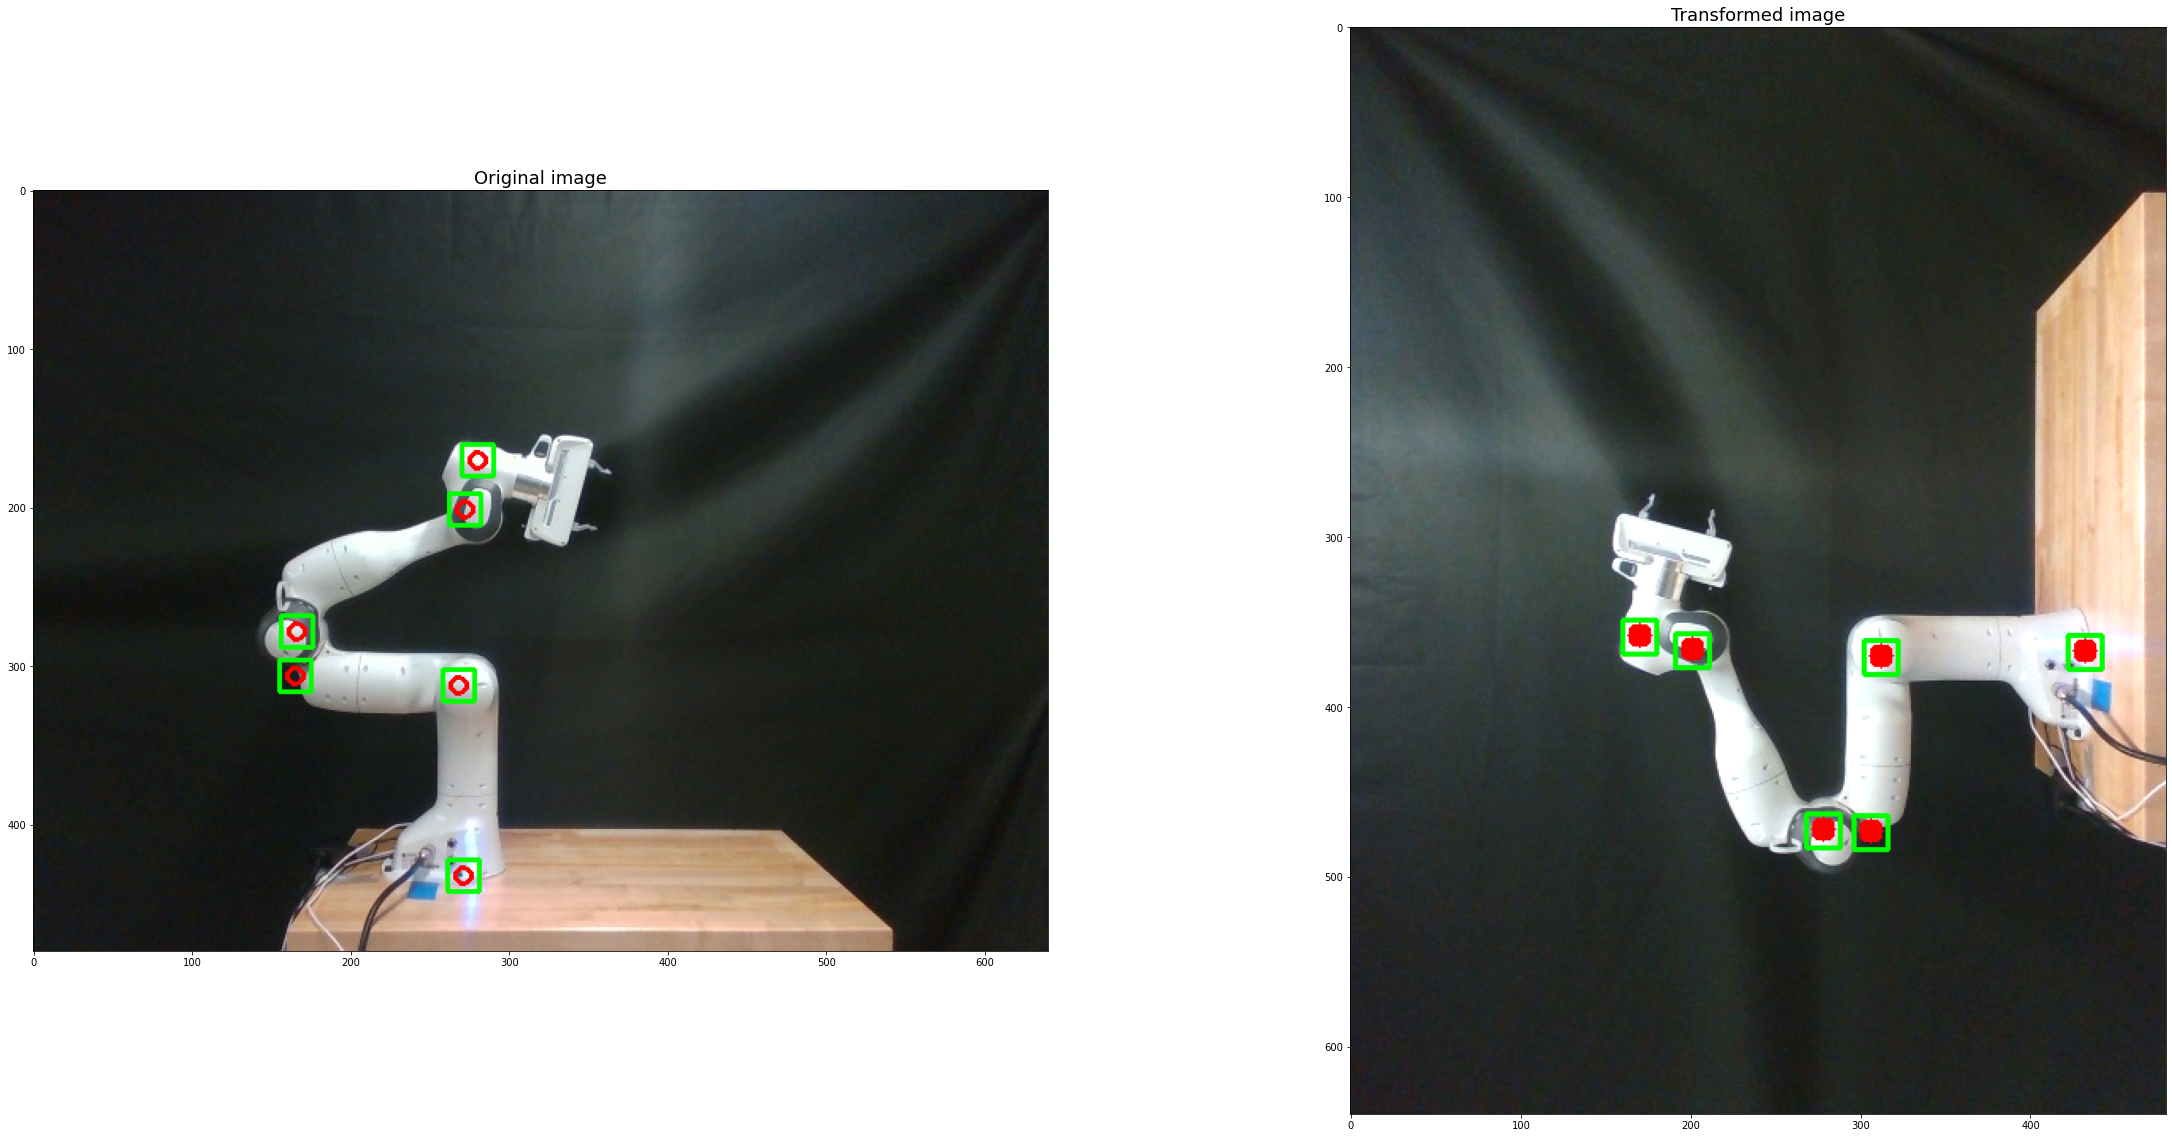

In [8]:
# function to visualize how the transformed data looks 

keypoints_classes_ids2names = {0: 'base_joint', 1: 'joint2', 2: 'joint3', 3: 'joint4', 4: 'joint5', 5: 'joint6',\
                              6:'joint7', 7:'joint8', 8:'panda_finger_1', 9:'panda_finger_2'}

def visualize(image, bboxes, keypoints, image_original=None, bboxes_original=None, keypoints_original=None):
    fontsize = 18

    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)
    
    for idx, kps in enumerate(keypoints):
        for kp in kps:
            image = cv2.circle(image.copy(), tuple(kp), 2, (255,0,0), 10)
#         image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1, cv2.LINE_AA)

    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(40,40))
        plt.imshow(image)
        
        return image

    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)
        
        print(keypoints_original)
        for idx, kps in enumerate(keypoints_original):
            print(idx)
            print(kps)
            for kp in kps:
                print(kp)
                image_original = cv2.circle(image_original, tuple(kp), 5, (255,0,0), 2)
#             image_original = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1, cv2.LINE_AA)

        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)
        
        return None
        
image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints = []
# for kps in batch1[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
#     keypoints.append([kp[:2] for kp in [kps]])
    
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp[:2] for kp in kps])

image_original = (batch[2][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints_original = []
# for kps in batch1[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
#     keypoints_original.append([kp[:2] for kp in [kps]])
    
for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints_original.append([kp[:2] for kp in kps])

visualize(image, bboxes, keypoints, image_original, bboxes_original, keypoints_original)

In [9]:
### made changes in the path ../.local/lib/python3.8/site-packages/albumentations/core/bbox_utils.py

'''def normalize_bbox(bbox: TBox, rows: int, cols: int) -> TBox:
    """Normalize coordinates of a bounding box. Divide x-coordinates by image width and y-coordinates
    by image height.

    Args:
        bbox: Denormalized bounding box `(x_min, y_min, x_max, y_max)`.
        rows: Image height.
        cols: Image width.

    Returns:
        Normalized bounding box `(x_min, y_min, x_max, y_max)`.

    Raises:
        ValueError: If rows or cols is less or equal zero

    """

    if rows <= 0:
        raise ValueError("Argument rows must be positive integer")
    if cols <= 0:
        raise ValueError("Argument cols must be positive integer")

    tail: Tuple[Any, ...]
    (x_min, y_min, x_max, y_max), tail = bbox[:4], tuple(bbox[4:])
    
    #x_min, x_max = x_min / cols, x_max / cols
    #y_min, y_max = y_min / rows, y_max / rows
    # next lines added by Jani
    x_min = max(0, x_min)
    y_min = max(0, y_min)
    x_max = min(cols - 1, x_max)
    y_max = min(rows - 1, y_max)
    
    return cast(BoxType, (x_min/cols, y_min/rows, x_max/cols, y_max/rows) + tail)  # type: ignore
'''

### made changes in the path ../.local/lib/python3.8/site-packages/albumentations/core/keypoint_utils.py
'''def check_keypoint(kp, rows, cols):
    for name, value, size in zip(["x", "y"], kp[:2], [cols, rows]):
        value = min(max(0.0, value), size - 1)
        kp = tuple([value if i == idx else x for i, x in enumerate(kp)])
        if not 0 <= value < size:
            raise ValueError(
                "Expected {name} for keypoint {kp} "
                "to be in the range [0.0, {size}], got {value}.".format(kp=kp, name=name, value=value, size=size)
            )
    angle = kp[2]
    if not (0 <= angle < 2 * math.pi):
        raise ValueError(
            "Expected angle for keypoint {kp} to be in the range [0.0, 2 * pi], got {angle}.".format(kp=kp, angle=angle)
        )
    return kp

'''

'def check_keypoint(kp, rows, cols):\n    for name, value, size in zip(["x", "y"], kp[:2], [cols, rows]):\n        value = min(max(0.0, value), size - 1)\n        kp = tuple([value if i == idx else x for i, x in enumerate(kp)])\n        if not 0 <= value < size:\n            raise ValueError(\n                "Expected {name} for keypoint {kp} "\n                "to be in the range [0.0, {size}], got {value}.".format(kp=kp, name=name, value=value, size=size)\n            )\n    angle = kp[2]\n    if not (0 <= angle < 2 * math.pi):\n        raise ValueError(\n            "Expected angle for keypoint {kp} to be in the range [0.0, 2 * pi], got {angle}.".format(kp=kp, angle=angle)\n        )\n    return kp\n\n'

In [10]:
def get_model(num_keypoints, weights_path=None):
    
    anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0))
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(weights=False,
                                                                   weights_backbone=True,
                                                                   num_keypoints=num_keypoints,
                                                                   num_classes = 7, # Background is the first class, object is the second class
                                                                   rpn_anchor_generator=anchor_generator)

    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)        
        
    return model

In [11]:
num_keypoints = 6
model = get_model(num_keypoints, weights_path=None)
model 

/home/jc-merlab/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/jc-merlab/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights_backbone=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights_backbone=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, 

In [12]:
total_keypoints = 6

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

split_folder_path = train_test_split(root_dir)

KEYPOINTS_FOLDER_TRAIN = split_folder_path +"/train" #train_test_split(root_dir) +"/train"
KEYPOINTS_FOLDER_VAL = split_folder_path +"/val"
KEYPOINTS_FOLDER_TEST = split_folder_path +"/test"

dataset_train = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=False)
# dataset_train = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=None, demo=False)
dataset_val = ClassDataset(KEYPOINTS_FOLDER_VAL, transform=None, demo=False)
dataset_test = ClassDataset(KEYPOINTS_FOLDER_TEST, transform=None, demo=False)

# batch_sizes = [3,2]
# epochs_lst = [30,50,100]

# batch_sizes = [3, 2, 1]
# epochs_lst = [25, 30]
batch_sizes = [4]
epochs_lst = [100]

v = 1

for b_size in batch_sizes:
    for epochs in epochs_lst:
        data_loader_train = DataLoader(dataset_train, batch_size=b_size, shuffle=True, collate_fn=collate_fn)
        data_loader_val = DataLoader(dataset_val, batch_size=1, shuffle=False, collate_fn=collate_fn)
        data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

        model = get_model(num_keypoints = total_keypoints)
        model.to(device)

        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)
        num_epochs = epochs

        for epoch in range(num_epochs):
            train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=1000)
            lr_scheduler.step()
            
#             if epoch == 25 or epoch == 30 :
#                 PATH = f"/home/jc-merlab/Pictures/Data/trained_models/keypointsrcnn_weights_ld_b{b_size}_e{epoch}_v{v}.pth"        
#                 torch.save(model, PATH)
#                 v+=1 
            
        
        PATH = f"/home/jc-merlab/Pictures/Data/trained_models/kprcnn_plan_b{b_size}_e{epochs}_v{v}.pth"
            
            
        torch.save(model, PATH)
        
           
        


#     evaluate(model, data_loader_val, device)


/home/jc-merlab/Pictures/panda_data/panda_sim_vel/path_planning_panda/split_folder_output


Copying files: 19068 files [00:06, 3151.91 files/s]


Epoch: [0]  [   0/1669]  eta: 1:41:33  lr: 0.000002  loss: 10.5265 (10.5265)  loss_classifier: 1.8837 (1.8837)  loss_box_reg: 0.0028 (0.0028)  loss_keypoint: 7.9035 (7.9035)  loss_objectness: 0.7017 (0.7017)  loss_rpn_box_reg: 0.0348 (0.0348)  time: 3.6512  data: 1.0706  max mem: 4782


KeyboardInterrupt: 

In [ ]:
# Save model weights after training
# torch.save(model.state_dict(), 'keypointsrcnn_weights_120.pth')
# torch.save(model, '/home/jc-merlab/Pictures/Data/trained_models/keypointsrcnn_weights_ld_b1_e30_v3.pth')
            
# torch.save(model, PATH)

In [ ]:
KEYPOINTS_FOLDER_VAL = parent_path + "split_folder_output-2023-07-14" +"/val"
dataset_val = ClassDataset(KEYPOINTS_FOLDER_VAL, transform=None, demo=False)
data_loader_val = DataLoader(dataset_val, batch_size=1, shuffle=False, collate_fn=collate_fn)
iterator = iter(data_loader_val)
len(data_loader_val)

In [ ]:
evaluate(model, data_loader_val, device)

In [ ]:
# weights_path = '/home/user/Workspace/WPI/Summer2023/ws/duc_repo/src/panda_test/data/trained_models/keypointsrcnn_weights_ld_b1_e25_v9.pth'
weights_path = PATH
model = torch.load(weights_path).to(device)
model.eval()

In [ ]:
data_iterator = iter(data_loader_val)
i = 1
while True:
    try:
        images, targets = next(data_iterator)
        images = list(img.to(device) for img in images)
        with torch.no_grad():
            outputs = model(images)
            images = (images[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
            scores = outputs[0]['scores'].detach().cpu().numpy()

            high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
            post_nms_idxs = torchvision.ops.nms(outputs[0]['boxes'][high_scores_idxs], outputs[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)
            keypoints = []
            for kps in outputs[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
                keypoints.append([list(map(int, kp[:2])) for kp in kps])

            bboxes = []
            for bbox in outputs[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
                bboxes.append(list(map(int, bbox.tolist())))
            img = visualize(images, bboxes, keypoints)
#             cv2.imwrite("/home/jc-merlab/Pictures/Data/video_results_01/out_image_" + str(i) + ".jpg", img)
            cv2.imshow(f'image{i}', img)

            cv2.waitKey(0)
            cv2.destroyWindow(f'image{i}')

            
            i = i+1

            # Calculate loss and metrics for evaluation here.
    except StopIteration:
        break         
        


In [ ]:
weights_path = '/home/user/Workspace/WPI/Summer2023/ws/duc_repo/src/panda_test/data/trained_models/keypointsrcnn_weights_ld_b1_e25_v1.pth'
model = torch.load(weights_path).to(device)

images1, targets1 = next(iterator)
images2, targets2 = next(iterator)
images3, targets3 = next(iterator)
images4, targets4 = next(iterator)
# images, targets = next(iterator)

print(type(images1))


images1 = list(image1.to(device) for image1 in images1)
images2 = list(image2.to(device) for image2 in images2)
images3 = list(image3.to(device) for image3 in images3)
images4 = list(image4.to(device) for image4 in images4)
# images = list(image.to(device) for image in images)

print(type(images1))

with torch.no_grad():
    model.to(device)
    model.eval()
    output1 = model(images1)
    output2 = model(images2)
    output3 = model(images3)
    output4 = model(images4)
#     output = model(image)

# print("Predictions: \n", output1)



In [ ]:
print("Predictions: \n", output1)


In [ ]:
for i, (images, targets) in enumerate(data_loader_val)

In [ ]:
import cv2
import numpy as np
import torch
import time

weights_path = '/home/jc-merlab/Pictures/Data/trained_models/keypointsrcnn_weights_ld_b1_e25_v2.pth'
model = torch.load(weights_path).to(device)
# model = get_model(num_keypoints=6, weights_path=weights_path)
# model.load_state_dict(torch.load('keypointsrcnn_weights.pth'))

model.to(device)
model.eval()

# print(type(model))
# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture('/home/jc-merlab/Pictures/Data/inference_data/test_video_3d.avi')
 
# Check if camera opened successfully
if (cap.isOpened()== False): 
    print("Error opening video stream or file")
i = 0
print(type(i))
while(cap.isOpened()):
  # Capture frame-by-frame
    print(i)
    ret, frame = cap.read()
    if ret == True:        
#         img = cv2.imread(frame)
        image = Image.fromarray(frame)

        image = F.to_tensor(image).to(device)
        image.unsqueeze_(0)
        image = list(image)
    
        with torch.no_grad():
            model.to(device)
            model.eval()
            start = time.time(now)
            output = model(image)
            stop = time.time(now)
            print("time", (stop - start))

        image = (image[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
        scores = output[0]['scores'].detach().cpu().numpy()

        high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
        post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

        # Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
        # Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
        # Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

        keypoints = []
        for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            keypoints.append([list(map(int, kp[:2])) for kp in kps])

        bboxes = []
        for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            bboxes.append(list(map(int, bbox.tolist())))
        img = visualize(image, bboxes, keypoints)
        
        cv2.imwrite("/home/jc-merlab/Pictures/Data/video_results_01/out_image_" + str(i) + ".jpg", img)
    
    else:
        break
        
    i = i+1
    
cap.release()
 
# Closes all the frames
cv2.destroyAllWindows()

In [ ]:
image1 = (images1[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
scores1 = output1[0]['scores'].detach().cpu().numpy()

high_scores_idxs = np.where(scores1 > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
post_nms_idxs = torchvision.ops.nms(output1[0]['boxes'][high_scores_idxs], output1[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

keypoints = []
for kps in output1[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append([list(map(int, kp[:2])) for kp in kps])
    
print(keypoints)

bboxes = []
for bbox in output1[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))
    
image = visualize(image1, bboxes, keypoints)






In [ ]:
image2 = (images2[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
scores = output2[0]['scores'].detach().cpu().numpy()

high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
post_nms_idxs = torchvision.ops.nms(output2[0]['boxes'][high_scores_idxs], output2[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

keypoints = []
for kps in output2[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append([list(map(int, kp[:2])) for kp in kps])

bboxes = []
for bbox in output2[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))
    
visualize(image2, bboxes, keypoints)

In [ ]:
image3 = (images3[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
scores3 = output3[0]['scores'].detach().cpu().numpy()

high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
post_nms_idxs = torchvision.ops.nms(output3[0]['boxes'][high_scores_idxs], output3[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

keypoints = []
for kps in output3[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append([list(map(int, kp[:2])) for kp in kps])

bboxes = []
for bbox in output3[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))
    
visualize(image3, bboxes, keypoints)

In [ ]:
image4 = (images4[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
scores4 = output4[0]['scores'].detach().cpu().numpy()

high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
post_nms_idxs = torchvision.ops.nms(output4[0]['boxes'][high_scores_idxs], output4[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

keypoints = []
for kps in output4[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append([list(map(int, kp[:2])) for kp in kps])

bboxes = []
for bbox in output4[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))
    
visualize(image4, bboxes, keypoints)

In [ ]:
image = Image.open("/home/jc-merlab/428.jpg")
print(type(image))

image = F.to_tensor(image).to(device)
image.unsqueeze_(0)
print(image.shape)
image = list(image)
# print(type(images))
# images = list(image.to(device) for image in images)

with torch.no_grad():
    model.to(device)
    model.eval()
    output = model(image)
    
    

In [ ]:
image = (image[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
scores = output[0]['scores'].detach().cpu().numpy()

high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

keypoints = []
for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append(list(map(int, kps[0,0:2])))
#     keypoints.append([list(map(int, kp[:2])) for kp in kps])
keypoints_ = [x for _,x in sorted(zip(labels,keypoints))]

bboxes = []
for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))
    
visualize(image, bboxes, keypoints)

In [ ]:
import cv2
import numpy as np

weights_path = 'keypointsrcnn_weights.pth'
model = get_model(num_keypoints=6, weights_path=weights_path)
model.load_state_dict(torch.load('keypointsrcnn_weights.pth'))

model.to(device)

model.eval()

# print(type(model))
# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture('/home/jc-merlab/nov1_v1.avi')
 
# Check if camera opened successfully
if (cap.isOpened()== False): 
    print("Error opening video stream or file")
i = 0
print(type(i))
while(cap.isOpened()):
  # Capture frame-by-frame
    print(i)
    ret, frame = cap.read()
    if ret == True:        
#         img = cv2.imread(frame)
        image = Image.fromarray(frame)

        image = F.to_tensor(image).to(device)
        image.unsqueeze_(0)
        image = list(image)
    
        with torch.no_grad():
            model.to(device)
            model.eval()
            output = model(image)

        image = (image[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
        scores = output[0]['scores'].detach().cpu().numpy()

        high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
        post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

        # Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
        # Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
        # Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

        keypoints = []
        for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            keypoints.append([list(map(int, kp[:2])) for kp in kps])

        bboxes = []
        for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            bboxes.append(list(map(int, bbox.tolist())))
        img = visualize(image, bboxes, keypoints)
        
        cv2.imwrite("/home/jc-merlab/Pictures/Data/video_results/out_image_" + str(i) + ".jpg", img)
        
    i = i+1
    
cap.release()
 
# Closes all the frames
cv2.destroyAllWindows()

In [ ]:
import os
import moviepy.video.io.ImageSequenceClip
image_folder="/home/jc-merlab/Pictures/Data/video_results/"

fps=1

image_files = [os.path.join(image_folder,img)
               for img in os.listdir(image_folder)
               if img.endswith(".jpg")]
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile('my_video.mp4')

In [ ]:
2500//72

In [ ]:
import cv2
import numpy as np
import torch
import time

weights_path = '/home/jc-merlab/Pictures/Data/trained_models/keypointsrcnn_weights_ld_b1_e25_v2.pth'
model = torch.load(weights_path).to(device)
# model = get_model(num_keypoints=6, weights_path=weights_path)
# model.load_state_dict(torch.load('keypointsrcnn_weights.pth'))

model.to(device)
model.eval()

# print(type(model))
# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture('/home/jc-merlab/Pictures/Data/inference_data/test_video_3d.avi')
 
# Check if camera opened successfully
if (cap.isOpened()== False): 
    print("Error opening video stream or file")
i = 0
print(type(i))
while(cap.isOpened()):
  # Capture frame-by-frame
    print(i)
    ret, frame = cap.read()
    if ret == True:        
#         img = cv2.imread(frame)
        image = Image.fromarray(frame)

        image = F.to_tensor(image).to(device)
        image.unsqueeze_(0)
        image = list(image)
        
    
        with torch.no_grad():
            model.to(device)
            model.eval()
            start = time.time(now)
            output = model(image)
            stop = time.time(now)
            print("time", (stop - start))

        image = (image[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
        scores = output[0]['scores'].detach().cpu().numpy()

        high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
        post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

        # Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
        # Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
        # Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

        keypoints = []
        for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            keypoints.append([list(map(int, kp[:2])) for kp in kps])

        bboxes = []
        for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            bboxes.append(list(map(int, bbox.tolist())))
        img = visualize(image, bboxes, keypoints)
        
        labels = []
        for label in output[0]['labels'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            labels.append(label)
        keypoints_ = [x for _,x in sorted(zip(labels,keypoints))]
        
        
        cv2.imwrite("/home/jc-merlab/Pictures/Data/video_results_01/out_image_" + str(i) + ".jpg", img)
    
    else:
        break
        
    i = i+1
    
cap.release()
 
# Closes all the frames
cv2.destroyAllWindows()

In [4]:
import cv2
import numpy as np
import torch
import time
import os
import json
import torch, torchvision
from PIL import Image
import torchvision.transforms as T
from torchvision.transforms import functional as F
import shutil

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

weights_path = '/home/jc-merlab/Pictures/Data/trained_models/keypointsrcnn_planning_b1_e50_v3.pth'
model = torch.load(weights_path).to(device)
# model = get_model(num_keypoints=6, weights_path=weights_path)
# model.load_state_dict(torch.load('keypointsrcnn_weights.pth'))

model.to(device)
model.eval()

# Specify input and output folders
input_folder = '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/path_planning_panda/'
output_frames_folder = '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/planning_data_predict/'
# output_json_folder = '/home/jc-merlab/Pictures/Data/keypoint_jsons'

# Check if output folders exist, create them if not
os.makedirs(output_frames_folder, exist_ok=True)
# os.makedirs(output_json_folder, exist_ok=True)

# Process images in the folder
i = 0
for filename in sorted(os.listdir(input_folder)):
    if filename.endswith('.jpg'):
        image_path = os.path.join(input_folder, filename)
        image = cv2.imread(image_path)  

        image = F.to_tensor(image).to(device)
        image.unsqueeze_(0)
        image = list(image)
        # print(type(images))
        # images = list(image.to(device) for image in images)

        with torch.no_grad():
            model.to(device)
            model.eval()
            output = model(image)
            image = (image[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
        scores = output[0]['scores'].detach().cpu().numpy()

        high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
        post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

        keypoints = []
        for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            keypoints.append(list(map(int, kps[0,0:2])))
            
        bboxes = []
        for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            bboxes.append(list(map(int, bbox.tolist())))
       
        labels = []
        for label in output[0]['labels'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            labels.append(label)
            
        keypoints_ = [x for _,x in sorted(zip(labels,keypoints))]
        print(keypoints_)
        bbox_ = [x for _,x in sorted(zip(labels,bboxes))]
        print(bbox_[3])
        
        # Modify the 4th keypoint as per the requirement
#         if len(keypoints_) >= 4 and len(bbox_) >= 4:
#             fourth_bbox = bbox_[3]
#             # Replace 4th keypoint with the top-left corner of the 4th bounding box
#             keypoints_[3] = [fourth_bbox[0], fourth_bbox[1]]
#             # Append the bottom-right corner of the 4th bounding box as a new keypoint
#             keypoints_.append([fourth_bbox[2], fourth_bbox[3]])
            
        print(keypoints_)

        # Generate JSON data
        image_filename_base = os.path.splitext(filename)[0]  # Remove '.jpg' extension
        json_data = {
            "id": i,
            "image_rgb": filename,  
            "keypoints": [[kp] for kp in keypoints_]
        }

        # Copy image to output folder
        output_image_path = os.path.join(output_frames_folder, filename)
        shutil.copyfile(image_path, output_image_path)

        # Save JSON with matching filename
        output_json_path = os.path.join(output_frames_folder, f"{image_filename_base}.json") 
        with open(output_json_path, 'w') as f:
            json.dump(json_data, f)

        i += 1

print("Processing complete!")

cuda
[[267, 433], [268, 311], [176, 263], [187, 238], [225, 107], [210, 86]]
[178, 227, 197, 248]
[[267, 433], [268, 311], [176, 263], [187, 238], [225, 107], [210, 86]]
[[271, 431], [268, 311], [177, 263], [187, 238], [225, 107], [210, 87]]
[177, 228, 197, 248]
[[271, 431], [268, 311], [177, 263], [187, 238], [225, 107], [210, 87]]
[[271, 431], [268, 311], [177, 264], [187, 238], [225, 108], [212, 86]]
[177, 228, 197, 248]
[[271, 431], [268, 311], [177, 264], [187, 238], [225, 108], [212, 86]]
[[267, 434], [268, 311], [176, 263], [187, 238], [225, 107], [211, 85]]
[178, 228, 197, 248]
[[267, 434], [268, 311], [176, 263], [187, 238], [225, 107], [211, 85]]
[[267, 433], [269, 312], [177, 264], [187, 238], [225, 108]]
[177, 228, 197, 248]
[[267, 433], [269, 312], [177, 264], [187, 238], [225, 108]]
[[267, 433], [268, 311], [176, 263], [187, 238], [225, 108]]
[177, 227, 197, 248]
[[267, 433], [268, 311], [176, 263], [187, 238], [225, 108]]
[[271, 432], [268, 311], [177, 263], [187, 238], 

[[267, 433], [268, 312], [177, 263], [187, 238], [226, 108], [240, 82]]
[178, 228, 197, 248]
[[267, 433], [268, 312], [177, 263], [187, 238], [226, 108], [240, 82]]
[[271, 431], [268, 312], [177, 263], [187, 238], [227, 109], [240, 83]]
[177, 228, 197, 248]
[[271, 431], [268, 312], [177, 263], [187, 238], [227, 109], [240, 83]]
[[270, 432], [269, 312], [177, 263], [187, 238], [226, 109], [240, 83]]
[177, 228, 197, 248]
[[270, 432], [269, 312], [177, 263], [187, 238], [226, 109], [240, 83]]
[[268, 433], [268, 311], [177, 263], [187, 238], [226, 109], [241, 83]]
[178, 228, 197, 248]
[[268, 433], [268, 311], [177, 263], [187, 238], [226, 109], [241, 83]]
[[270, 432], [268, 312], [176, 263], [187, 238], [226, 109], [241, 83]]
[177, 227, 197, 248]
[[270, 432], [268, 312], [176, 263], [187, 238], [226, 109], [241, 83]]
[[267, 433], [269, 312], [177, 263], [187, 238], [226, 109], [242, 85]]
[178, 227, 197, 248]
[[267, 433], [269, 312], [177, 263], [187, 238], [226, 109], [242, 85]]
[[271, 431

[[267, 434], [269, 312], [177, 263], [188, 238], [264, 127], [293, 115]]
[178, 228, 197, 248]
[[267, 434], [269, 312], [177, 263], [188, 238], [264, 127], [293, 115]]
[[267, 433], [269, 312], [177, 263], [187, 238], [265, 127], [293, 115]]
[178, 227, 197, 248]
[[267, 433], [269, 312], [177, 263], [187, 238], [265, 127], [293, 115]]
[[267, 433], [269, 312], [176, 263], [188, 238], [266, 128], [294, 117]]
[178, 227, 197, 247]
[[267, 433], [269, 312], [176, 263], [188, 238], [266, 128], [294, 117]]
[[271, 431], [268, 312], [177, 264], [187, 238], [267, 129], [294, 118]]
[178, 228, 197, 248]
[[271, 431], [268, 312], [177, 264], [187, 238], [267, 129], [294, 118]]
[[271, 431], [268, 312], [177, 263], [187, 238], [268, 129], [295, 119]]
[178, 227, 197, 248]
[[271, 431], [268, 312], [177, 263], [187, 238], [268, 129], [295, 119]]
[[271, 431], [269, 312], [176, 264], [188, 238], [270, 131], [297, 120]]
[178, 228, 197, 248]
[[271, 431], [269, 312], [176, 264], [188, 238], [270, 131], [297, 120]

[[271, 432], [269, 312], [177, 264], [188, 238], [270, 131], [277, 102]]
[178, 227, 197, 247]
[[271, 432], [269, 312], [177, 264], [188, 238], [270, 131], [277, 102]]
[[271, 431], [268, 311], [176, 264], [187, 238], [270, 131], [277, 102]]
[178, 227, 197, 248]
[[271, 431], [268, 311], [176, 264], [187, 238], [270, 131], [277, 102]]
[[267, 433], [269, 312], [177, 263], [187, 238], [270, 131], [278, 102]]
[178, 227, 197, 248]
[[267, 433], [269, 312], [177, 263], [187, 238], [270, 131], [278, 102]]
[[272, 429], [269, 312], [176, 264], [187, 238], [270, 131], [278, 101]]
[178, 227, 197, 247]
[[272, 429], [269, 312], [176, 264], [187, 238], [270, 131], [278, 101]]
[[271, 432], [268, 311], [177, 263], [188, 237], [270, 131], [276, 101]]
[179, 227, 197, 247]
[[271, 432], [268, 311], [177, 263], [188, 237], [270, 131], [276, 101]]
[[267, 433], [268, 312], [176, 263], [187, 237], [270, 131], [275, 101]]
[178, 227, 197, 248]
[[267, 433], [268, 312], [176, 263], [187, 237], [270, 131], [275, 101]

[[267, 433], [269, 312], [176, 263], [187, 238], [288, 149], [282, 120]]
[178, 228, 197, 248]
[[267, 433], [269, 312], [176, 263], [187, 238], [288, 149], [282, 120]]
[[271, 431], [269, 312], [177, 264], [188, 238], [288, 150], [284, 120]]
[178, 228, 197, 248]
[[271, 431], [269, 312], [177, 264], [188, 238], [288, 150], [284, 120]]
[[267, 434], [269, 312], [177, 264], [187, 238], [288, 150], [284, 122]]
[178, 228, 197, 248]
[[267, 434], [269, 312], [177, 264], [187, 238], [288, 150], [284, 122]]
[[271, 431], [269, 312], [176, 264], [188, 238], [289, 151], [284, 123]]
[178, 228, 197, 248]
[[271, 431], [269, 312], [176, 264], [188, 238], [289, 151], [284, 123]]
[[271, 431], [269, 312], [177, 263], [188, 238], [290, 152], [286, 122]]
[178, 227, 197, 248]
[[271, 431], [269, 312], [177, 263], [188, 238], [290, 152], [286, 122]]
[[271, 432], [269, 311], [177, 264], [187, 238], [290, 152], [286, 123]]
[178, 228, 196, 248]
[[271, 432], [269, 311], [177, 264], [187, 238], [290, 152], [286, 123]

[[271, 431], [268, 311], [177, 264], [187, 238], [305, 171], [320, 147]]
[177, 228, 196, 249]
[[271, 431], [268, 311], [177, 264], [187, 238], [305, 171], [320, 147]]
[[268, 433], [269, 312], [176, 264], [187, 238], [305, 171], [321, 148]]
[178, 228, 197, 248]
[[268, 433], [269, 312], [176, 264], [187, 238], [305, 171], [321, 148]]
[[267, 433], [269, 312], [176, 264], [187, 238], [305, 172], [321, 148]]
[177, 228, 196, 249]
[[267, 433], [269, 312], [176, 264], [187, 238], [305, 172], [321, 148]]
[[270, 431], [269, 312], [176, 264], [187, 238], [305, 171], [321, 150], [323, 148]]
[177, 228, 196, 249]
[[270, 431], [269, 312], [176, 264], [187, 238], [305, 171], [321, 150], [323, 148]]
[[268, 433], [269, 312], [176, 264], [187, 238], [305, 171], [321, 149], [323, 147]]
[177, 228, 196, 249]
[[268, 433], [269, 312], [176, 264], [187, 238], [305, 171], [321, 149], [323, 147]]
[[272, 429], [268, 312], [176, 264], [187, 238], [304, 172], [321, 150], [323, 147]]
[178, 228, 196, 249]
[[272, 429]

[[267, 433], [269, 312], [177, 264], [187, 238], [305, 171], [334, 173]]
[177, 228, 196, 249]
[[267, 433], [269, 312], [177, 264], [187, 238], [305, 171], [334, 173]]
[[271, 431], [268, 312], [176, 263], [188, 238], [305, 172], [334, 175]]
[178, 227, 197, 248]
[[271, 431], [268, 312], [176, 263], [188, 238], [305, 172], [334, 175]]
[[268, 433], [269, 312], [177, 261], [189, 236], [308, 173], [338, 175]]
[179, 226, 198, 247]
[[268, 433], [269, 312], [177, 261], [189, 236], [308, 173], [338, 175]]
[[271, 431], [268, 312], [178, 259], [190, 234], [312, 174], [340, 178]]
[180, 224, 200, 244]
[[271, 431], [268, 312], [178, 259], [190, 234], [312, 174], [340, 178]]
[[267, 433], [268, 311], [178, 257], [192, 232], [314, 175], [344, 180]]
[182, 222, 201, 242]
[[267, 433], [268, 311], [178, 257], [192, 232], [314, 175], [344, 180]]
[[271, 431], [268, 312], [180, 255], [193, 230], [317, 175], [346, 180]]
[183, 220, 203, 240]
[[271, 431], [268, 312], [180, 255], [193, 230], [317, 175], [346, 180]

[[271, 431], [269, 312], [276, 199], [304, 201], [415, 291], [430, 318]]
[294, 191, 314, 211]
[[271, 431], [269, 312], [276, 199], [304, 201], [415, 291], [430, 318]]
[[271, 432], [269, 311], [276, 199], [304, 201], [415, 291], [431, 317]]
[294, 191, 314, 211]
[[271, 432], [269, 311], [276, 199], [304, 201], [415, 291], [431, 317]]
[[267, 433], [268, 311], [276, 200], [304, 201], [415, 291], [432, 317]]
[294, 191, 314, 210]
[[267, 433], [268, 311], [276, 200], [304, 201], [415, 291], [432, 317]]
[[268, 433], [269, 312], [275, 199], [304, 201], [415, 291], [432, 316]]
[293, 191, 314, 211]
[[268, 433], [269, 312], [275, 199], [304, 201], [415, 291], [432, 316]]
[[267, 433], [269, 311], [275, 199], [304, 201], [415, 291], [432, 316]]
[294, 191, 314, 210]
[[267, 433], [269, 311], [275, 199], [304, 201], [415, 291], [432, 316]]
[[267, 433], [269, 311], [276, 199], [304, 201], [415, 291], [432, 315]]
[293, 191, 314, 211]
[[267, 433], [269, 311], [276, 199], [304, 201], [415, 291], [432, 315]

[[267, 433], [269, 312], [276, 200], [304, 201], [414, 291], [446, 284]]
[294, 191, 314, 211]
[[267, 433], [269, 312], [276, 200], [304, 201], [414, 291], [446, 284]]
[[267, 433], [269, 312], [276, 200], [304, 201], [415, 291], [445, 283]]
[294, 191, 314, 210]
[[267, 433], [269, 312], [276, 200], [304, 201], [415, 291], [445, 283]]
[[267, 433], [269, 311], [276, 199], [304, 201], [414, 291], [445, 283]]
[294, 191, 314, 211]
[[267, 433], [269, 311], [276, 199], [304, 201], [414, 291], [445, 283]]
[[267, 433], [269, 311], [275, 199], [304, 201], [414, 291], [445, 282]]
[294, 190, 314, 210]
[[267, 433], [269, 311], [275, 199], [304, 201], [414, 291], [445, 282]]
[[267, 433], [269, 312], [276, 200], [304, 201], [414, 290], [445, 282]]
[293, 191, 314, 211]
[[267, 433], [269, 312], [276, 200], [304, 201], [414, 290], [445, 282]]
[[271, 431], [269, 311], [276, 200], [304, 201], [414, 291], [445, 281]]
[294, 191, 314, 211]
[[271, 431], [269, 311], [276, 200], [304, 201], [414, 291], [445, 281]

[[273, 429], [269, 312], [276, 200], [303, 201], [439, 248], [461, 225]]
[294, 191, 313, 211]
[[273, 429], [269, 312], [276, 200], [303, 201], [439, 248], [461, 225]]
[[270, 432], [268, 311], [276, 199], [303, 201], [439, 247], [462, 225]]
[293, 190, 313, 210]
[[270, 432], [268, 311], [276, 199], [303, 201], [439, 247], [462, 225]]
[[271, 431], [269, 311], [276, 200], [304, 201], [440, 246], [461, 223]]
[294, 191, 313, 210]
[[271, 431], [269, 311], [276, 200], [304, 201], [440, 246], [461, 223]]
[[267, 433], [269, 311], [276, 199], [303, 201], [439, 246], [461, 223]]
[294, 191, 313, 210]
[[267, 433], [269, 311], [276, 199], [303, 201], [439, 246], [461, 223]]
[[272, 429], [269, 311], [276, 200], [303, 201], [441, 244], [461, 222]]
[294, 191, 313, 211]
[[272, 429], [269, 311], [276, 200], [303, 201], [441, 244], [461, 222]]
[[271, 431], [269, 311], [276, 200], [303, 201], [440, 242], [464, 218]]
[293, 191, 313, 210]
[[271, 431], [269, 311], [276, 200], [303, 201], [440, 242], [464, 218]

[[267, 433], [269, 311], [276, 200], [304, 200], [441, 243], [471, 250]]
[294, 191, 313, 210]
[[267, 433], [269, 311], [276, 200], [304, 200], [441, 243], [471, 250]]
[[267, 433], [268, 311], [276, 199], [303, 201], [440, 242], [471, 250]]
[293, 190, 313, 210]
[[267, 433], [268, 311], [276, 199], [303, 201], [440, 242], [471, 250]]
[[268, 433], [269, 311], [276, 200], [304, 201], [441, 242], [471, 251]]
[293, 190, 313, 210]
[[268, 433], [269, 311], [276, 200], [304, 201], [441, 242], [471, 251]]
[[267, 433], [269, 312], [276, 200], [303, 201], [440, 242], [470, 251]]
[294, 190, 313, 210]
[[267, 433], [269, 312], [276, 200], [303, 201], [440, 242], [470, 251]]
[[267, 433], [269, 311], [276, 200], [304, 201], [441, 243], [470, 252]]
[294, 191, 313, 210]
[[267, 433], [269, 311], [276, 200], [304, 201], [441, 243], [470, 252]]
[[270, 432], [269, 311], [276, 199], [303, 201], [440, 243], [470, 254]]
[294, 191, 313, 211]
[[270, 432], [269, 311], [276, 199], [303, 201], [440, 243], [470, 254]

[[268, 433], [268, 311], [276, 200], [304, 201], [446, 207], [473, 223]]
[294, 191, 313, 210]
[[268, 433], [268, 311], [276, 200], [304, 201], [446, 207], [473, 223]]
[[272, 429], [269, 311], [276, 200], [304, 201], [446, 206], [474, 223]]
[294, 191, 314, 211]
[[272, 429], [269, 311], [276, 200], [304, 201], [446, 206], [474, 223]]
[[271, 432], [269, 311], [276, 200], [304, 201], [446, 205], [473, 221]]
[294, 191, 314, 211]
[[271, 432], [269, 311], [276, 200], [304, 201], [446, 205], [473, 221]]
[[271, 431], [269, 311], [276, 200], [304, 201], [447, 204], [474, 221]]
[294, 191, 314, 211]
[[271, 431], [269, 311], [276, 200], [304, 201], [447, 204], [474, 221]]
[[271, 432], [268, 311], [276, 200], [304, 201], [448, 202], [476, 219]]
[294, 191, 313, 211]
[[271, 432], [268, 311], [276, 200], [304, 201], [448, 202], [476, 219]]
[[267, 433], [269, 311], [276, 200], [304, 201], [448, 202], [476, 218]]
[294, 191, 313, 211]
[[267, 433], [269, 311], [276, 200], [304, 201], [448, 202], [476, 218]

[[267, 433], [268, 311], [276, 200], [304, 202], [447, 185], [475, 171]]
[295, 191, 314, 211]
[[267, 433], [268, 311], [276, 200], [304, 202], [447, 185], [475, 171]]
[[268, 433], [269, 311], [276, 200], [304, 201], [447, 186], [475, 171]]
[294, 191, 314, 210]
[[268, 433], [269, 311], [276, 200], [304, 201], [447, 186], [475, 171]]
[[271, 431], [268, 311], [276, 199], [304, 201], [447, 186], [474, 170]]
[294, 191, 314, 211]
[[271, 431], [268, 311], [276, 199], [304, 201], [447, 186], [474, 170]]
[[270, 431], [269, 311], [276, 200], [304, 201], [446, 185], [474, 168]]
[294, 191, 313, 211]
[[270, 431], [269, 311], [276, 200], [304, 201], [446, 185], [474, 168]]
[[271, 431], [269, 311], [276, 199], [304, 201], [446, 185], [474, 169]]
[294, 191, 314, 211]
[[271, 431], [269, 311], [276, 199], [304, 201], [446, 185], [474, 169]]
[[268, 433], [269, 311], [276, 200], [304, 201], [446, 186], [473, 169]]
[295, 191, 314, 211]
[[268, 433], [269, 311], [276, 200], [304, 201], [446, 186], [473, 169]

[[267, 433], [269, 311], [323, 212], [348, 225], [486, 275], [511, 253]]
[338, 215, 357, 235]
[[267, 433], [269, 311], [323, 212], [348, 225], [486, 275], [511, 253]]
[[272, 429], [269, 311], [325, 213], [351, 227], [485, 280], [511, 256]]
[340, 216, 360, 236]
[[272, 429], [269, 311], [325, 213], [351, 227], [485, 280], [511, 256]]
[[267, 433], [270, 311], [327, 216], [352, 230], [487, 289], [511, 268]]
[342, 220, 362, 240]
[[267, 433], [270, 311], [327, 216], [352, 230], [487, 289], [511, 268]]
[[267, 433], [269, 311], [330, 216], [354, 231], [487, 292], [511, 271]]
[345, 220, 364, 241]
[[267, 433], [269, 311], [330, 216], [354, 231], [487, 292], [511, 271]]
[[271, 431], [270, 311], [332, 219], [357, 233], [488, 300], [512, 276]]
[347, 224, 366, 244]
[[271, 431], [270, 311], [332, 219], [357, 233], [488, 300], [512, 276]]
[[270, 431], [270, 311], [333, 220], [358, 236], [489, 304], [516, 284]]
[349, 226, 368, 247]
[[270, 431], [270, 311], [333, 220], [358, 236], [489, 304], [516, 284]

[[267, 433], [268, 311], [176, 263], [187, 238], [225, 108], [230, 77], [230, 78]]
[177, 227, 196, 248]
[[267, 433], [268, 311], [176, 263], [187, 238], [225, 108], [230, 77], [230, 78]]
[[267, 433], [268, 312], [176, 263], [187, 238], [225, 108], [229, 77]]
[177, 228, 197, 248]
[[267, 433], [268, 312], [176, 263], [187, 238], [225, 108], [229, 77]]
[[271, 431], [268, 311], [176, 263], [187, 238], [225, 108], [229, 78]]
[177, 228, 197, 248]
[[271, 431], [268, 311], [176, 263], [187, 238], [225, 108], [229, 78]]
[[272, 429], [268, 312], [176, 263], [187, 238], [225, 108], [230, 79]]
[177, 227, 197, 248]
[[272, 429], [268, 312], [176, 263], [187, 238], [225, 108], [230, 79]]
[[271, 431], [268, 312], [176, 263], [187, 238], [225, 108], [229, 78]]
[178, 227, 197, 248]
[[271, 431], [268, 312], [176, 263], [187, 238], [225, 108], [229, 78]]
[[271, 431], [268, 311], [176, 263], [187, 238], [226, 108], [233, 80]]
[177, 227, 196, 248]
[[271, 431], [268, 311], [176, 263], [187, 238], [226, 108],

[[271, 432], [268, 312], [176, 263], [187, 238], [232, 111], [252, 88], [256, 91]]
[177, 228, 197, 248]
[[271, 432], [268, 312], [176, 263], [187, 238], [232, 111], [252, 88], [256, 91]]
[[271, 432], [268, 311], [176, 264], [187, 238], [234, 112], [252, 89], [257, 92]]
[177, 228, 197, 248]
[[271, 432], [268, 311], [176, 264], [187, 238], [234, 112], [252, 89], [257, 92]]
[[270, 431], [268, 311], [177, 264], [187, 238], [233, 112], [252, 89], [257, 93]]
[177, 228, 197, 248]
[[270, 431], [268, 311], [177, 264], [187, 238], [233, 112], [252, 89], [257, 93]]
[[268, 433], [268, 311], [176, 264], [187, 238], [234, 112], [258, 92]]
[177, 228, 197, 248]
[[268, 433], [268, 311], [176, 264], [187, 238], [234, 112], [258, 92]]
[[271, 432], [268, 312], [176, 263], [187, 238], [235, 113], [259, 92]]
[177, 227, 197, 248]
[[271, 432], [268, 312], [176, 263], [187, 238], [235, 113], [259, 92]]
[[271, 431], [268, 311], [176, 264], [187, 238], [236, 112], [258, 93], [259, 92]]
[177, 227, 197, 248]
[[271

[[271, 431], [269, 312], [177, 264], [187, 238], [249, 118], [269, 95], [269, 95]]
[177, 227, 196, 248]
[[271, 431], [269, 312], [177, 264], [187, 238], [249, 118], [269, 95], [269, 95]]
[[271, 431], [268, 311], [176, 264], [187, 238], [249, 118], [268, 96]]
[177, 227, 196, 248]
[[271, 431], [268, 311], [176, 264], [187, 238], [249, 118], [268, 96]]
[[271, 431], [269, 311], [176, 263], [186, 238], [249, 118], [268, 95]]
[177, 228, 196, 248]
[[271, 431], [269, 311], [176, 263], [186, 238], [249, 118], [268, 95]]
[[271, 431], [268, 311], [176, 263], [187, 238], [249, 118], [267, 95]]
[177, 228, 196, 248]
[[271, 431], [268, 311], [176, 263], [187, 238], [249, 118], [267, 95]]
[[271, 431], [269, 311], [176, 263], [187, 238], [248, 118], [267, 94], [269, 89]]
[177, 227, 197, 248]
[[271, 431], [269, 311], [176, 263], [187, 238], [248, 118], [267, 94], [269, 89]]
[[271, 431], [268, 311], [176, 263], [187, 238], [249, 118], [266, 93]]
[177, 228, 196, 248]
[[271, 431], [268, 311], [176, 263], [

[[271, 432], [268, 311], [176, 264], [187, 238], [248, 117], [243, 89]]
[177, 228, 196, 248]
[[271, 432], [268, 311], [176, 264], [187, 238], [248, 117], [243, 89]]
[[267, 433], [268, 312], [176, 264], [187, 238], [248, 118], [242, 89]]
[177, 227, 196, 248]
[[267, 433], [268, 312], [176, 264], [187, 238], [248, 118], [242, 89]]
[[267, 433], [269, 312], [176, 264], [187, 238], [248, 118], [244, 90]]
[177, 228, 196, 248]
[[267, 433], [269, 312], [176, 264], [187, 238], [248, 118], [244, 90]]
[[271, 431], [268, 312], [176, 264], [187, 237], [248, 118], [239, 91]]
[177, 227, 197, 248]
[[271, 431], [268, 312], [176, 264], [187, 237], [248, 118], [239, 91]]
[[271, 431], [268, 311], [176, 264], [187, 238], [248, 118], [238, 91]]
[177, 227, 197, 248]
[[271, 431], [268, 311], [176, 264], [187, 238], [248, 118], [238, 91]]
[[267, 433], [268, 312], [176, 264], [187, 237], [249, 119], [239, 93]]
[177, 227, 197, 248]
[[267, 433], [268, 312], [176, 264], [187, 237], [249, 119], [239, 93]]
[[271, 431

[[271, 431], [268, 311], [176, 263], [187, 238], [268, 130], [258, 103]]
[177, 228, 197, 248]
[[271, 431], [268, 311], [176, 263], [187, 238], [268, 130], [258, 103]]
[[272, 429], [268, 311], [176, 263], [188, 238], [268, 129], [260, 102]]
[178, 227, 197, 247]
[[272, 429], [268, 311], [176, 263], [188, 238], [268, 129], [260, 102]]
[[268, 433], [269, 312], [176, 264], [187, 238], [268, 130], [258, 102]]
[177, 228, 197, 248]
[[268, 433], [269, 312], [176, 264], [187, 238], [268, 130], [258, 102]]
[[272, 430], [268, 312], [176, 264], [187, 237], [268, 131], [259, 102]]
[177, 227, 197, 248]
[[272, 430], [268, 312], [176, 264], [187, 237], [268, 131], [259, 102]]
[[271, 432], [268, 311], [176, 264], [187, 238], [269, 131], [263, 103]]
[177, 228, 196, 248]
[[271, 432], [268, 311], [176, 264], [187, 238], [269, 131], [263, 103]]
[[267, 433], [269, 312], [177, 264], [188, 237], [269, 132], [263, 104]]
[178, 227, 197, 247]
[[267, 433], [269, 312], [177, 264], [188, 237], [269, 132], [263, 104]

[[268, 433], [268, 312], [177, 263], [188, 238], [269, 131], [286, 105]]
[178, 227, 197, 247]
[[268, 433], [268, 312], [177, 263], [188, 238], [269, 131], [286, 105]]
[[271, 431], [268, 311], [177, 263], [188, 237], [270, 131], [287, 105]]
[178, 227, 197, 247]
[[271, 431], [268, 311], [177, 263], [188, 237], [270, 131], [287, 105]]
[[270, 431], [268, 311], [177, 264], [187, 238], [270, 131], [287, 106]]
[177, 228, 197, 248]
[[270, 431], [268, 311], [177, 264], [187, 238], [270, 131], [287, 106]]
[[271, 432], [269, 312], [177, 263], [188, 237], [270, 131], [288, 106]]
[178, 227, 197, 247]
[[271, 432], [269, 312], [177, 263], [188, 237], [270, 131], [288, 106]]
[[267, 433], [268, 311], [176, 263], [187, 238], [270, 131], [287, 109], [288, 106]]
[177, 227, 197, 248]
[[267, 433], [268, 311], [176, 263], [187, 238], [270, 131], [287, 109], [288, 106]]
[[267, 433], [268, 311], [177, 263], [187, 238], [270, 131], [290, 106]]
[177, 227, 197, 248]
[[267, 433], [268, 311], [177, 263], [187, 238]

[[271, 431], [268, 312], [176, 263], [188, 238], [279, 138], [305, 131]]
[178, 227, 197, 247]
[[271, 431], [268, 312], [176, 263], [188, 238], [279, 138], [305, 131]]
[[268, 433], [268, 311], [176, 263], [187, 238], [279, 137], [305, 129]]
[177, 228, 197, 248]
[[268, 433], [268, 311], [176, 263], [187, 238], [279, 137], [305, 129]]
[[270, 432], [269, 312], [176, 264], [188, 238], [279, 138], [306, 131]]
[178, 227, 197, 248]
[[270, 432], [269, 312], [176, 264], [188, 238], [279, 138], [306, 131]]
[[271, 432], [268, 312], [177, 264], [187, 238], [279, 139], [308, 131]]
[178, 227, 197, 247]
[[271, 432], [268, 312], [177, 264], [187, 238], [279, 139], [308, 131]]
[[271, 432], [268, 312], [176, 264], [187, 238], [280, 139], [307, 131]]
[177, 228, 197, 248]
[[271, 432], [268, 312], [176, 264], [187, 238], [280, 139], [307, 131]]
[[271, 432], [269, 312], [176, 264], [187, 238], [280, 140], [308, 132]]
[177, 228, 197, 248]
[[271, 432], [269, 312], [176, 264], [187, 238], [280, 140], [308, 132]

[[271, 431], [268, 311], [177, 263], [188, 238], [289, 151], [314, 135], [316, 134]]
[178, 227, 197, 247]
[[271, 431], [268, 311], [177, 263], [188, 238], [289, 151], [314, 135], [316, 134]]
[[267, 433], [268, 311], [177, 263], [188, 238], [289, 151], [313, 134]]
[178, 227, 197, 247]
[[267, 433], [268, 311], [177, 263], [188, 238], [289, 151], [313, 134]]
[[271, 431], [269, 312], [177, 263], [188, 238], [289, 151], [314, 134]]
[178, 227, 197, 247]
[[271, 431], [269, 312], [177, 263], [188, 238], [289, 151], [314, 134]]
[[268, 433], [268, 311], [176, 264], [187, 238], [289, 151], [314, 133]]
[178, 227, 197, 248]
[[268, 433], [268, 311], [176, 264], [187, 238], [289, 151], [314, 133]]
[[271, 431], [268, 311], [177, 264], [187, 238], [289, 151], [313, 133]]
[178, 228, 197, 248]
[[271, 431], [268, 311], [177, 264], [187, 238], [289, 151], [313, 133]]
[[270, 432], [268, 311], [177, 264], [188, 238], [289, 151], [312, 132]]
[178, 228, 197, 248]
[[270, 432], [268, 311], [177, 264], [188, 238]

[[271, 432], [268, 311], [177, 263], [187, 238], [289, 149], [292, 119]]
[178, 227, 197, 247]
[[271, 432], [268, 311], [177, 263], [187, 238], [289, 149], [292, 119]]
[[268, 433], [268, 311], [177, 263], [188, 238], [288, 149], [291, 119]]
[178, 228, 197, 248]
[[268, 433], [268, 311], [177, 263], [188, 238], [288, 149], [291, 119]]
[[271, 431], [268, 311], [177, 263], [187, 238], [288, 149], [290, 119]]
[178, 227, 197, 248]
[[271, 431], [268, 311], [177, 263], [187, 238], [288, 149], [290, 119]]
[[268, 433], [269, 312], [176, 263], [188, 238], [288, 149], [287, 116], [289, 119]]
[178, 228, 197, 248]
[[268, 433], [269, 312], [176, 263], [188, 238], [288, 149], [287, 116], [289, 119]]
[[271, 431], [269, 312], [176, 264], [187, 238], [288, 149], [287, 116], [287, 119]]
[177, 228, 196, 248]
[[271, 431], [269, 312], [176, 264], [187, 238], [288, 149], [287, 116], [287, 119]]
[[267, 433], [269, 312], [177, 264], [188, 238], [288, 149], [288, 116], [288, 119]]
[178, 227, 197, 248]
[[267, 433]

[[271, 432], [269, 312], [176, 264], [187, 238], [299, 163], [298, 133]]
[178, 228, 196, 248]
[[271, 432], [269, 312], [176, 264], [187, 238], [299, 163], [298, 133]]
[[267, 433], [268, 312], [176, 264], [187, 238], [299, 164], [298, 135]]
[178, 228, 197, 248]
[[267, 433], [268, 312], [176, 264], [187, 238], [299, 164], [298, 135]]
[[267, 434], [268, 312], [176, 264], [187, 238], [299, 164], [298, 134]]
[177, 228, 196, 249]
[[267, 434], [268, 312], [176, 264], [187, 238], [299, 164], [298, 134]]
[[270, 432], [268, 311], [176, 264], [188, 238], [300, 165], [298, 135]]
[178, 228, 197, 248]
[[270, 432], [268, 311], [176, 264], [188, 238], [300, 165], [298, 135]]
[[271, 431], [268, 311], [176, 264], [187, 238], [300, 165], [299, 136]]
[177, 228, 196, 248]
[[271, 431], [268, 311], [176, 264], [187, 238], [300, 165], [299, 136]]
[[268, 433], [268, 312], [176, 264], [187, 238], [299, 166], [299, 137]]
[177, 227, 196, 249]
[[268, 433], [268, 312], [176, 264], [187, 238], [299, 166], [299, 137]

[[270, 432], [268, 312], [176, 264], [187, 238], [305, 171], [322, 150], [324, 148]]
[178, 228, 196, 248]
[[270, 432], [268, 312], [176, 264], [187, 238], [305, 171], [322, 150], [324, 148]]
[[267, 433], [268, 311], [176, 264], [187, 238], [304, 172], [324, 150], [324, 151]]
[178, 228, 196, 248]
[[267, 433], [268, 311], [176, 264], [187, 238], [304, 172], [324, 150], [324, 151]]
[[271, 431], [268, 311], [176, 264], [187, 238], [304, 171], [324, 150], [325, 149]]
[177, 228, 196, 249]
[[271, 431], [268, 311], [176, 264], [187, 238], [304, 171], [324, 150], [325, 149]]
[[271, 431], [268, 311], [176, 264], [187, 238], [304, 172], [324, 151], [325, 151]]
[178, 228, 196, 248]
[[271, 431], [268, 311], [176, 264], [187, 238], [304, 172], [324, 151], [325, 151]]
[[271, 431], [268, 312], [177, 264], [187, 238], [304, 172], [325, 151]]
[177, 228, 196, 248]
[[271, 431], [268, 312], [177, 264], [187, 238], [304, 172], [325, 151]]
[[271, 432], [269, 312], [177, 264], [187, 238], [305, 171], [326, 15

[[267, 434], [269, 312], [178, 257], [191, 232], [315, 175], [343, 179]]
[182, 222, 201, 242]
[[267, 434], [269, 312], [178, 257], [191, 232], [315, 175], [343, 179]]
[[271, 432], [269, 312], [179, 256], [192, 231], [315, 175], [344, 179]]
[183, 221, 202, 241]
[[271, 432], [269, 312], [179, 256], [192, 231], [315, 175], [344, 179]]
[[271, 431], [268, 312], [180, 255], [193, 230], [317, 176], [347, 180]]
[184, 220, 203, 240]
[[271, 431], [268, 312], [180, 255], [193, 230], [317, 176], [347, 180]]
[[268, 433], [269, 312], [180, 254], [194, 230], [318, 175], [347, 181]]
[184, 220, 203, 240]
[[268, 433], [269, 312], [180, 254], [194, 230], [318, 175], [347, 181]]
[[272, 430], [268, 312], [181, 252], [195, 228], [320, 176], [350, 182]]
[186, 218, 205, 238]
[[272, 430], [268, 312], [181, 252], [195, 228], [320, 176], [350, 182]]
[[271, 431], [268, 312], [181, 252], [196, 228], [322, 177], [353, 184]]
[187, 217, 206, 237]
[[271, 431], [268, 312], [181, 252], [196, 228], [322, 177], [353, 184]

[[271, 432], [270, 312], [216, 216], [239, 202], [376, 214], [402, 228]]
[228, 191, 249, 211]
[[271, 432], [270, 312], [216, 216], [239, 202], [376, 214], [402, 228]]
[[270, 432], [269, 312], [215, 217], [239, 201], [376, 213], [403, 227]]
[228, 191, 249, 212]
[[270, 432], [269, 312], [215, 217], [239, 201], [376, 213], [403, 227]]
[[267, 433], [269, 312], [216, 216], [239, 202], [375, 213], [402, 227]]
[228, 191, 249, 211]
[[267, 433], [269, 312], [216, 216], [239, 202], [375, 213], [402, 227]]
[[267, 433], [269, 312], [215, 217], [239, 202], [376, 213], [403, 225]]
[228, 191, 249, 211]
[[267, 433], [269, 312], [215, 217], [239, 202], [376, 213], [403, 225]]
[[271, 431], [269, 312], [216, 217], [239, 201], [376, 213], [404, 224]]
[228, 191, 249, 212]
[[271, 431], [269, 312], [216, 217], [239, 201], [376, 213], [404, 224]]
[[271, 431], [269, 312], [215, 217], [239, 202], [376, 213], [404, 223]]
[228, 191, 249, 212]
[[271, 431], [269, 312], [215, 217], [239, 202], [376, 213], [404, 223]

[[268, 434], [269, 312], [216, 217], [239, 202], [377, 213], [397, 192]]
[228, 191, 249, 211]
[[268, 434], [269, 312], [216, 217], [239, 202], [377, 213], [397, 192]]
[[267, 433], [269, 311], [216, 217], [238, 202], [377, 213], [397, 192]]
[228, 191, 249, 211]
[[267, 433], [269, 311], [216, 217], [238, 202], [377, 213], [397, 192]]
[[267, 433], [269, 312], [216, 217], [239, 201], [377, 213], [397, 192]]
[228, 191, 249, 211]
[[267, 433], [269, 312], [216, 217], [239, 201], [377, 213], [397, 192]]
[[267, 433], [269, 311], [216, 216], [238, 201], [377, 213], [396, 192]]
[228, 191, 249, 212]
[[267, 433], [269, 311], [216, 216], [238, 201], [377, 213], [396, 192]]
[[270, 432], [269, 312], [215, 216], [239, 202], [376, 213], [395, 192]]
[228, 191, 249, 212]
[[270, 432], [269, 312], [215, 216], [239, 202], [376, 213], [395, 192]]
[[272, 429], [269, 311], [216, 217], [239, 201], [376, 212], [394, 190]]
[228, 191, 249, 211]
[[272, 429], [269, 311], [216, 217], [239, 201], [376, 212], [394, 190]

[[267, 433], [269, 312], [216, 216], [239, 202], [376, 191], [390, 164]]
[229, 191, 249, 211]
[[267, 433], [269, 312], [216, 216], [239, 202], [376, 191], [390, 164]]
[[267, 433], [269, 312], [216, 217], [239, 202], [376, 190], [390, 164]]
[229, 192, 249, 212]
[[267, 433], [269, 312], [216, 217], [239, 202], [376, 190], [390, 164]]
[[267, 433], [269, 312], [216, 216], [239, 202], [376, 191], [389, 164]]
[229, 191, 249, 211]
[[267, 433], [269, 312], [216, 216], [239, 202], [376, 191], [389, 164]]
[[267, 433], [269, 312], [216, 217], [239, 201], [376, 189], [390, 163]]
[229, 191, 249, 212]
[[267, 433], [269, 312], [216, 217], [239, 201], [376, 189], [390, 163]]
[[267, 433], [269, 312], [216, 217], [239, 201], [377, 189], [390, 163]]
[229, 191, 249, 212]
[[267, 433], [269, 312], [216, 217], [239, 201], [377, 189], [390, 163]]
[[267, 433], [269, 312], [216, 217], [239, 202], [376, 189], [390, 163]]
[229, 191, 249, 212]
[[267, 433], [269, 312], [216, 217], [239, 202], [376, 189], [390, 163]

[[271, 432], [269, 312], [216, 217], [239, 202], [377, 187], [406, 178]]
[229, 191, 248, 211]
[[271, 432], [269, 312], [216, 217], [239, 202], [377, 187], [406, 178]]
[[270, 432], [269, 311], [216, 217], [239, 201], [377, 186], [408, 179]]
[229, 191, 249, 212]
[[270, 432], [269, 311], [216, 217], [239, 201], [377, 186], [408, 179]]
[[267, 433], [269, 312], [216, 216], [239, 202], [376, 187], [407, 179]]
[229, 191, 248, 211]
[[267, 433], [269, 312], [216, 216], [239, 202], [376, 187], [407, 179]]
[[271, 431], [269, 311], [216, 216], [239, 201], [377, 186], [407, 180]]
[229, 191, 249, 211]
[[271, 431], [269, 311], [216, 216], [239, 201], [377, 186], [407, 180]]
[[267, 433], [269, 312], [216, 217], [239, 202], [377, 186], [407, 181]]
[229, 191, 249, 211]
[[267, 433], [269, 312], [216, 217], [239, 202], [377, 186], [407, 181]]
[[268, 433], [269, 312], [216, 216], [239, 202], [376, 186], [407, 181]]
[229, 191, 249, 212]
[[268, 433], [269, 312], [216, 216], [239, 202], [376, 186], [407, 181]

[[267, 433], [269, 312], [216, 217], [239, 202], [375, 174], [403, 186]]
[228, 191, 248, 212]
[[267, 433], [269, 312], [216, 217], [239, 202], [375, 174], [403, 186]]
[[267, 433], [269, 312], [215, 217], [238, 202], [374, 174], [402, 187]]
[228, 192, 248, 212]
[[267, 433], [269, 312], [215, 217], [238, 202], [374, 174], [402, 187]]
[[272, 430], [269, 312], [216, 217], [239, 202], [374, 173], [402, 184]]
[228, 191, 248, 212]
[[272, 430], [269, 312], [216, 217], [239, 202], [374, 173], [402, 184]]
[[271, 432], [269, 312], [216, 216], [238, 202], [374, 172], [403, 183]]
[228, 191, 248, 212]
[[271, 432], [269, 312], [216, 216], [238, 202], [374, 172], [403, 183]]
[[268, 433], [269, 312], [216, 216], [238, 202], [374, 172], [403, 183]]
[228, 191, 248, 212]
[[268, 433], [269, 312], [216, 216], [238, 202], [374, 172], [403, 183]]
[[267, 433], [269, 312], [216, 217], [238, 202], [374, 172], [402, 181]]
[228, 191, 249, 212]
[[267, 433], [269, 312], [216, 217], [238, 202], [374, 172], [402, 181]

[[271, 431], [269, 312], [215, 216], [239, 201], [371, 159], [400, 152]]
[228, 191, 249, 212]
[[271, 431], [269, 312], [215, 216], [239, 201], [371, 159], [400, 152]]
[[267, 433], [269, 312], [216, 217], [239, 202], [371, 159], [399, 151]]
[228, 191, 249, 212]
[[267, 433], [269, 312], [216, 217], [239, 202], [371, 159], [399, 151]]
[[270, 431], [269, 311], [215, 217], [239, 201], [371, 159], [400, 150]]
[229, 191, 249, 211]
[[270, 431], [269, 311], [215, 217], [239, 201], [371, 159], [400, 150]]
[[267, 434], [269, 312], [216, 217], [239, 201], [371, 159], [400, 148]]
[228, 191, 249, 212]
[[267, 434], [269, 312], [216, 217], [239, 201], [371, 159], [400, 148]]
[[272, 429], [269, 311], [216, 216], [239, 201], [371, 159], [400, 148]]
[228, 191, 249, 212]
[[272, 429], [269, 311], [216, 216], [239, 201], [371, 159], [400, 148]]
[[272, 429], [269, 312], [215, 216], [239, 201], [371, 159], [399, 148]]
[228, 191, 249, 212]
[[272, 429], [269, 312], [215, 216], [239, 201], [371, 159], [399, 148]

[[271, 431], [269, 312], [216, 216], [239, 201], [372, 157], [375, 127]]
[229, 191, 249, 212]
[[271, 431], [269, 312], [216, 216], [239, 201], [372, 157], [375, 127]]
[[272, 430], [268, 311], [216, 216], [239, 201], [372, 156], [375, 127]]
[228, 191, 249, 212]
[[272, 430], [268, 311], [216, 216], [239, 201], [372, 156], [375, 127]]
[[271, 431], [269, 312], [215, 216], [239, 201], [372, 156], [375, 128]]
[228, 191, 249, 212]
[[271, 431], [269, 312], [215, 216], [239, 201], [372, 156], [375, 128]]
[[272, 430], [269, 312], [216, 217], [239, 201], [370, 156], [375, 127]]
[228, 191, 249, 212]
[[272, 430], [269, 312], [216, 217], [239, 201], [370, 156], [375, 127]]
[[271, 431], [269, 311], [216, 217], [239, 201], [371, 156], [374, 127]]
[228, 191, 249, 212]
[[271, 431], [269, 311], [216, 217], [239, 201], [371, 156], [374, 127]]
[[272, 429], [269, 311], [216, 217], [239, 201], [371, 155], [376, 126]]
[228, 191, 249, 212]
[[272, 429], [269, 311], [216, 217], [239, 201], [371, 155], [376, 126]

[[271, 432], [269, 311], [215, 216], [239, 201], [360, 133], [361, 103]]
[229, 191, 249, 211]
[[271, 432], [269, 311], [215, 216], [239, 201], [360, 133], [361, 103]]
[[271, 431], [268, 312], [216, 216], [239, 201], [360, 132], [360, 102]]
[229, 191, 249, 212]
[[271, 431], [268, 312], [216, 216], [239, 201], [360, 132], [360, 102]]
[[267, 433], [269, 312], [216, 217], [239, 201], [359, 133], [360, 101], [363, 100]]
[229, 190, 249, 211]
[[267, 433], [269, 312], [216, 217], [239, 201], [359, 133], [360, 101], [363, 100]]
[[271, 431], [269, 311], [216, 216], [239, 201], [360, 133], [360, 102]]
[229, 190, 249, 212]
[[271, 431], [269, 311], [216, 216], [239, 201], [360, 133], [360, 102]]
[[271, 431], [269, 312], [216, 217], [239, 201], [361, 133], [360, 102]]
[229, 191, 249, 212]
[[271, 431], [269, 312], [216, 217], [239, 201], [361, 133], [360, 102]]
[[267, 433], [269, 311], [215, 217], [239, 201], [360, 133], [363, 102]]
[229, 191, 249, 212]
[[267, 433], [269, 311], [215, 217], [239, 201]

[[271, 431], [269, 312], [216, 216], [239, 201], [361, 133], [388, 120]]
[229, 191, 249, 211]
[[271, 431], [269, 312], [216, 216], [239, 201], [361, 133], [388, 120]]
[[271, 431], [269, 312], [216, 216], [239, 201], [361, 133], [388, 120]]
[229, 190, 249, 212]
[[271, 431], [269, 312], [216, 216], [239, 201], [361, 133], [388, 120]]
[[272, 429], [269, 312], [216, 216], [239, 201], [361, 133], [389, 120]]
[229, 190, 249, 212]
[[272, 429], [269, 312], [216, 216], [239, 201], [361, 133], [389, 120]]
[[271, 431], [269, 311], [216, 216], [239, 201], [361, 133], [389, 121]]
[229, 191, 249, 212]
[[271, 431], [269, 311], [216, 216], [239, 201], [361, 133], [389, 121]]
[[267, 433], [269, 312], [216, 217], [239, 201], [361, 133], [389, 121]]
[229, 190, 249, 211]
[[267, 433], [269, 312], [216, 217], [239, 201], [361, 133], [389, 121]]
[[267, 433], [269, 312], [216, 216], [239, 201], [361, 133], [390, 122]]
[229, 191, 249, 211]
[[267, 433], [269, 312], [216, 216], [239, 201], [361, 133], [390, 122]

[[271, 431], [269, 311], [215, 216], [239, 201], [354, 123], [384, 121]]
[229, 190, 249, 211]
[[271, 431], [269, 311], [215, 216], [239, 201], [354, 123], [384, 121]]
[[270, 431], [269, 312], [216, 216], [239, 201], [354, 121], [384, 120]]
[229, 191, 249, 211]
[[270, 431], [269, 312], [216, 216], [239, 201], [354, 121], [384, 120]]
[[270, 432], [269, 312], [216, 217], [239, 201], [354, 121], [384, 120]]
[229, 190, 249, 211]
[[270, 432], [269, 312], [216, 217], [239, 201], [354, 121], [384, 120]]
[[267, 433], [269, 312], [216, 217], [239, 201], [354, 122], [384, 120]]
[229, 190, 249, 211]
[[267, 433], [269, 312], [216, 217], [239, 201], [354, 122], [384, 120]]
[[268, 433], [269, 311], [215, 216], [239, 201], [353, 121], [383, 119]]
[229, 191, 249, 211]
[[268, 433], [269, 311], [215, 216], [239, 201], [353, 121], [383, 119]]
[[267, 433], [269, 311], [216, 217], [239, 201], [353, 121], [383, 118]]
[229, 190, 249, 212]
[[267, 433], [269, 311], [216, 217], [239, 201], [353, 121], [383, 118]

[[271, 431], [269, 311], [215, 217], [239, 201], [346, 111], [368, 90]]
[229, 191, 249, 211]
[[271, 431], [269, 311], [215, 217], [239, 201], [346, 111], [368, 90]]
[[272, 429], [269, 312], [215, 216], [239, 201], [346, 112], [367, 91]]
[228, 191, 249, 212]
[[272, 429], [269, 312], [215, 216], [239, 201], [346, 112], [367, 91]]
[[271, 432], [269, 312], [215, 217], [239, 201], [346, 111], [366, 89]]
[229, 191, 249, 211]
[[271, 432], [269, 312], [215, 217], [239, 201], [346, 111], [366, 89]]
[[271, 431], [269, 312], [215, 217], [239, 201], [346, 112], [367, 89]]
[229, 191, 249, 211]
[[271, 431], [269, 312], [215, 217], [239, 201], [346, 112], [367, 89]]
[[270, 432], [268, 312], [215, 217], [239, 201], [346, 111], [365, 88]]
[228, 191, 249, 212]
[[270, 432], [268, 312], [215, 217], [239, 201], [346, 111], [365, 88]]
[[267, 433], [270, 312], [215, 216], [239, 201], [346, 111], [364, 88]]
[229, 190, 249, 212]
[[267, 433], [270, 312], [215, 216], [239, 201], [346, 111], [364, 88]]
[[268, 433

[[271, 431], [269, 312], [220, 215], [244, 200], [357, 113], [354, 83]]
[234, 190, 253, 210]
[[271, 431], [269, 312], [220, 215], [244, 200], [357, 113], [354, 83]]
[[267, 433], [269, 311], [223, 213], [246, 199], [359, 115], [354, 84]]
[237, 189, 256, 209]
[[267, 433], [269, 311], [223, 213], [246, 199], [359, 115], [354, 84]]
[[267, 433], [269, 311], [224, 213], [248, 198], [361, 116], [357, 86]]
[238, 189, 258, 208]
[[267, 433], [269, 311], [224, 213], [248, 198], [361, 116], [357, 86]]
[[268, 433], [269, 311], [226, 211], [249, 199], [364, 119], [362, 87]]
[239, 188, 259, 209]
[[268, 433], [269, 311], [226, 211], [249, 199], [364, 119], [362, 87]]
[[271, 432], [269, 311], [226, 211], [250, 199], [366, 121], [363, 88]]
[240, 188, 260, 209]
[[271, 432], [269, 311], [226, 211], [250, 199], [366, 121], [363, 88]]
[[271, 431], [269, 311], [227, 210], [251, 199], [367, 120], [366, 89]]
[241, 188, 261, 209]
[[271, 431], [269, 311], [227, 210], [251, 199], [367, 120], [366, 89]]
[[271, 432

[[271, 431], [269, 311], [276, 200], [304, 201], [447, 186], [464, 161]]
[295, 191, 314, 211]
[[271, 431], [269, 311], [276, 200], [304, 201], [447, 186], [464, 161]]
[[267, 433], [269, 311], [276, 200], [304, 201], [447, 186], [462, 161]]
[295, 191, 314, 211]
[[267, 433], [269, 311], [276, 200], [304, 201], [447, 186], [462, 161]]
[[270, 432], [269, 311], [276, 200], [304, 201], [447, 187], [463, 161]]
[294, 191, 313, 210]
[[270, 432], [269, 311], [276, 200], [304, 201], [447, 187], [463, 161]]
[[267, 433], [269, 311], [276, 199], [304, 201], [446, 187], [463, 162]]
[295, 191, 314, 210]
[[267, 433], [269, 311], [276, 199], [304, 201], [446, 187], [463, 162]]
[[271, 432], [269, 312], [276, 200], [304, 201], [447, 187], [463, 154], [464, 162]]
[294, 191, 313, 210]
[[271, 432], [269, 312], [276, 200], [304, 201], [447, 187], [463, 154], [464, 162]]
[[270, 432], [268, 312], [276, 200], [304, 201], [447, 187], [464, 163]]
[294, 191, 313, 210]
[[270, 432], [268, 312], [276, 200], [304, 201]

[[270, 432], [269, 312], [276, 200], [304, 201], [447, 187], [479, 191]]
[295, 191, 314, 211]
[[270, 432], [269, 312], [276, 200], [304, 201], [447, 187], [479, 191]]
[[267, 433], [268, 311], [276, 199], [304, 201], [446, 186], [479, 191]]
[294, 191, 314, 211]
[[267, 433], [268, 311], [276, 199], [304, 201], [446, 186], [479, 191]]
[[271, 431], [269, 311], [276, 200], [304, 201], [447, 187], [479, 193]]
[295, 191, 314, 211]
[[271, 431], [269, 311], [276, 200], [304, 201], [447, 187], [479, 193]]
[[271, 432], [269, 311], [276, 200], [304, 201], [447, 186], [479, 193]]
[295, 191, 313, 210]
[[271, 432], [269, 311], [276, 200], [304, 201], [447, 186], [479, 193]]
[[271, 431], [268, 311], [276, 200], [304, 201], [447, 187], [479, 193]]
[294, 191, 313, 210]
[[271, 431], [268, 311], [276, 200], [304, 201], [447, 187], [479, 193]]
[[267, 434], [269, 312], [276, 199], [304, 201], [446, 186], [479, 195]]
[295, 191, 314, 211]
[[267, 434], [269, 312], [276, 199], [304, 201], [446, 186], [479, 195]

[[270, 433], [269, 311], [276, 200], [304, 201], [446, 209], [473, 225]]
[294, 191, 313, 211]
[[270, 433], [269, 311], [276, 200], [304, 201], [446, 209], [473, 225]]
[[268, 433], [269, 312], [276, 199], [304, 201], [446, 209], [472, 226]]
[294, 191, 313, 211]
[[268, 433], [269, 312], [276, 199], [304, 201], [446, 209], [472, 226]]
[[271, 431], [269, 311], [276, 200], [304, 201], [446, 209], [472, 228]]
[294, 191, 313, 211]
[[271, 431], [269, 311], [276, 200], [304, 201], [446, 209], [472, 228]]
[[271, 431], [268, 311], [276, 199], [304, 201], [447, 209], [472, 227]]
[294, 191, 313, 211]
[[271, 431], [268, 311], [276, 199], [304, 201], [447, 209], [472, 227]]
[[267, 433], [269, 311], [275, 200], [303, 201], [446, 210], [472, 228]]
[294, 191, 313, 210]
[[267, 433], [269, 311], [275, 200], [303, 201], [446, 210], [472, 228]]
[[271, 432], [269, 311], [276, 200], [304, 201], [446, 211], [472, 228]]
[294, 191, 313, 210]
[[271, 432], [269, 311], [276, 200], [304, 201], [446, 211], [472, 228]

[[272, 429], [268, 311], [276, 200], [303, 201], [446, 214], [477, 206]]
[294, 191, 313, 210]
[[272, 429], [268, 311], [276, 200], [303, 201], [446, 214], [477, 206]]
[[270, 431], [268, 312], [276, 200], [304, 201], [446, 214], [477, 204]]
[294, 191, 313, 210]
[[270, 431], [268, 312], [276, 200], [304, 201], [446, 214], [477, 204]]
[[268, 433], [268, 311], [276, 200], [304, 201], [446, 215], [477, 203]]
[294, 191, 314, 211]
[[268, 433], [268, 311], [276, 200], [304, 201], [446, 215], [477, 203]]
[[271, 432], [269, 311], [276, 200], [304, 201], [447, 214], [478, 203]]
[294, 191, 313, 211]
[[271, 432], [269, 311], [276, 200], [304, 201], [447, 214], [478, 203]]
[[271, 431], [269, 311], [276, 200], [304, 201], [447, 214], [477, 203]]
[294, 191, 313, 210]
[[271, 431], [269, 311], [276, 200], [304, 201], [447, 214], [477, 203]]
[[271, 432], [269, 312], [276, 200], [304, 201], [447, 214], [477, 202]]
[294, 191, 313, 210]
[[271, 432], [269, 312], [276, 200], [304, 201], [447, 214], [477, 202]

[[267, 433], [269, 312], [276, 200], [303, 200], [445, 225], [465, 200]]
[294, 191, 313, 210]
[[267, 433], [269, 312], [276, 200], [303, 200], [445, 225], [465, 200]]
[[271, 431], [268, 311], [276, 199], [303, 200], [445, 225], [465, 201]]
[294, 191, 313, 210]
[[271, 431], [268, 311], [276, 199], [303, 200], [445, 225], [465, 201]]
[[267, 433], [269, 312], [276, 199], [304, 201], [444, 226], [465, 202]]
[294, 191, 313, 210]
[[267, 433], [269, 312], [276, 199], [304, 201], [444, 226], [465, 202]]
[[267, 433], [268, 311], [276, 200], [304, 200], [445, 227], [464, 203]]
[294, 191, 313, 210]
[[267, 433], [268, 311], [276, 200], [304, 200], [445, 227], [464, 203]]
[[267, 433], [269, 311], [276, 199], [303, 201], [445, 227], [466, 203]]
[293, 191, 313, 211]
[[267, 433], [269, 311], [276, 199], [303, 201], [445, 227], [466, 203]]
[[267, 433], [269, 311], [276, 200], [303, 200], [445, 228], [466, 204]]
[294, 191, 313, 210]
[[267, 433], [269, 311], [276, 200], [303, 200], [445, 228], [466, 204]

[[271, 432], [269, 312], [276, 199], [304, 201], [441, 242], [468, 228]]
[294, 191, 313, 210]
[[271, 432], [269, 312], [276, 199], [304, 201], [441, 242], [468, 228]]
[[271, 431], [269, 311], [276, 199], [303, 201], [441, 242], [469, 227]]
[294, 191, 313, 210]
[[271, 431], [269, 311], [276, 199], [303, 201], [441, 242], [469, 227]]
[[267, 433], [269, 312], [276, 199], [304, 200], [441, 242], [469, 228]]
[294, 191, 313, 210]
[[267, 433], [269, 312], [276, 199], [304, 200], [441, 242], [469, 228]]
[[268, 433], [269, 311], [276, 200], [303, 200], [441, 242], [469, 228]]
[294, 191, 313, 210]
[[268, 433], [269, 311], [276, 200], [303, 200], [441, 242], [469, 228]]
[[271, 431], [269, 311], [276, 200], [304, 200], [441, 242], [469, 229]]
[294, 190, 313, 210]
[[271, 431], [269, 311], [276, 200], [304, 200], [441, 242], [469, 229]]
[[267, 433], [268, 311], [276, 199], [303, 200], [441, 242], [469, 229]]
[294, 191, 313, 210]
[[267, 433], [268, 311], [276, 199], [303, 200], [441, 242], [469, 229]

[[271, 431], [269, 311], [276, 199], [303, 201], [439, 243], [462, 264]]
[294, 190, 313, 210]
[[271, 431], [269, 311], [276, 199], [303, 201], [439, 243], [462, 264]]
[[272, 429], [269, 312], [276, 200], [303, 201], [440, 243], [463, 263]]
[293, 191, 313, 210]
[[272, 429], [269, 312], [276, 200], [303, 201], [440, 243], [463, 263]]
[[271, 432], [268, 311], [276, 199], [304, 201], [440, 243], [462, 265]]
[294, 191, 313, 210]
[[271, 432], [268, 311], [276, 199], [304, 201], [440, 243], [462, 265]]
[[267, 433], [269, 312], [275, 199], [303, 200], [439, 243], [462, 264]]
[293, 190, 313, 210]
[[267, 433], [269, 312], [275, 199], [303, 200], [439, 243], [462, 264]]
[[267, 433], [269, 311], [276, 200], [303, 201], [440, 243], [461, 265]]
[294, 191, 313, 210]
[[267, 433], [269, 311], [276, 200], [303, 201], [440, 243], [461, 265]]
[[268, 433], [269, 312], [276, 199], [304, 201], [439, 243], [461, 266]]
[294, 191, 313, 211]
[[268, 433], [269, 312], [276, 199], [304, 201], [439, 243], [461, 266]

[[272, 429], [269, 311], [276, 199], [304, 201], [430, 267], [446, 292]]
[294, 190, 313, 210]
[[272, 429], [269, 311], [276, 199], [304, 201], [430, 267], [446, 292]]
[[271, 431], [269, 311], [276, 199], [303, 200], [431, 267], [448, 292]]
[294, 191, 313, 210]
[[271, 431], [269, 311], [276, 199], [303, 200], [431, 267], [448, 292]]
[[267, 433], [269, 312], [276, 199], [303, 201], [429, 268], [445, 294]]
[293, 190, 313, 210]
[[267, 433], [269, 312], [276, 199], [303, 201], [429, 268], [445, 294]]
[[267, 434], [269, 311], [276, 199], [303, 200], [429, 268], [446, 294]]
[293, 190, 313, 210]
[[267, 434], [269, 311], [276, 199], [303, 200], [429, 268], [446, 294]]
[[272, 430], [269, 311], [275, 199], [303, 201], [430, 269], [447, 295]]
[293, 191, 313, 210]
[[272, 430], [269, 311], [275, 199], [303, 201], [430, 269], [447, 295]]
[[270, 432], [269, 312], [276, 199], [303, 201], [430, 268], [446, 295]]
[294, 191, 313, 210]
[[270, 432], [269, 312], [276, 199], [303, 201], [430, 268], [446, 295]

[[272, 430], [268, 311], [276, 199], [303, 201], [430, 268], [462, 264]]
[294, 191, 313, 210]
[[272, 430], [268, 311], [276, 199], [303, 201], [430, 268], [462, 264]]
[[270, 432], [269, 311], [276, 199], [303, 201], [431, 267], [462, 263]]
[294, 191, 313, 210]
[[270, 432], [269, 311], [276, 199], [303, 201], [431, 267], [462, 263]]
[[271, 431], [268, 311], [276, 199], [303, 201], [431, 268], [461, 263]]
[293, 190, 313, 210]
[[271, 431], [268, 311], [276, 199], [303, 201], [431, 268], [461, 263]]
[[271, 431], [269, 311], [276, 200], [303, 201], [430, 268], [462, 262]]
[293, 191, 313, 211]
[[271, 431], [269, 311], [276, 200], [303, 201], [430, 268], [462, 262]]
[[267, 433], [269, 311], [276, 199], [303, 200], [430, 267], [462, 260]]
[293, 191, 313, 210]
[[267, 433], [269, 311], [276, 199], [303, 200], [430, 267], [462, 260]]
[[268, 433], [268, 311], [276, 199], [303, 201], [430, 268], [461, 260]]
[293, 190, 313, 211]
[[268, 433], [268, 311], [276, 199], [303, 201], [430, 268], [461, 260]

[[270, 432], [269, 312], [276, 199], [304, 200], [423, 281], [449, 264]]
[293, 190, 313, 210]
[[270, 432], [269, 312], [276, 199], [304, 200], [423, 281], [449, 264]]
[[271, 432], [269, 311], [276, 199], [303, 201], [424, 281], [449, 264]]
[294, 190, 313, 211]
[[271, 432], [269, 311], [276, 199], [303, 201], [424, 281], [449, 264]]
[[267, 433], [268, 311], [276, 200], [303, 201], [424, 282], [450, 266]]
[293, 191, 313, 211]
[[267, 433], [268, 311], [276, 200], [303, 201], [424, 282], [450, 266]]
[[268, 433], [269, 311], [276, 200], [303, 201], [423, 282], [449, 266]]
[293, 191, 313, 211]
[[268, 433], [269, 311], [276, 200], [303, 201], [423, 282], [449, 266]]
[[271, 432], [269, 311], [275, 199], [304, 201], [424, 282], [449, 266]]
[293, 190, 313, 210]
[[271, 432], [269, 311], [275, 199], [304, 201], [424, 282], [449, 266]]
[[267, 433], [268, 311], [275, 199], [304, 201], [422, 283], [450, 268]]
[293, 191, 313, 210]
[[267, 433], [268, 311], [275, 199], [304, 201], [422, 283], [450, 268]

[[270, 431], [269, 311], [276, 199], [304, 200], [415, 291], [445, 298]]
[294, 190, 314, 210]
[[270, 431], [269, 311], [276, 199], [304, 200], [415, 291], [445, 298]]
[[270, 432], [269, 311], [276, 199], [304, 201], [414, 291], [445, 297]]
[294, 190, 314, 211]
[[270, 432], [269, 311], [276, 199], [304, 201], [414, 291], [445, 297]]
[[271, 431], [268, 312], [275, 199], [304, 201], [414, 291], [447, 298]]
[294, 190, 314, 210]
[[271, 431], [268, 312], [275, 199], [304, 201], [414, 291], [447, 298]]
[[267, 433], [269, 311], [275, 200], [304, 201], [415, 291], [447, 299]]
[294, 190, 314, 210]
[[267, 433], [269, 311], [275, 200], [304, 201], [415, 291], [447, 299]]
[[272, 430], [268, 311], [275, 200], [304, 201], [415, 291], [447, 300]]
[293, 190, 313, 210]
[[272, 430], [268, 311], [275, 200], [304, 201], [415, 291], [447, 300]]
[[272, 430], [269, 311], [275, 199], [304, 201], [415, 291], [445, 300]]
[294, 190, 314, 210]
[[272, 430], [269, 311], [275, 199], [304, 201], [415, 291], [445, 300]

[[267, 433], [268, 311], [286, 200], [315, 204], [418, 307], [426, 336]]
[305, 193, 325, 214]
[[267, 433], [268, 311], [286, 200], [315, 204], [418, 307], [426, 336]]
[[267, 433], [268, 311], [288, 201], [315, 205], [417, 309], [426, 338]]
[306, 194, 325, 216]
[[267, 433], [268, 311], [288, 201], [315, 205], [417, 309], [426, 338]]
[[268, 433], [268, 312], [289, 201], [317, 206], [417, 310], [423, 339]]
[307, 195, 327, 215]
[[268, 433], [268, 312], [289, 201], [317, 206], [417, 310], [423, 339]]
[[267, 433], [269, 311], [290, 201], [318, 206], [417, 311], [424, 340]]
[308, 196, 328, 216]
[[267, 433], [269, 311], [290, 201], [318, 206], [417, 311], [424, 340]]
[[267, 433], [269, 311], [291, 202], [319, 206], [416, 314], [422, 344]]
[310, 196, 329, 217]
[[267, 433], [269, 311], [291, 202], [319, 206], [416, 314], [422, 344]]
[[268, 433], [268, 310], [293, 202], [320, 207], [416, 316], [424, 344]]
[311, 197, 330, 217]
[[268, 433], [268, 310], [293, 202], [320, 207], [416, 316], [424, 344]

[[267, 433], [268, 311], [177, 263], [187, 238], [226, 108], [218, 82]]
[178, 228, 197, 248]
[[267, 433], [268, 311], [177, 263], [187, 238], [226, 108], [218, 82]]
[[267, 433], [268, 311], [176, 263], [187, 238], [226, 108], [220, 81]]
[177, 228, 197, 248]
[[267, 433], [268, 311], [176, 263], [187, 238], [226, 108], [220, 81]]
[[267, 433], [269, 311], [177, 263], [187, 238], [226, 108], [219, 81]]
[177, 228, 197, 248]
[[267, 433], [269, 311], [177, 263], [187, 238], [226, 108], [219, 81]]
[[267, 433], [269, 312], [176, 263], [187, 238], [226, 107], [222, 80]]
[177, 228, 197, 248]
[[267, 433], [269, 312], [176, 263], [187, 238], [226, 107], [222, 80]]
[[267, 433], [268, 311], [176, 264], [187, 238], [225, 107], [220, 80]]
[177, 228, 197, 248]
[[267, 433], [268, 311], [176, 264], [187, 238], [225, 107], [220, 80]]
[[267, 433], [268, 311], [177, 263], [187, 238], [226, 107], [220, 80]]
[178, 228, 197, 248]
[[267, 433], [268, 311], [177, 263], [187, 238], [226, 107], [220, 80]]
[[267, 433

[[268, 433], [268, 311], [177, 263], [187, 238], [226, 109], [247, 87]]
[178, 228, 197, 248]
[[268, 433], [268, 311], [177, 263], [187, 238], [226, 109], [247, 87]]
[[267, 433], [268, 311], [176, 263], [187, 238], [226, 109], [247, 87]]
[177, 228, 197, 248]
[[267, 433], [268, 311], [176, 263], [187, 238], [226, 109], [247, 87]]
[[271, 432], [269, 312], [177, 264], [187, 238], [226, 109], [248, 88]]
[177, 228, 196, 248]
[[271, 432], [269, 312], [177, 264], [187, 238], [226, 109], [248, 88]]
[[272, 432], [268, 311], [177, 263], [187, 238], [226, 109], [248, 89]]
[177, 228, 197, 248]
[[272, 432], [268, 311], [177, 263], [187, 238], [226, 109], [248, 89]]
[[267, 433], [269, 312], [177, 264], [187, 238], [226, 108], [248, 88]]
[178, 227, 197, 248]
[[267, 433], [269, 312], [177, 264], [187, 238], [226, 108], [248, 88]]
[[268, 433], [268, 311], [177, 263], [187, 238], [227, 109], [249, 90]]
[177, 227, 197, 248]
[[268, 433], [268, 311], [177, 263], [187, 238], [227, 109], [249, 90]]
[[267, 434

[[271, 432], [268, 311], [177, 263], [187, 238], [272, 133], [299, 123]]
[178, 227, 197, 248]
[[271, 432], [268, 311], [177, 263], [187, 238], [272, 133], [299, 123]]
[[272, 429], [268, 312], [177, 264], [188, 238], [271, 133], [299, 122]]
[178, 227, 197, 247]
[[272, 429], [268, 312], [177, 264], [188, 238], [271, 133], [299, 122]]
[[267, 433], [268, 312], [177, 263], [188, 237], [271, 133], [298, 122]]
[178, 227, 197, 247]
[[267, 433], [268, 312], [177, 263], [188, 237], [271, 133], [298, 122]]
[[267, 433], [269, 312], [177, 263], [188, 237], [272, 133], [298, 121]]
[178, 227, 197, 247]
[[267, 433], [269, 312], [177, 263], [188, 237], [272, 133], [298, 121]]
[[267, 433], [269, 312], [177, 263], [188, 238], [271, 133], [298, 120]]
[178, 227, 197, 247]
[[267, 433], [269, 312], [177, 263], [188, 238], [271, 133], [298, 120]]
[[267, 434], [269, 312], [177, 264], [187, 238], [271, 133], [297, 119]]
[177, 227, 197, 248]
[[267, 434], [269, 312], [177, 264], [187, 238], [271, 133], [297, 119]

[[270, 432], [268, 311], [176, 264], [188, 238], [269, 130], [268, 101]]
[178, 227, 197, 247]
[[270, 432], [268, 311], [176, 264], [188, 238], [269, 130], [268, 101]]
[[271, 432], [268, 311], [177, 263], [188, 237], [269, 130], [267, 101]]
[178, 227, 197, 247]
[[271, 432], [268, 311], [177, 263], [188, 237], [269, 130], [267, 101]]
[[268, 433], [269, 311], [177, 264], [188, 237], [269, 131], [267, 101]]
[178, 227, 197, 247]
[[268, 433], [269, 311], [177, 264], [188, 237], [269, 131], [267, 101]]
[[267, 433], [268, 311], [176, 264], [188, 237], [269, 130], [268, 102]]
[178, 227, 197, 247]
[[267, 433], [268, 311], [176, 264], [188, 237], [269, 130], [268, 102]]
[[271, 431], [268, 311], [176, 264], [187, 238], [269, 131], [268, 102]]
[178, 227, 197, 248]
[[271, 431], [268, 311], [176, 264], [187, 238], [269, 131], [268, 102]]
[[272, 429], [269, 312], [177, 264], [187, 238], [269, 130], [269, 101]]
[177, 227, 197, 248]
[[272, 429], [269, 312], [177, 264], [187, 238], [269, 130], [269, 101]

[[272, 429], [269, 312], [177, 263], [187, 238], [296, 159], [294, 128]]
[177, 228, 196, 248]
[[272, 429], [269, 312], [177, 263], [187, 238], [296, 159], [294, 128]]
[[268, 433], [268, 311], [177, 264], [187, 238], [296, 161], [296, 130]]
[177, 228, 196, 248]
[[268, 433], [268, 311], [177, 264], [187, 238], [296, 161], [296, 130]]
[[267, 433], [269, 312], [176, 264], [186, 238], [297, 162], [295, 130]]
[177, 227, 196, 248]
[[267, 433], [269, 312], [176, 264], [186, 238], [297, 162], [295, 130]]
[[271, 432], [268, 312], [176, 264], [187, 238], [297, 163], [296, 133]]
[177, 228, 196, 248]
[[271, 432], [268, 312], [176, 264], [187, 238], [297, 163], [296, 133]]
[[268, 433], [269, 312], [177, 264], [187, 238], [299, 163], [297, 134]]
[177, 228, 196, 248]
[[268, 433], [269, 312], [177, 264], [187, 238], [299, 163], [297, 134]]
[[271, 431], [269, 312], [177, 264], [188, 237], [299, 164], [299, 135]]
[178, 227, 197, 247]
[[271, 431], [269, 312], [177, 264], [188, 237], [299, 164], [299, 135]

[[267, 433], [269, 312], [177, 264], [187, 238], [304, 172], [326, 154]]
[178, 228, 196, 248]
[[267, 433], [269, 312], [177, 264], [187, 238], [304, 172], [326, 154]]
[[271, 431], [268, 311], [177, 263], [187, 238], [304, 172], [326, 154]]
[178, 227, 196, 248]
[[271, 431], [268, 311], [177, 263], [187, 238], [304, 172], [326, 154]]
[[267, 433], [269, 312], [177, 264], [187, 238], [305, 172], [326, 154]]
[177, 228, 196, 249]
[[267, 433], [269, 312], [177, 264], [187, 238], [305, 172], [326, 154]]
[[271, 431], [268, 311], [176, 264], [187, 238], [305, 171], [327, 153], [327, 155]]
[177, 228, 196, 249]
[[271, 431], [268, 311], [176, 264], [187, 238], [305, 171], [327, 153], [327, 155]]
[[268, 433], [268, 311], [176, 264], [187, 238], [304, 171], [327, 152], [327, 155]]
[177, 228, 196, 249]
[[268, 433], [268, 311], [176, 264], [187, 238], [304, 171], [327, 152], [327, 155]]
[[267, 433], [269, 312], [177, 264], [187, 238], [305, 172], [328, 152], [328, 156]]
[177, 228, 196, 248]
[[267, 433]

[[267, 434], [269, 312], [166, 306], [167, 278], [247, 172], [273, 161]]
[157, 267, 176, 288]
[[267, 434], [269, 312], [166, 306], [167, 278], [247, 172], [273, 161]]
[[267, 433], [269, 312], [165, 308], [166, 280], [244, 173], [271, 162]]
[156, 270, 175, 291]
[[267, 433], [269, 312], [165, 308], [166, 280], [244, 173], [271, 162]]
[[271, 431], [269, 312], [164, 312], [165, 284], [240, 174], [267, 162]]
[156, 274, 174, 294]
[[271, 431], [269, 312], [164, 312], [165, 284], [240, 174], [267, 162]]
[[267, 433], [269, 312], [165, 313], [164, 285], [238, 174], [264, 162]]
[154, 276, 174, 295]
[[267, 433], [269, 312], [165, 313], [164, 285], [238, 174], [264, 162]]
[[271, 432], [269, 312], [165, 316], [163, 290], [235, 175], [259, 163]]
[154, 280, 173, 299]
[[271, 432], [269, 312], [165, 316], [163, 290], [235, 175], [259, 163]]
[[270, 431], [269, 312], [165, 319], [163, 292], [231, 177], [257, 164]]
[153, 282, 173, 302]
[[270, 431], [269, 312], [165, 319], [163, 292], [231, 177], [257, 164]

[[267, 433], [270, 312], [302, 204], [330, 212], [437, 310], [446, 338]]
[320, 201, 339, 222]
[[267, 433], [270, 312], [302, 204], [330, 212], [437, 310], [446, 338]]
[[267, 433], [270, 312], [303, 204], [330, 212], [437, 309], [444, 338]]
[320, 201, 339, 222]
[[267, 433], [270, 312], [303, 204], [330, 212], [437, 309], [444, 338]]
[[267, 433], [270, 312], [302, 204], [329, 212], [437, 309], [443, 339]]
[319, 202, 339, 222]
[[267, 433], [270, 312], [302, 204], [329, 212], [437, 309], [443, 339]]
[[267, 433], [270, 311], [302, 204], [330, 212], [437, 310], [443, 339]]
[320, 201, 339, 222]
[[267, 433], [270, 311], [302, 204], [330, 212], [437, 310], [443, 339]]
[[272, 434], [270, 312], [303, 204], [330, 212], [436, 311], [440, 340]]
[320, 201, 340, 222]
[[272, 434], [270, 312], [303, 204], [330, 212], [436, 311], [440, 340]]
[[267, 433], [270, 311], [302, 204], [330, 211], [437, 310], [440, 340]]
[320, 201, 340, 222]
[[267, 433], [270, 311], [302, 204], [330, 211], [437, 310], [440, 340]

[[267, 433], [270, 312], [302, 205], [330, 212], [406, 336], [391, 363]]
[320, 202, 339, 223]
[[267, 433], [270, 312], [302, 205], [330, 212], [406, 336], [391, 363]]
[[267, 433], [270, 312], [302, 205], [330, 213], [405, 337], [390, 364]]
[320, 202, 339, 223]
[[267, 433], [270, 312], [302, 205], [330, 213], [405, 337], [390, 364]]
[[267, 433], [270, 312], [302, 205], [330, 212], [404, 337], [389, 364]]
[320, 202, 339, 223]
[[267, 433], [270, 312], [302, 205], [330, 212], [404, 337], [389, 364]]
[[267, 433], [270, 312], [303, 204], [330, 212], [403, 338], [389, 364]]
[320, 201, 339, 223]
[[267, 433], [270, 312], [303, 204], [330, 212], [403, 338], [389, 364]]
[[267, 433], [270, 312], [303, 205], [330, 212], [401, 338], [387, 364]]
[320, 202, 340, 223]
[[267, 433], [270, 312], [303, 205], [330, 212], [401, 338], [387, 364]]
[[271, 431], [270, 312], [302, 204], [330, 212], [401, 339], [386, 364]]
[320, 201, 340, 223]
[[271, 431], [270, 312], [302, 204], [330, 212], [401, 339], [386, 364]

[[268, 433], [270, 312], [232, 208], [258, 196], [395, 170], [423, 186]]
[248, 187, 268, 206]
[[268, 433], [270, 312], [232, 208], [258, 196], [395, 170], [423, 186]]
[[270, 432], [270, 312], [233, 207], [258, 196], [395, 170], [423, 187]]
[249, 187, 268, 206]
[[270, 432], [270, 312], [233, 207], [258, 196], [395, 170], [423, 187]]
[[268, 433], [270, 312], [233, 207], [258, 196], [395, 170], [422, 189]]
[249, 187, 268, 206]
[[268, 433], [270, 312], [233, 207], [258, 196], [395, 170], [422, 189]]
[[268, 433], [269, 312], [233, 207], [258, 196], [395, 171], [421, 190]]
[248, 187, 268, 206]
[[268, 433], [269, 312], [233, 207], [258, 196], [395, 171], [421, 190]]
[[267, 433], [270, 312], [232, 208], [258, 196], [395, 171], [421, 191]]
[248, 187, 268, 206]
[[267, 433], [270, 312], [232, 208], [258, 196], [395, 171], [421, 191]]
[[273, 429], [270, 312], [233, 207], [258, 197], [395, 172], [418, 193]]
[248, 187, 268, 206]
[[273, 429], [270, 312], [233, 207], [258, 197], [395, 172], [418, 193]

[[267, 433], [270, 312], [232, 208], [258, 197], [393, 225], [413, 248]]
[248, 187, 268, 207]
[[267, 433], [270, 312], [232, 208], [258, 197], [393, 225], [413, 248]]
[[272, 429], [269, 312], [232, 208], [258, 197], [393, 225], [414, 248]]
[248, 187, 268, 207]
[[272, 429], [269, 312], [232, 208], [258, 197], [393, 225], [414, 248]]
[[272, 429], [270, 312], [233, 208], [258, 197], [393, 225], [415, 246]]
[248, 187, 268, 207]
[[272, 429], [270, 312], [233, 208], [258, 197], [393, 225], [415, 246]]
[[267, 433], [270, 312], [233, 208], [258, 197], [393, 224], [416, 246]]
[248, 187, 268, 207]
[[267, 433], [270, 312], [233, 208], [258, 197], [393, 224], [416, 246]]
[[267, 433], [270, 312], [233, 208], [258, 197], [394, 225], [416, 245]]
[248, 187, 268, 207]
[[267, 433], [270, 312], [233, 208], [258, 197], [394, 225], [416, 245]]
[[267, 433], [270, 312], [233, 208], [258, 197], [394, 224], [418, 244]]
[248, 187, 268, 207]
[[267, 433], [270, 312], [233, 208], [258, 197], [394, 224], [418, 244]

[[268, 433], [270, 312], [233, 208], [258, 197], [394, 225], [420, 208]]
[248, 187, 268, 207]
[[268, 433], [270, 312], [233, 208], [258, 197], [394, 225], [420, 208]]
[[273, 429], [270, 312], [232, 208], [258, 197], [394, 225], [420, 208]]
[248, 187, 268, 207]
[[273, 429], [270, 312], [232, 208], [258, 197], [394, 225], [420, 208]]
[[272, 429], [270, 312], [233, 207], [258, 197], [394, 225], [419, 207]]
[248, 187, 268, 207]
[[272, 429], [270, 312], [233, 207], [258, 197], [394, 225], [419, 207]]
[[267, 433], [269, 312], [233, 207], [258, 197], [395, 225], [419, 207]]
[248, 187, 268, 206]
[[267, 433], [269, 312], [233, 207], [258, 197], [395, 225], [419, 207]]
[[267, 433], [269, 311], [232, 208], [258, 197], [394, 226], [419, 208]]
[248, 186, 268, 207]
[[267, 433], [269, 311], [232, 208], [258, 197], [394, 226], [419, 208]]
[[270, 432], [270, 312], [232, 208], [258, 197], [394, 227], [419, 210]]
[248, 186, 268, 207]
[[270, 432], [270, 312], [232, 208], [258, 197], [394, 227], [419, 210]

[[267, 433], [269, 312], [232, 208], [258, 197], [374, 275], [405, 270]]
[248, 187, 268, 206]
[[267, 433], [269, 312], [232, 208], [258, 197], [374, 275], [405, 270]]
[[271, 432], [269, 311], [232, 208], [258, 197], [373, 275], [405, 270]]
[248, 187, 268, 206]
[[271, 432], [269, 311], [232, 208], [258, 197], [373, 275], [405, 270]]
[[268, 433], [269, 311], [233, 208], [258, 197], [373, 275], [403, 272]]
[248, 187, 268, 206]
[[268, 433], [269, 311], [233, 208], [258, 197], [373, 275], [403, 272]]
[[267, 434], [269, 312], [233, 207], [258, 197], [373, 275], [404, 273]]
[248, 187, 268, 206]
[[267, 434], [269, 312], [233, 207], [258, 197], [373, 275], [404, 273]]
[[268, 433], [270, 312], [233, 207], [258, 197], [372, 274], [404, 274]]
[248, 187, 268, 206]
[[268, 433], [270, 312], [233, 207], [258, 197], [372, 274], [404, 274]]
[[268, 433], [269, 312], [233, 207], [258, 197], [373, 275], [405, 276]]
[248, 187, 268, 206]
[[268, 433], [269, 312], [233, 207], [258, 197], [373, 275], [405, 276]

[[272, 430], [269, 311], [232, 208], [258, 197], [373, 276], [380, 305]]
[248, 187, 268, 206]
[[272, 430], [269, 311], [232, 208], [258, 197], [373, 276], [380, 305]]
[[271, 431], [269, 311], [232, 208], [257, 197], [373, 275], [379, 305]]
[247, 187, 267, 207]
[[271, 431], [269, 311], [232, 208], [257, 197], [373, 275], [379, 305]]
[[268, 433], [269, 312], [230, 210], [255, 198], [372, 273], [378, 302]]
[245, 187, 264, 208]
[[268, 433], [269, 312], [230, 210], [255, 198], [372, 273], [378, 302]]
[[267, 433], [269, 311], [226, 210], [250, 198], [370, 268], [376, 297]]
[240, 188, 261, 208]
[[267, 433], [269, 311], [226, 210], [250, 198], [370, 268], [376, 297]]
[[267, 433], [269, 311], [224, 213], [248, 199], [368, 265], [377, 293]]
[237, 189, 258, 209]
[[267, 433], [269, 311], [224, 213], [248, 199], [368, 265], [377, 293]]
[[267, 433], [269, 312], [220, 215], [244, 201], [367, 261], [376, 290]]
[234, 190, 254, 210]
[[267, 433], [269, 312], [220, 215], [244, 201], [367, 261], [376, 290]

[[271, 431], [269, 312], [166, 307], [167, 278], [276, 202], [305, 199]]
[157, 268, 176, 289]
[[271, 431], [269, 312], [166, 307], [167, 278], [276, 202], [305, 199]]
[[267, 433], [269, 312], [166, 306], [166, 278], [276, 202], [305, 198]]
[156, 268, 175, 289]
[[267, 433], [269, 312], [166, 306], [166, 278], [276, 202], [305, 198]]
[[267, 433], [269, 311], [166, 307], [167, 278], [276, 202], [304, 197]]
[157, 268, 176, 289]
[[267, 433], [269, 311], [166, 307], [167, 278], [276, 202], [304, 197]]
[[267, 434], [269, 312], [166, 306], [167, 278], [275, 202], [305, 195]]
[157, 268, 176, 289]
[[267, 434], [269, 312], [166, 306], [167, 278], [275, 202], [305, 195]]
[[270, 432], [269, 311], [166, 306], [166, 279], [275, 202], [304, 194]]
[157, 268, 175, 289]
[[270, 432], [269, 311], [166, 306], [166, 279], [275, 202], [304, 194]]
[[272, 429], [269, 311], [166, 307], [166, 279], [275, 202], [304, 194]]
[156, 268, 175, 289]
[[272, 429], [269, 311], [166, 307], [166, 279], [275, 202], [304, 194]

[[273, 429], [269, 312], [166, 306], [167, 278], [275, 202], [280, 173]]
[157, 268, 176, 289]
[[273, 429], [269, 312], [166, 306], [167, 278], [275, 202], [280, 173]]
[[267, 433], [269, 312], [166, 307], [166, 278], [275, 202], [280, 173]]
[157, 268, 175, 289]
[[267, 433], [269, 312], [166, 307], [166, 278], [275, 202], [280, 173]]
[[268, 433], [269, 312], [166, 307], [166, 279], [275, 202], [279, 173]]
[157, 268, 176, 289]
[[268, 433], [269, 312], [166, 307], [166, 279], [275, 202], [279, 173]]
[[271, 431], [269, 312], [165, 306], [166, 278], [274, 202], [278, 173]]
[156, 268, 175, 289]
[[271, 431], [269, 312], [165, 306], [166, 278], [274, 202], [278, 173]]
[[267, 433], [269, 312], [165, 306], [167, 278], [275, 202], [279, 172]]
[157, 268, 176, 289]
[[267, 433], [269, 312], [165, 306], [167, 278], [275, 202], [279, 172]]
[[267, 433], [269, 312], [166, 307], [167, 279], [274, 200], [277, 171]]
[157, 268, 176, 288]
[[267, 433], [269, 312], [166, 307], [167, 279], [274, 200], [277, 171]

[[267, 433], [269, 312], [166, 307], [166, 278], [239, 165], [238, 135]]
[157, 267, 176, 288]
[[267, 433], [269, 312], [166, 307], [166, 278], [239, 165], [238, 135]]
[[272, 430], [269, 312], [165, 306], [166, 278], [239, 165], [240, 136]]
[157, 268, 176, 288]
[[272, 430], [269, 312], [165, 306], [166, 278], [239, 165], [240, 136]]
[[267, 433], [269, 312], [166, 307], [166, 278], [238, 165], [240, 136]]
[157, 268, 176, 288]
[[267, 433], [269, 312], [166, 307], [166, 278], [238, 165], [240, 136]]
[[272, 429], [269, 311], [165, 306], [166, 278], [239, 165], [241, 137]]
[157, 268, 176, 288]
[[272, 429], [269, 311], [165, 306], [166, 278], [239, 165], [241, 137]]
[[267, 433], [269, 312], [165, 306], [167, 278], [238, 165], [241, 136]]
[157, 268, 176, 288]
[[267, 433], [269, 312], [165, 306], [167, 278], [238, 165], [241, 136]]
[[267, 433], [269, 312], [165, 306], [166, 278], [239, 165], [243, 135]]
[156, 268, 176, 288]
[[267, 433], [269, 312], [165, 306], [166, 278], [239, 165], [243, 135]

[[270, 432], [269, 312], [165, 306], [166, 278], [239, 166], [267, 159]]
[156, 268, 176, 288]
[[270, 432], [269, 312], [165, 306], [166, 278], [239, 166], [267, 159]]
[[267, 433], [269, 312], [165, 306], [167, 278], [238, 166], [267, 159]]
[157, 268, 176, 288]
[[267, 433], [269, 312], [165, 306], [167, 278], [238, 166], [267, 159]]
[[267, 433], [269, 312], [165, 306], [166, 278], [237, 164], [266, 157]]
[156, 268, 176, 288]
[[267, 433], [269, 312], [165, 306], [166, 278], [237, 164], [266, 157]]
[[268, 433], [269, 312], [165, 306], [166, 278], [237, 164], [265, 157]]
[157, 267, 176, 288]
[[268, 433], [269, 312], [165, 306], [166, 278], [237, 164], [265, 157]]
[[271, 431], [268, 312], [165, 306], [166, 278], [236, 164], [264, 157]]
[156, 268, 176, 288]
[[271, 431], [268, 312], [165, 306], [166, 278], [236, 164], [264, 157]]
[[271, 432], [269, 312], [165, 306], [166, 278], [235, 163], [263, 157]]
[157, 268, 176, 288]
[[271, 432], [269, 312], [165, 306], [166, 278], [235, 163], [263, 157]

[[268, 433], [269, 312], [166, 306], [166, 278], [193, 148], [212, 128], [214, 128]]
[156, 267, 176, 287]
[[268, 433], [269, 312], [166, 306], [166, 278], [193, 148], [212, 128], [214, 128]]
[[270, 431], [268, 311], [166, 306], [166, 278], [193, 147], [213, 127]]
[156, 268, 176, 287]
[[270, 431], [268, 311], [166, 306], [166, 278], [193, 147], [213, 127]]
[[267, 433], [268, 312], [165, 306], [166, 277], [193, 146], [212, 125]]
[156, 268, 176, 287]
[[267, 433], [268, 312], [165, 306], [166, 277], [193, 146], [212, 125]]
[[268, 433], [269, 311], [165, 306], [166, 277], [193, 147], [212, 126]]
[156, 268, 176, 287]
[[268, 433], [269, 311], [165, 306], [166, 277], [193, 147], [212, 126]]
[[267, 433], [269, 311], [165, 306], [166, 278], [193, 147], [211, 125]]
[156, 268, 175, 287]
[[267, 433], [269, 311], [165, 306], [166, 278], [193, 147], [211, 125]]
[[267, 433], [269, 312], [166, 306], [166, 278], [194, 147], [211, 124]]
[156, 267, 176, 287]
[[267, 433], [269, 312], [166, 306], [166, 278]

[[267, 434], [269, 312], [165, 305], [166, 278], [193, 147], [184, 122]]
[156, 268, 176, 287]
[[267, 434], [269, 312], [165, 305], [166, 278], [193, 147], [184, 122]]
[[271, 432], [269, 312], [165, 306], [166, 278], [192, 147], [186, 122]]
[157, 268, 176, 287]
[[271, 432], [269, 312], [165, 306], [166, 278], [192, 147], [186, 122]]
[[268, 433], [269, 311], [165, 306], [166, 278], [192, 146], [184, 123]]
[156, 268, 176, 287]
[[268, 433], [269, 311], [165, 306], [166, 278], [192, 146], [184, 123]]
[[268, 433], [269, 312], [165, 305], [166, 278], [192, 146], [181, 123]]
[156, 267, 176, 287]
[[268, 433], [269, 312], [165, 305], [166, 278], [192, 146], [181, 123]]
[[267, 433], [269, 312], [165, 306], [166, 277], [191, 146], [180, 123]]
[156, 268, 176, 287]
[[267, 433], [269, 312], [165, 306], [166, 277], [191, 146], [180, 123]]
[[267, 433], [269, 311], [166, 307], [166, 278], [192, 146], [180, 123]]
[156, 267, 176, 288]
[[267, 433], [269, 311], [166, 307], [166, 278], [192, 146], [180, 123]

[[271, 431], [269, 311], [233, 207], [258, 196], [395, 169], [428, 169]]
[249, 187, 268, 206]
[[271, 431], [269, 311], [233, 207], [258, 196], [395, 169], [428, 169]]
[[267, 433], [269, 311], [233, 207], [258, 196], [396, 170], [427, 170]]
[248, 187, 268, 206]
[[267, 433], [269, 311], [233, 207], [258, 196], [396, 170], [427, 170]]
[[271, 431], [270, 312], [233, 207], [258, 196], [396, 169], [428, 170]]
[249, 187, 268, 206]
[[271, 431], [270, 312], [233, 207], [258, 196], [396, 169], [428, 170]]
[[267, 433], [270, 312], [233, 207], [258, 196], [395, 169], [427, 172]]
[248, 187, 268, 206]
[[267, 433], [270, 312], [233, 207], [258, 196], [395, 169], [427, 172]]
[[267, 433], [270, 312], [233, 207], [258, 197], [396, 170], [428, 175]]
[249, 187, 268, 206]
[[267, 433], [270, 312], [233, 207], [258, 197], [396, 170], [428, 175]]
[[267, 433], [269, 311], [233, 207], [258, 196], [396, 170], [427, 175]]
[249, 187, 268, 206]
[[267, 433], [269, 311], [233, 207], [258, 196], [396, 170], [427, 175]

[[267, 433], [270, 312], [232, 208], [258, 196], [398, 193], [420, 216]]
[248, 187, 268, 206]
[[267, 433], [270, 312], [232, 208], [258, 196], [398, 193], [420, 216]]
[[267, 433], [270, 312], [232, 208], [258, 197], [397, 194], [420, 218]]
[248, 187, 268, 206]
[[267, 433], [270, 312], [232, 208], [258, 197], [397, 194], [420, 218]]
[[267, 433], [269, 312], [233, 208], [258, 197], [397, 194], [419, 217]]
[248, 187, 268, 206]
[[267, 433], [269, 312], [233, 208], [258, 197], [397, 194], [419, 217]]
[[268, 433], [269, 311], [232, 208], [259, 196], [397, 195], [419, 218]]
[248, 187, 268, 206]
[[268, 433], [269, 311], [232, 208], [259, 196], [397, 195], [419, 218]]
[[271, 432], [270, 312], [232, 208], [258, 197], [398, 196], [419, 219]]
[248, 187, 268, 206]
[[271, 432], [270, 312], [232, 208], [258, 197], [398, 196], [419, 219]]
[[268, 433], [269, 312], [232, 208], [258, 196], [397, 197], [418, 221]]
[248, 187, 268, 206]
[[268, 433], [269, 312], [232, 208], [258, 196], [397, 197], [418, 221]

[[267, 433], [269, 312], [233, 208], [258, 196], [398, 197], [426, 186]]
[248, 187, 268, 206]
[[267, 433], [269, 312], [233, 208], [258, 196], [398, 197], [426, 186]]
[[267, 433], [269, 312], [233, 208], [258, 197], [398, 197], [426, 185]]
[248, 187, 268, 206]
[[267, 433], [269, 312], [233, 208], [258, 197], [398, 197], [426, 185]]
[[270, 432], [270, 312], [232, 208], [258, 197], [398, 197], [426, 184]]
[248, 187, 268, 206]
[[270, 432], [270, 312], [232, 208], [258, 197], [398, 197], [426, 184]]
[[267, 433], [269, 311], [233, 208], [258, 197], [398, 197], [425, 183]]
[248, 187, 268, 206]
[[267, 433], [269, 311], [233, 208], [258, 197], [398, 197], [425, 183]]
[[267, 433], [269, 312], [232, 208], [258, 197], [398, 197], [424, 182]]
[248, 187, 268, 206]
[[267, 433], [269, 312], [232, 208], [258, 197], [398, 197], [424, 182]]
[[267, 433], [270, 312], [233, 207], [259, 196], [398, 197], [424, 182]]
[248, 187, 268, 206]
[[267, 433], [270, 312], [233, 207], [259, 196], [398, 197], [424, 182]

[[272, 429], [270, 312], [232, 208], [258, 197], [394, 223], [419, 204]]
[248, 187, 268, 207]
[[272, 429], [270, 312], [232, 208], [258, 197], [394, 223], [419, 204]]
[[268, 433], [270, 312], [232, 208], [258, 197], [394, 224], [418, 206]]
[248, 187, 268, 207]
[[268, 433], [270, 312], [232, 208], [258, 197], [394, 224], [418, 206]]
[[271, 431], [269, 312], [233, 208], [258, 197], [395, 224], [419, 207]]
[248, 187, 268, 207]
[[271, 431], [269, 312], [233, 208], [258, 197], [395, 224], [419, 207]]
[[268, 433], [270, 312], [233, 207], [258, 197], [394, 225], [419, 207]]
[248, 187, 268, 207]
[[268, 433], [270, 312], [233, 207], [258, 197], [394, 225], [419, 207]]
[[272, 429], [269, 312], [233, 208], [258, 197], [395, 225], [419, 207]]
[248, 187, 268, 207]
[[272, 429], [269, 312], [233, 208], [258, 197], [395, 225], [419, 207]]
[[267, 433], [269, 311], [233, 207], [258, 197], [394, 226], [419, 208]]
[248, 187, 268, 207]
[[267, 433], [269, 311], [233, 207], [258, 197], [394, 226], [419, 208]

[[272, 433], [270, 312], [232, 208], [258, 197], [393, 225], [414, 246]]
[248, 187, 267, 207]
[[272, 433], [270, 312], [232, 208], [258, 197], [393, 225], [414, 246]]
[[267, 433], [270, 312], [233, 208], [258, 197], [394, 224], [414, 247]]
[248, 187, 268, 207]
[[267, 433], [270, 312], [233, 208], [258, 197], [394, 224], [414, 247]]
[[268, 433], [270, 312], [232, 208], [258, 197], [393, 225], [414, 248]]
[248, 186, 267, 207]
[[268, 433], [270, 312], [232, 208], [258, 197], [393, 225], [414, 248]]
[[272, 433], [270, 312], [233, 208], [258, 197], [394, 225], [414, 248]]
[248, 187, 268, 207]
[[272, 433], [270, 312], [233, 208], [258, 197], [394, 225], [414, 248]]
[[267, 433], [270, 312], [232, 208], [258, 197], [393, 225], [412, 248]]
[248, 187, 268, 207]
[[267, 433], [270, 312], [232, 208], [258, 197], [393, 225], [412, 248]]
[[267, 433], [270, 312], [232, 208], [258, 197], [393, 225], [412, 249]]
[248, 187, 268, 206]
[[267, 433], [270, 312], [232, 208], [258, 197], [393, 225], [412, 249]

[[267, 433], [270, 312], [232, 208], [258, 197], [386, 252], [398, 279]]
[248, 187, 268, 207]
[[267, 433], [270, 312], [232, 208], [258, 197], [386, 252], [398, 279]]
[[267, 433], [270, 312], [232, 208], [258, 197], [385, 252], [398, 278]]
[248, 187, 268, 207]
[[267, 433], [270, 312], [232, 208], [258, 197], [385, 252], [398, 278]]
[[267, 433], [270, 312], [233, 208], [258, 197], [385, 252], [397, 278]]
[248, 187, 268, 206]
[[267, 433], [270, 312], [233, 208], [258, 197], [385, 252], [397, 278]]
[[271, 431], [270, 312], [233, 207], [258, 197], [385, 252], [398, 277]]
[248, 187, 268, 206]
[[271, 431], [270, 312], [233, 207], [258, 197], [385, 252], [398, 277]]
[[268, 433], [270, 312], [233, 207], [258, 197], [385, 252], [398, 277]]
[248, 187, 268, 206]
[[268, 433], [270, 312], [233, 207], [258, 197], [385, 252], [398, 277]]
[[267, 433], [269, 312], [233, 208], [258, 197], [386, 251], [400, 277]]
[248, 187, 268, 206]
[[267, 433], [269, 312], [233, 208], [258, 197], [386, 251], [400, 277]

[[272, 429], [269, 311], [233, 207], [258, 197], [388, 250], [416, 240]]
[248, 187, 268, 206]
[[272, 429], [269, 311], [233, 207], [258, 197], [388, 250], [416, 240]]
[[267, 433], [269, 311], [233, 208], [258, 197], [387, 251], [416, 240]]
[248, 187, 268, 206]
[[267, 433], [269, 311], [233, 208], [258, 197], [387, 251], [416, 240]]
[[272, 429], [269, 312], [233, 207], [258, 197], [388, 251], [415, 240]]
[248, 187, 268, 207]
[[272, 429], [269, 312], [233, 207], [258, 197], [388, 251], [415, 240]]
[[267, 433], [270, 312], [233, 208], [258, 197], [388, 250], [415, 239]]
[248, 187, 268, 206]
[[267, 433], [270, 312], [233, 208], [258, 197], [388, 250], [415, 239]]
[[268, 433], [269, 312], [233, 208], [258, 197], [387, 251], [414, 238]]
[248, 187, 268, 206]
[[268, 433], [269, 312], [233, 208], [258, 197], [387, 251], [414, 238]]
[[271, 432], [270, 312], [232, 208], [258, 197], [387, 251], [415, 237]]
[248, 187, 268, 206]
[[271, 432], [270, 312], [232, 208], [258, 197], [387, 251], [415, 237]

[[267, 433], [269, 311], [233, 208], [258, 197], [373, 275], [403, 268]]
[248, 187, 268, 206]
[[267, 433], [269, 311], [233, 208], [258, 197], [373, 275], [403, 268]]
[[267, 433], [269, 311], [233, 208], [258, 197], [373, 275], [404, 268]]
[248, 187, 268, 206]
[[267, 433], [269, 311], [233, 208], [258, 197], [373, 275], [404, 268]]
[[268, 433], [269, 311], [232, 208], [258, 197], [373, 275], [405, 270]]
[248, 187, 268, 206]
[[268, 433], [269, 311], [232, 208], [258, 197], [373, 275], [405, 270]]
[[270, 432], [270, 312], [233, 208], [258, 197], [373, 275], [403, 271]]
[248, 187, 268, 206]
[[270, 432], [270, 312], [233, 208], [258, 197], [373, 275], [403, 271]]
[[267, 433], [270, 312], [232, 208], [258, 197], [373, 274], [404, 272]]
[248, 187, 268, 206]
[[267, 433], [270, 312], [232, 208], [258, 197], [373, 274], [404, 272]]
[[267, 433], [270, 312], [232, 208], [258, 197], [372, 274], [404, 273]]
[248, 187, 268, 207]
[[267, 433], [270, 312], [232, 208], [258, 197], [372, 274], [404, 273]

[[272, 433], [269, 312], [232, 208], [258, 197], [373, 276], [381, 306]]
[248, 187, 268, 206]
[[272, 433], [269, 312], [232, 208], [258, 197], [373, 276], [381, 306]]
[[268, 433], [269, 311], [232, 207], [258, 197], [374, 276], [379, 306]]
[248, 187, 268, 206]
[[268, 433], [269, 311], [232, 207], [258, 197], [374, 276], [379, 306]]
[[268, 433], [269, 311], [231, 208], [257, 197], [372, 275], [379, 305]]
[247, 187, 267, 207]
[[268, 433], [269, 311], [231, 208], [257, 197], [372, 275], [379, 305]]
[[267, 433], [269, 311], [230, 210], [255, 198], [372, 273], [378, 303]]
[245, 188, 265, 208]
[[267, 433], [269, 311], [230, 210], [255, 198], [372, 273], [378, 303]]
[[268, 433], [270, 311], [229, 210], [253, 198], [371, 270], [378, 299]]
[243, 188, 263, 208]
[[268, 433], [270, 311], [229, 210], [253, 198], [371, 270], [378, 299]]
[[267, 433], [269, 311], [227, 211], [251, 198], [370, 268], [376, 296]]
[240, 188, 261, 208]
[[267, 433], [269, 311], [227, 211], [251, 198], [370, 268], [376, 296]

[[268, 433], [268, 311], [185, 248], [199, 224], [334, 223], [359, 240]]
[189, 213, 209, 234]
[[268, 433], [268, 311], [185, 248], [199, 224], [334, 223], [359, 240]]
[[267, 433], [268, 311], [185, 248], [200, 224], [334, 223], [359, 239]]
[189, 214, 209, 234]
[[267, 433], [268, 311], [185, 248], [200, 224], [334, 223], [359, 239]]
[[273, 429], [268, 311], [185, 247], [200, 224], [334, 224], [358, 238]]
[189, 214, 209, 234]
[[273, 429], [268, 311], [185, 247], [200, 224], [334, 224], [358, 238]]
[[268, 433], [268, 311], [185, 247], [200, 224], [334, 224], [361, 236]]
[190, 214, 210, 234]
[[268, 433], [268, 311], [185, 247], [200, 224], [334, 224], [361, 236]]
[[267, 433], [268, 311], [185, 247], [199, 224], [334, 224], [362, 236]]
[189, 214, 209, 234]
[[267, 433], [268, 311], [185, 247], [199, 224], [334, 224], [362, 236]]
[[268, 433], [268, 312], [185, 247], [200, 224], [335, 223], [362, 234]]
[189, 214, 209, 234]
[[268, 433], [268, 312], [185, 247], [200, 224], [335, 223], [362, 234]

[[271, 431], [268, 312], [185, 247], [199, 224], [335, 219], [354, 199]]
[189, 214, 209, 234]
[[271, 431], [268, 312], [185, 247], [199, 224], [335, 219], [354, 199]]
[[271, 431], [268, 311], [185, 247], [200, 224], [335, 219], [354, 199]]
[189, 213, 209, 234]
[[271, 431], [268, 311], [185, 247], [200, 224], [335, 219], [354, 199]]
[[272, 429], [268, 312], [185, 247], [199, 224], [334, 219], [354, 198]]
[189, 214, 209, 234]
[[272, 429], [268, 312], [185, 247], [199, 224], [334, 219], [354, 198]]
[[268, 433], [268, 311], [185, 247], [200, 224], [334, 218], [353, 196]]
[189, 214, 209, 234]
[[268, 433], [268, 311], [185, 247], [200, 224], [334, 218], [353, 196]]
[[272, 429], [268, 311], [185, 247], [200, 224], [334, 218], [353, 197]]
[189, 214, 209, 234]
[[272, 429], [268, 311], [185, 247], [200, 224], [334, 218], [353, 197]]
[[268, 433], [268, 312], [185, 247], [199, 224], [334, 217], [353, 196]]
[189, 213, 209, 234]
[[268, 433], [268, 312], [185, 247], [199, 224], [334, 217], [353, 196]

[[268, 433], [268, 312], [185, 247], [200, 224], [333, 195], [355, 178]]
[190, 214, 210, 234]
[[268, 433], [268, 312], [185, 247], [200, 224], [333, 195], [355, 178]]
[[271, 431], [268, 312], [185, 247], [200, 224], [333, 195], [356, 178]]
[190, 214, 210, 234]
[[271, 431], [268, 312], [185, 247], [200, 224], [333, 195], [356, 178]]
[[272, 429], [268, 311], [185, 247], [200, 224], [333, 195], [357, 179]]
[190, 214, 210, 234]
[[272, 429], [268, 311], [185, 247], [200, 224], [333, 195], [357, 179]]
[[272, 429], [268, 312], [185, 247], [200, 224], [333, 195], [357, 180]]
[190, 214, 210, 234]
[[272, 429], [268, 312], [185, 247], [200, 224], [333, 195], [357, 180]]
[[267, 433], [268, 312], [185, 247], [200, 223], [333, 195], [358, 180]]
[190, 213, 209, 234]
[[267, 433], [268, 312], [185, 247], [200, 223], [333, 195], [358, 180]]
[[268, 433], [268, 312], [185, 247], [200, 224], [333, 195], [359, 181]]
[190, 214, 210, 234]
[[268, 433], [268, 312], [185, 247], [200, 224], [333, 195], [359, 181]

[[267, 433], [268, 312], [185, 247], [200, 224], [330, 192], [355, 209]]
[190, 213, 210, 234]
[[267, 433], [268, 312], [185, 247], [200, 224], [330, 192], [355, 209]]
[[268, 433], [268, 311], [186, 247], [201, 224], [329, 191], [355, 208]]
[190, 214, 210, 234]
[[268, 433], [268, 311], [186, 247], [201, 224], [329, 191], [355, 208]]
[[267, 433], [268, 311], [185, 247], [200, 224], [330, 190], [355, 207]]
[190, 214, 210, 234]
[[267, 433], [268, 311], [185, 247], [200, 224], [330, 190], [355, 207]]
[[267, 433], [268, 311], [185, 247], [200, 224], [330, 190], [355, 206]]
[190, 214, 210, 234]
[[267, 433], [268, 311], [185, 247], [200, 224], [330, 190], [355, 206]]
[[271, 431], [268, 312], [185, 247], [200, 224], [330, 189], [355, 205]]
[190, 214, 210, 234]
[[271, 431], [268, 312], [185, 247], [200, 224], [330, 189], [355, 205]]
[[267, 433], [268, 311], [185, 247], [200, 224], [331, 189], [356, 204]]
[190, 214, 210, 234]
[[267, 433], [268, 311], [185, 247], [200, 224], [331, 189], [356, 204]

[[267, 433], [268, 312], [185, 247], [199, 224], [325, 170], [356, 168]]
[190, 214, 209, 234]
[[267, 433], [268, 312], [185, 247], [199, 224], [325, 170], [356, 168]]
[[268, 433], [268, 312], [185, 247], [200, 224], [325, 170], [356, 167]]
[190, 214, 209, 234]
[[268, 433], [268, 312], [185, 247], [200, 224], [325, 170], [356, 167]]
[[267, 433], [268, 312], [185, 247], [200, 224], [326, 170], [355, 166]]
[190, 214, 210, 234]
[[267, 433], [268, 312], [185, 247], [200, 224], [326, 170], [355, 166]]
[[271, 431], [268, 312], [185, 247], [200, 224], [325, 170], [355, 166]]
[190, 214, 209, 234]
[[271, 431], [268, 312], [185, 247], [200, 224], [325, 170], [355, 166]]
[[268, 433], [268, 311], [185, 248], [200, 224], [325, 170], [354, 165]]
[190, 214, 210, 234]
[[268, 433], [268, 311], [185, 248], [200, 224], [325, 170], [354, 165]]
[[267, 433], [268, 311], [185, 247], [200, 224], [325, 170], [354, 164]]
[190, 214, 209, 234]
[[267, 433], [268, 311], [185, 247], [200, 224], [325, 170], [354, 164]

[[267, 433], [268, 311], [185, 247], [200, 224], [321, 161], [327, 127], [329, 132]]
[190, 214, 210, 234]
[[267, 433], [268, 311], [185, 247], [200, 224], [321, 161], [327, 127], [329, 132]]
[[273, 429], [268, 311], [185, 247], [200, 224], [321, 161], [325, 131], [328, 132]]
[190, 214, 210, 234]
[[273, 429], [268, 311], [185, 247], [200, 224], [321, 161], [325, 131], [328, 132]]
[[268, 433], [268, 312], [185, 247], [200, 224], [321, 161], [328, 133], [329, 133]]
[190, 214, 209, 234]
[[268, 433], [268, 312], [185, 247], [200, 224], [321, 161], [328, 133], [329, 133]]
[[267, 433], [268, 311], [185, 248], [200, 224], [320, 160], [327, 131]]
[190, 214, 210, 234]
[[267, 433], [268, 311], [185, 248], [200, 224], [320, 160], [327, 131]]
[[268, 433], [268, 312], [185, 247], [200, 224], [321, 160], [328, 131]]
[190, 213, 210, 234]
[[268, 433], [268, 312], [185, 247], [200, 224], [321, 160], [328, 131]]
[[267, 433], [269, 311], [185, 247], [200, 224], [320, 159], [326, 130]]
[190, 214, 210, 234]

[[271, 431], [268, 311], [185, 247], [200, 224], [313, 146], [331, 124]]
[190, 214, 210, 233]
[[271, 431], [268, 311], [185, 247], [200, 224], [313, 146], [331, 124]]
[[267, 433], [268, 311], [185, 248], [200, 224], [313, 146], [332, 124]]
[190, 214, 210, 234]
[[267, 433], [268, 311], [185, 248], [200, 224], [313, 146], [332, 124]]
[[272, 429], [268, 311], [185, 247], [200, 224], [313, 146], [334, 126]]
[190, 213, 210, 234]
[[272, 429], [268, 311], [185, 247], [200, 224], [313, 146], [334, 126]]
[[267, 434], [268, 311], [185, 248], [200, 224], [313, 146], [334, 126]]
[190, 214, 210, 234]
[[267, 434], [268, 311], [185, 248], [200, 224], [313, 146], [334, 126]]
[[268, 433], [268, 312], [185, 247], [200, 223], [313, 146], [334, 126]]
[190, 213, 209, 234]
[[268, 433], [268, 312], [185, 247], [200, 223], [313, 146], [334, 126]]
[[271, 431], [268, 312], [185, 247], [200, 224], [312, 146], [335, 127]]
[190, 214, 210, 234]
[[271, 431], [268, 312], [185, 247], [200, 224], [312, 146], [335, 127]

[[267, 433], [269, 312], [185, 248], [200, 224], [307, 139], [338, 143]]
[190, 213, 210, 234]
[[267, 433], [269, 312], [185, 248], [200, 224], [307, 139], [338, 143]]
[[267, 433], [269, 312], [184, 247], [200, 224], [307, 139], [337, 144]]
[190, 213, 210, 234]
[[267, 433], [269, 312], [184, 247], [200, 224], [307, 139], [337, 144]]
[[268, 433], [269, 311], [185, 247], [200, 224], [306, 137], [336, 143]]
[190, 213, 210, 234]
[[268, 433], [269, 311], [185, 247], [200, 224], [306, 137], [336, 143]]
[[270, 432], [268, 311], [185, 247], [200, 224], [306, 138], [335, 142]]
[190, 213, 210, 234]
[[270, 432], [268, 311], [185, 247], [200, 224], [306, 138], [335, 142]]
[[271, 431], [269, 312], [185, 247], [200, 224], [306, 137], [336, 141]]
[190, 213, 210, 234]
[[271, 431], [269, 312], [185, 247], [200, 224], [306, 137], [336, 141]]
[[268, 433], [268, 311], [185, 247], [200, 223], [305, 136], [334, 140]]
[190, 213, 210, 234]
[[268, 433], [268, 311], [185, 247], [200, 223], [305, 136], [334, 140]

[[267, 433], [268, 311], [185, 248], [200, 223], [296, 126], [320, 107]]
[190, 213, 210, 233]
[[267, 433], [268, 311], [185, 248], [200, 223], [296, 126], [320, 107]]
[[267, 433], [268, 312], [185, 247], [201, 223], [296, 125], [318, 107]]
[190, 213, 210, 234]
[[267, 433], [268, 312], [185, 247], [201, 223], [296, 125], [318, 107]]
[[267, 433], [269, 312], [185, 247], [200, 223], [296, 126], [317, 107]]
[190, 213, 210, 233]
[[267, 433], [269, 312], [185, 247], [200, 223], [296, 126], [317, 107]]
[[268, 433], [268, 312], [185, 247], [200, 224], [295, 125], [317, 105]]
[190, 214, 210, 233]
[[268, 433], [268, 312], [185, 247], [200, 224], [295, 125], [317, 105]]
[[267, 433], [268, 312], [186, 247], [200, 223], [296, 126], [317, 106]]
[190, 213, 210, 233]
[[267, 433], [268, 312], [186, 247], [200, 223], [296, 126], [317, 106]]
[[268, 433], [268, 311], [185, 247], [200, 223], [295, 126], [316, 104]]
[190, 213, 210, 233]
[[268, 433], [268, 311], [185, 247], [200, 223], [295, 126], [316, 104]

[[271, 432], [269, 312], [175, 269], [183, 242], [254, 126], [247, 99]]
[172, 232, 194, 252]
[[271, 432], [269, 312], [175, 269], [183, 242], [254, 126], [247, 99]]
[[267, 433], [269, 312], [174, 271], [182, 244], [252, 126], [245, 99]]
[171, 234, 192, 254]
[[267, 433], [269, 312], [174, 271], [182, 244], [252, 126], [245, 99]]
[[268, 433], [269, 311], [173, 271], [181, 246], [248, 126], [240, 99], [242, 101]]
[171, 235, 191, 256]
[[268, 433], [269, 311], [173, 271], [181, 246], [248, 126], [240, 99], [242, 101]]
[[271, 431], [269, 312], [173, 273], [180, 247], [246, 127], [231, 98], [238, 99], [244, 101]]
[171, 237, 190, 257]
[[271, 431], [269, 312], [173, 273], [180, 247], [246, 127], [231, 98], [238, 99], [244, 101]]
[[271, 432], [269, 312], [173, 274], [180, 248], [244, 126], [239, 100]]
[170, 237, 190, 258]
[[271, 432], [269, 312], [173, 274], [180, 248], [244, 126], [239, 100]]
[[267, 433], [269, 311], [172, 275], [180, 249], [243, 128], [237, 101]]
[170, 239, 189, 259]
[[267, 43

[[267, 433], [269, 312], [166, 306], [166, 277], [193, 146], [201, 118]]
[156, 268, 176, 287]
[[267, 433], [269, 312], [166, 306], [166, 277], [193, 146], [201, 118]]
[[267, 434], [269, 312], [165, 306], [167, 277], [193, 146], [199, 119], [199, 119]]
[157, 268, 176, 287]
[[267, 434], [269, 312], [165, 306], [167, 277], [193, 146], [199, 119], [199, 119]]
[[267, 433], [269, 312], [165, 306], [166, 277], [193, 146], [201, 119]]
[157, 268, 176, 287]
[[267, 433], [269, 312], [165, 306], [166, 277], [193, 146], [201, 119]]
[[267, 434], [269, 312], [165, 306], [166, 278], [193, 146], [201, 119]]
[157, 268, 176, 287]
[[267, 434], [269, 312], [165, 306], [166, 278], [193, 146], [201, 119]]
[[271, 431], [269, 312], [166, 306], [166, 278], [193, 146], [203, 120]]
[156, 268, 176, 287]
[[271, 431], [269, 312], [166, 306], [166, 278], [193, 146], [203, 120]]
[[271, 431], [269, 312], [166, 306], [166, 278], [193, 146], [201, 119]]
[156, 268, 176, 287]
[[271, 431], [269, 312], [166, 306], [166, 278]

[[268, 433], [269, 312], [166, 306], [167, 278], [204, 151], [230, 134]]
[157, 268, 176, 288]
[[268, 433], [269, 312], [166, 306], [167, 278], [204, 151], [230, 134]]
[[267, 434], [269, 312], [166, 306], [167, 278], [205, 151], [230, 135]]
[157, 268, 176, 288]
[[267, 434], [269, 312], [166, 306], [167, 278], [205, 151], [230, 135]]
[[271, 432], [269, 312], [165, 305], [167, 278], [206, 151], [231, 135]]
[157, 268, 176, 288]
[[271, 432], [269, 312], [165, 305], [167, 278], [206, 151], [231, 135]]
[[268, 433], [269, 312], [165, 306], [167, 278], [206, 151], [230, 133], [232, 136]]
[157, 268, 176, 288]
[[268, 433], [269, 312], [165, 306], [167, 278], [206, 151], [230, 133], [232, 136]]
[[268, 433], [269, 312], [165, 306], [167, 278], [207, 152], [232, 137]]
[157, 268, 176, 288]
[[268, 433], [269, 312], [165, 306], [167, 278], [207, 152], [232, 137]]
[[272, 429], [269, 312], [166, 306], [167, 278], [207, 151], [232, 136]]
[157, 268, 176, 287]
[[272, 429], [269, 312], [166, 306], [167, 278]

[[267, 434], [269, 312], [166, 306], [167, 278], [217, 154], [225, 124]]
[157, 268, 176, 288]
[[267, 434], [269, 312], [166, 306], [167, 278], [217, 154], [225, 124]]
[[268, 433], [269, 311], [165, 306], [167, 278], [217, 154], [225, 124]]
[157, 268, 176, 288]
[[268, 433], [269, 311], [165, 306], [167, 278], [217, 154], [225, 124]]
[[272, 429], [269, 311], [166, 306], [167, 278], [217, 154], [224, 123]]
[157, 268, 176, 288]
[[272, 429], [269, 311], [166, 306], [167, 278], [217, 154], [224, 123]]
[[272, 429], [269, 312], [166, 306], [167, 278], [217, 154], [224, 124]]
[157, 268, 176, 288]
[[272, 429], [269, 312], [166, 306], [167, 278], [217, 154], [224, 124]]
[[272, 429], [269, 312], [166, 306], [167, 278], [217, 155], [224, 124]]
[157, 268, 176, 288]
[[272, 429], [269, 312], [166, 306], [167, 278], [217, 155], [224, 124]]
[[267, 433], [269, 312], [166, 306], [167, 278], [217, 154], [223, 124]]
[157, 268, 176, 288]
[[267, 433], [269, 312], [166, 306], [167, 278], [217, 154], [223, 124]

[[272, 433], [268, 312], [165, 306], [166, 278], [231, 162], [228, 135]]
[157, 268, 176, 288]
[[272, 433], [268, 312], [165, 306], [166, 278], [231, 162], [228, 135]]
[[267, 433], [268, 312], [165, 306], [166, 278], [232, 162], [226, 136]]
[156, 268, 176, 289]
[[267, 433], [268, 312], [165, 306], [166, 278], [232, 162], [226, 136]]
[[271, 431], [268, 312], [165, 306], [166, 278], [232, 162], [228, 135], [229, 136]]
[157, 268, 176, 288]
[[271, 431], [268, 312], [165, 306], [166, 278], [232, 162], [228, 135], [229, 136]]
[[267, 434], [268, 312], [165, 306], [167, 278], [233, 162], [228, 136]]
[157, 268, 176, 288]
[[267, 434], [268, 312], [165, 306], [167, 278], [233, 162], [228, 136]]
[[271, 432], [268, 312], [165, 306], [166, 278], [233, 162], [227, 136], [229, 137]]
[157, 268, 176, 288]
[[271, 432], [268, 312], [165, 306], [166, 278], [233, 162], [227, 136], [229, 137]]
[[267, 433], [269, 311], [165, 306], [166, 278], [234, 163], [228, 137], [229, 134]]
[157, 268, 176, 288]
[[267, 433]

[[271, 432], [269, 312], [165, 306], [166, 278], [238, 167], [257, 143]]
[157, 268, 176, 288]
[[271, 432], [269, 312], [165, 306], [166, 278], [238, 167], [257, 143]]
[[271, 431], [269, 312], [165, 307], [166, 278], [239, 166], [257, 143]]
[157, 268, 176, 289]
[[271, 431], [269, 312], [165, 307], [166, 278], [239, 166], [257, 143]]
[[271, 432], [268, 312], [165, 306], [166, 278], [238, 166], [258, 144]]
[157, 268, 176, 288]
[[271, 432], [268, 312], [165, 306], [166, 278], [238, 166], [258, 144]]
[[267, 434], [269, 312], [165, 306], [167, 278], [238, 166], [259, 144]]
[157, 268, 176, 288]
[[267, 434], [269, 312], [165, 306], [167, 278], [238, 166], [259, 144]]
[[270, 431], [269, 312], [165, 306], [166, 278], [238, 165], [259, 144]]
[157, 268, 176, 289]
[[270, 431], [269, 312], [165, 306], [166, 278], [238, 165], [259, 144]]
[[267, 433], [269, 312], [165, 306], [166, 278], [239, 166], [260, 146]]
[157, 268, 176, 289]
[[267, 433], [269, 312], [165, 306], [166, 278], [239, 166], [260, 146]

[[272, 429], [269, 312], [166, 306], [167, 278], [250, 175], [278, 175]]
[157, 268, 176, 288]
[[272, 429], [269, 312], [166, 306], [167, 278], [250, 175], [278, 175]]
[[267, 433], [269, 312], [166, 306], [167, 278], [251, 175], [279, 174]]
[157, 268, 177, 288]
[[267, 433], [269, 312], [166, 306], [167, 278], [251, 175], [279, 174]]
[[267, 434], [269, 312], [165, 306], [167, 278], [252, 176], [280, 175]]
[157, 268, 176, 288]
[[267, 434], [269, 312], [165, 306], [167, 278], [252, 176], [280, 175]]
[[271, 432], [269, 312], [166, 306], [167, 278], [251, 176], [280, 175]]
[157, 268, 176, 288]
[[271, 432], [269, 312], [166, 306], [167, 278], [251, 176], [280, 175]]
[[267, 434], [269, 311], [166, 306], [167, 278], [252, 176], [280, 175]]
[157, 268, 176, 288]
[[267, 434], [269, 311], [166, 306], [167, 278], [252, 176], [280, 175]]
[[267, 433], [269, 312], [166, 306], [167, 278], [252, 177], [280, 176]]
[157, 268, 176, 289]
[[267, 433], [269, 312], [166, 306], [167, 278], [252, 177], [280, 176]

[[267, 433], [269, 312], [166, 307], [167, 278], [259, 182], [278, 162]]
[157, 268, 176, 288]
[[267, 433], [269, 312], [166, 307], [167, 278], [259, 182], [278, 162]]
[[268, 433], [269, 312], [166, 306], [167, 278], [259, 182], [278, 161]]
[157, 268, 176, 289]
[[268, 433], [269, 312], [166, 306], [167, 278], [259, 182], [278, 161]]
[[271, 431], [269, 312], [166, 306], [167, 279], [259, 182], [277, 160]]
[157, 269, 176, 288]
[[271, 431], [269, 312], [166, 306], [167, 279], [259, 182], [277, 160]]
[[268, 433], [269, 312], [165, 306], [167, 278], [259, 182], [273, 155], [275, 159]]
[157, 268, 176, 288]
[[268, 433], [269, 312], [165, 306], [167, 278], [259, 182], [273, 155], [275, 159]]
[[267, 433], [268, 312], [166, 306], [167, 278], [259, 182], [273, 153], [276, 159]]
[157, 268, 176, 288]
[[267, 433], [268, 312], [166, 306], [167, 278], [259, 182], [273, 153], [276, 159]]
[[271, 431], [269, 312], [166, 306], [167, 278], [259, 182], [272, 155], [274, 159]]
[157, 268, 176, 288]
[[271, 431]

[[271, 432], [269, 312], [166, 306], [167, 278], [269, 192], [271, 163]]
[157, 268, 176, 289]
[[271, 432], [269, 312], [166, 306], [167, 278], [269, 192], [271, 163]]
[[267, 433], [269, 312], [165, 306], [166, 279], [269, 193], [272, 163]]
[156, 269, 176, 288]
[[267, 433], [269, 312], [165, 306], [166, 279], [269, 193], [272, 163]]
[[267, 434], [269, 312], [166, 306], [166, 279], [270, 193], [273, 163]]
[157, 268, 176, 289]
[[267, 434], [269, 312], [166, 306], [166, 279], [270, 193], [273, 163]]
[[268, 433], [269, 312], [165, 306], [167, 278], [270, 194], [274, 166]]
[157, 268, 176, 289]
[[268, 433], [269, 312], [165, 306], [167, 278], [270, 194], [274, 166]]
[[267, 433], [269, 312], [166, 306], [167, 278], [270, 194], [273, 165]]
[158, 268, 176, 289]
[[267, 433], [269, 312], [166, 306], [167, 278], [270, 194], [273, 165]]
[[267, 434], [269, 312], [166, 307], [167, 278], [270, 195], [274, 167]]
[157, 268, 176, 289]
[[267, 434], [269, 312], [166, 307], [167, 278], [270, 195], [274, 167]

[[267, 433], [269, 312], [165, 306], [166, 279], [275, 201], [299, 185]]
[157, 269, 176, 289]
[[267, 433], [269, 312], [165, 306], [166, 279], [275, 201], [299, 185]]
[[268, 433], [269, 312], [165, 306], [167, 279], [275, 202], [300, 186]]
[157, 268, 176, 289]
[[268, 433], [269, 312], [165, 306], [167, 279], [275, 202], [300, 186]]
[[267, 433], [269, 312], [165, 307], [167, 279], [275, 201], [300, 185]]
[157, 269, 176, 289]
[[267, 433], [269, 312], [165, 307], [167, 279], [275, 201], [300, 185]]
[[271, 431], [269, 312], [166, 306], [167, 278], [276, 201], [301, 186]]
[158, 268, 176, 289]
[[271, 431], [269, 312], [166, 306], [167, 278], [276, 201], [301, 186]]
[[268, 433], [269, 311], [165, 306], [166, 279], [275, 201], [301, 186]]
[157, 269, 176, 289]
[[268, 433], [269, 311], [165, 306], [166, 279], [275, 201], [301, 186]]
[[267, 433], [269, 312], [166, 307], [167, 279], [275, 201], [301, 186]]
[157, 268, 176, 289]
[[267, 433], [269, 312], [166, 307], [167, 279], [275, 201], [301, 186]

[[267, 433], [268, 311], [177, 263], [187, 238], [225, 108], [217, 83]]
[177, 228, 197, 248]
[[267, 433], [268, 311], [177, 263], [187, 238], [225, 108], [217, 83]]
[[271, 431], [269, 312], [177, 264], [187, 238], [225, 108], [218, 83]]
[177, 228, 197, 248]
[[271, 431], [269, 312], [177, 264], [187, 238], [225, 108], [218, 83]]
[[267, 433], [269, 312], [177, 263], [187, 238], [225, 108], [218, 83]]
[177, 228, 197, 248]
[[267, 433], [269, 312], [177, 263], [187, 238], [225, 108], [218, 83]]
[[267, 433], [268, 311], [176, 263], [187, 238], [225, 109], [218, 83]]
[177, 228, 197, 248]
[[267, 433], [268, 311], [176, 263], [187, 238], [225, 109], [218, 83]]
[[268, 433], [268, 311], [177, 263], [187, 238], [225, 108], [218, 82]]
[177, 228, 197, 248]
[[268, 433], [268, 311], [177, 263], [187, 238], [225, 108], [218, 82]]
[[267, 433], [268, 311], [177, 263], [187, 238], [226, 108], [220, 82]]
[177, 228, 197, 248]
[[267, 433], [268, 311], [177, 263], [187, 238], [226, 108], [220, 82]]
[[271, 431

[[267, 433], [268, 311], [176, 264], [187, 238], [226, 109], [248, 88]]
[177, 228, 197, 248]
[[267, 433], [268, 311], [176, 264], [187, 238], [226, 109], [248, 88]]
[[267, 433], [269, 312], [176, 264], [187, 238], [226, 109], [249, 89]]
[177, 228, 197, 248]
[[267, 433], [269, 312], [176, 264], [187, 238], [226, 109], [249, 89]]
[[267, 433], [268, 312], [176, 263], [187, 238], [223, 109], [247, 87]]
[177, 228, 197, 248]
[[267, 433], [268, 312], [176, 263], [187, 238], [223, 109], [247, 87]]
[[270, 431], [269, 312], [176, 264], [187, 238], [224, 109], [246, 87]]
[177, 228, 196, 248]
[[270, 431], [269, 312], [176, 264], [187, 238], [224, 109], [246, 87]]
[[267, 433], [269, 312], [176, 264], [187, 238], [223, 108], [243, 88]]
[177, 228, 197, 248]
[[267, 433], [269, 312], [176, 264], [187, 238], [223, 108], [243, 88]]
[[271, 431], [269, 312], [176, 264], [187, 238], [221, 108], [241, 86]]
[177, 228, 197, 248]
[[271, 431], [269, 312], [176, 264], [187, 238], [221, 108], [241, 86]]
[[271, 431

[[268, 433], [269, 312], [176, 263], [187, 238], [179, 105], [187, 78]]
[177, 227, 196, 248]
[[268, 433], [269, 312], [176, 263], [187, 238], [179, 105], [187, 78]]
[[267, 433], [268, 311], [177, 264], [186, 238], [179, 106], [187, 78]]
[177, 228, 196, 248]
[[267, 433], [268, 311], [177, 264], [186, 238], [179, 106], [187, 78]]
[[271, 431], [268, 311], [177, 264], [187, 238], [179, 105], [187, 79]]
[177, 228, 196, 248]
[[271, 431], [268, 311], [177, 264], [187, 238], [179, 105], [187, 79]]
[[271, 434], [269, 312], [177, 264], [186, 238], [178, 105], [185, 78]]
[177, 228, 196, 248]
[[271, 434], [269, 312], [177, 264], [186, 238], [178, 105], [185, 78]]
[[271, 431], [268, 311], [177, 263], [187, 238], [179, 106], [187, 79]]
[177, 228, 196, 248]
[[271, 431], [268, 311], [177, 263], [187, 238], [179, 106], [187, 79]]
[[267, 433], [269, 312], [176, 264], [187, 238], [178, 105], [186, 77]]
[177, 228, 196, 248]
[[267, 433], [269, 312], [176, 264], [187, 238], [178, 105], [186, 77]]
[[267, 433

[[267, 433], [269, 312], [176, 263], [187, 238], [177, 105], [153, 95]]
[177, 228, 197, 248]
[[267, 433], [269, 312], [176, 263], [187, 238], [177, 105], [153, 95]]
[[271, 431], [269, 312], [176, 264], [187, 238], [176, 105], [153, 95]]
[177, 228, 196, 248]
[[271, 431], [269, 312], [176, 264], [187, 238], [176, 105], [153, 95]]
[[267, 433], [269, 312], [176, 264], [187, 238], [175, 104]]
[177, 228, 196, 248]
[[267, 433], [269, 312], [176, 264], [187, 238], [175, 104]]
[[271, 431], [268, 311], [176, 264], [187, 238], [174, 105], [150, 93]]
[177, 228, 196, 248]
[[271, 431], [268, 311], [176, 264], [187, 238], [174, 105], [150, 93]]
[[267, 433], [269, 312], [176, 263], [187, 238], [173, 105], [152, 99]]
[177, 228, 197, 248]
[[267, 433], [269, 312], [176, 263], [187, 238], [173, 105], [152, 99]]
[[268, 433], [269, 312], [176, 263], [187, 238], [172, 105], [151, 101]]
[177, 228, 196, 248]
[[268, 433], [269, 312], [176, 263], [187, 238], [172, 105], [151, 101]]
[[271, 431], [269, 312], [177,

[[271, 431], [268, 311], [176, 263], [187, 239], [132, 121], [109, 119]]
[177, 228, 197, 248]
[[271, 431], [268, 311], [176, 263], [187, 239], [132, 121], [109, 119]]
[[267, 433], [269, 312], [176, 263], [187, 239], [130, 121], [108, 118]]
[177, 228, 197, 248]
[[267, 433], [269, 312], [176, 263], [187, 239], [130, 121], [108, 118]]
[[267, 433], [269, 312], [176, 263], [187, 239], [129, 120], [104, 117]]
[176, 228, 196, 249]
[[267, 433], [269, 312], [176, 263], [187, 239], [129, 120], [104, 117]]
[[267, 434], [269, 312], [176, 263], [187, 239], [131, 121], [108, 117]]
[177, 228, 197, 248]
[[267, 434], [269, 312], [176, 263], [187, 239], [131, 121], [108, 117]]
[[268, 433], [268, 311], [176, 263], [187, 239], [132, 121], [111, 116]]
[176, 228, 197, 248]
[[268, 433], [268, 311], [176, 263], [187, 239], [132, 121], [111, 116]]
[[267, 433], [268, 311], [176, 263], [187, 239], [133, 122], [111, 116]]
[177, 228, 196, 248]
[[267, 433], [268, 311], [176, 263], [187, 239], [133, 122], [111, 116]

[[271, 432], [269, 312], [176, 263], [187, 239], [135, 120], [135, 95]]
[177, 228, 197, 249]
[[271, 432], [269, 312], [176, 263], [187, 239], [135, 120], [135, 95]]
[[267, 433], [268, 311], [176, 263], [187, 239], [137, 120], [135, 95]]
[177, 228, 197, 248]
[[267, 433], [268, 311], [176, 263], [187, 239], [137, 120], [135, 95]]
[[267, 433], [269, 312], [176, 263], [187, 239], [135, 119], [136, 94]]
[176, 228, 196, 248]
[[267, 433], [269, 312], [176, 263], [187, 239], [135, 119], [136, 94]]
[[268, 433], [268, 311], [176, 263], [187, 239], [135, 120], [136, 94]]
[176, 229, 196, 249]
[[268, 433], [268, 311], [176, 263], [187, 239], [135, 120], [136, 94]]
[[267, 433], [269, 312], [176, 263], [187, 239], [136, 120], [134, 92]]
[176, 228, 196, 248]
[[267, 433], [269, 312], [176, 263], [187, 239], [136, 120], [134, 92]]
[[267, 433], [268, 311], [176, 263], [187, 239], [135, 119], [138, 92]]
[177, 228, 197, 248]
[[267, 433], [268, 311], [176, 263], [187, 239], [135, 119], [138, 92]]
[[267, 433

[[271, 431], [270, 312], [303, 205], [329, 212], [437, 311], [464, 324]]
[319, 202, 339, 222]
[[271, 431], [270, 312], [303, 205], [329, 212], [437, 311], [464, 324]]
[[267, 433], [270, 312], [302, 205], [329, 212], [437, 310], [464, 324]]
[319, 202, 339, 222]
[[267, 433], [270, 312], [302, 205], [329, 212], [437, 310], [464, 324]]
[[267, 433], [270, 312], [303, 205], [330, 212], [436, 309], [463, 325]]
[320, 201, 340, 223]
[[267, 433], [270, 312], [303, 205], [330, 212], [436, 309], [463, 325]]
[[267, 433], [270, 312], [302, 205], [330, 212], [436, 310], [463, 325]]
[321, 201, 340, 222]
[[267, 433], [270, 312], [302, 205], [330, 212], [436, 310], [463, 325]]
[[267, 433], [270, 312], [302, 205], [330, 212], [437, 310], [463, 327]]
[320, 201, 340, 223]
[[267, 433], [270, 312], [302, 205], [330, 212], [437, 310], [463, 327]]
[[267, 433], [270, 312], [302, 205], [329, 212], [436, 309], [461, 327]]
[320, 201, 339, 222]
[[267, 433], [270, 312], [302, 205], [329, 212], [436, 309], [461, 327]

[[268, 433], [270, 312], [302, 205], [329, 212], [442, 302], [443, 332]]
[319, 202, 339, 222]
[[268, 433], [270, 312], [302, 205], [329, 212], [442, 302], [443, 332]]
[[267, 433], [270, 312], [303, 205], [330, 211], [444, 301], [443, 331]]
[321, 201, 340, 222]
[[267, 433], [270, 312], [303, 205], [330, 211], [444, 301], [443, 331]]
[[267, 433], [270, 312], [303, 205], [330, 212], [445, 300], [445, 329]]
[320, 201, 340, 222]
[[267, 433], [270, 312], [303, 205], [330, 212], [445, 300], [445, 329]]
[[267, 433], [270, 312], [303, 205], [330, 212], [446, 298], [446, 328]]
[320, 201, 340, 222]
[[267, 433], [270, 312], [303, 205], [330, 212], [446, 298], [446, 328]]
[[267, 433], [270, 312], [303, 205], [330, 212], [447, 298], [447, 327]]
[321, 202, 340, 222]
[[267, 433], [270, 312], [303, 205], [330, 212], [447, 298], [447, 327]]
[[268, 433], [270, 311], [302, 205], [330, 212], [447, 297], [446, 327]]
[320, 201, 340, 222]
[[268, 433], [270, 311], [302, 205], [330, 212], [447, 297], [446, 327]

[[271, 431], [270, 312], [302, 205], [330, 212], [464, 262], [481, 289]]
[320, 201, 339, 222]
[[271, 431], [270, 312], [302, 205], [330, 212], [464, 262], [481, 289]]
[[268, 433], [270, 312], [303, 205], [329, 212], [465, 261], [483, 287]]
[320, 201, 339, 221]
[[268, 433], [270, 312], [303, 205], [329, 212], [465, 261], [483, 287]]
[[267, 433], [270, 312], [303, 205], [329, 212], [464, 262], [484, 287]]
[320, 201, 339, 222]
[[267, 433], [270, 312], [303, 205], [329, 212], [464, 262], [484, 287]]
[[267, 433], [270, 311], [303, 205], [329, 212], [466, 262], [485, 286]]
[320, 201, 339, 222]
[[267, 433], [270, 311], [303, 205], [329, 212], [466, 262], [485, 286]]
[[267, 433], [270, 312], [302, 205], [330, 212], [465, 262], [486, 285]]
[320, 201, 339, 222]
[[267, 433], [270, 312], [302, 205], [330, 212], [465, 262], [486, 285]]
[[267, 434], [270, 312], [303, 205], [330, 212], [465, 261], [487, 285]]
[320, 201, 339, 222]
[[267, 434], [270, 312], [303, 205], [330, 212], [465, 261], [487, 285]

[[267, 433], [270, 311], [303, 205], [329, 212], [466, 261], [495, 248]]
[320, 201, 339, 222]
[[267, 433], [270, 311], [303, 205], [329, 212], [466, 261], [495, 248]]
[[268, 433], [270, 312], [303, 205], [329, 212], [467, 260], [495, 247]]
[320, 201, 339, 222]
[[268, 433], [270, 312], [303, 205], [329, 212], [467, 260], [495, 247]]
[[267, 433], [270, 311], [303, 205], [329, 212], [467, 258], [497, 246]]
[320, 201, 339, 222]
[[267, 433], [270, 311], [303, 205], [329, 212], [467, 258], [497, 246]]
[[267, 433], [270, 312], [302, 205], [329, 212], [468, 258], [497, 245]]
[320, 201, 339, 222]
[[267, 433], [270, 312], [302, 205], [329, 212], [468, 258], [497, 245]]
[[267, 433], [270, 312], [303, 205], [330, 212], [468, 257], [497, 244]]
[320, 201, 340, 222]
[[267, 433], [270, 312], [303, 205], [330, 212], [468, 257], [497, 244]]
[[270, 432], [270, 312], [303, 205], [330, 212], [469, 255], [497, 240]]
[320, 201, 339, 222]
[[270, 432], [270, 312], [303, 205], [330, 212], [469, 255], [497, 240]

[[267, 433], [270, 312], [303, 205], [330, 212], [475, 206], [500, 189]]
[320, 202, 339, 222]
[[267, 433], [270, 312], [303, 205], [330, 212], [475, 206], [500, 189]]
[[267, 433], [270, 312], [304, 205], [330, 212], [475, 207], [501, 190]]
[320, 202, 339, 222]
[[267, 433], [270, 312], [304, 205], [330, 212], [475, 207], [501, 190]]
[[272, 429], [270, 312], [303, 205], [330, 212], [475, 206], [501, 191]]
[320, 201, 339, 222]
[[272, 429], [270, 312], [303, 205], [330, 212], [475, 206], [501, 191]]
[[267, 433], [270, 312], [303, 205], [330, 212], [476, 205], [503, 191]]
[320, 202, 339, 222]
[[267, 433], [270, 312], [303, 205], [330, 212], [476, 205], [503, 191]]
[[268, 433], [270, 312], [304, 205], [330, 212], [475, 206], [503, 192]]
[320, 202, 339, 222]
[[268, 433], [270, 312], [304, 205], [330, 212], [475, 206], [503, 192]]
[[267, 433], [270, 312], [303, 205], [330, 212], [476, 206], [504, 193]]
[320, 201, 339, 222]
[[267, 433], [270, 312], [303, 205], [330, 212], [476, 206], [504, 193]

[[270, 431], [270, 311], [303, 205], [330, 212], [473, 205], [493, 233]]
[320, 201, 339, 222]
[[270, 431], [270, 311], [303, 205], [330, 212], [473, 205], [493, 233]]
[[267, 433], [270, 312], [303, 205], [330, 212], [474, 205], [493, 232]]
[320, 202, 339, 222]
[[267, 433], [270, 312], [303, 205], [330, 212], [474, 205], [493, 232]]
[[271, 431], [270, 312], [303, 205], [330, 212], [474, 205], [492, 232]]
[320, 201, 339, 222]
[[271, 431], [270, 312], [303, 205], [330, 212], [474, 205], [492, 232]]
[[267, 433], [270, 312], [299, 203], [325, 210], [469, 196], [489, 221]]
[316, 200, 335, 219]
[[267, 433], [270, 312], [299, 203], [325, 210], [469, 196], [489, 221]]
[[267, 433], [270, 312], [297, 203], [324, 209], [466, 193], [488, 218]]
[314, 200, 333, 218]
[[267, 433], [270, 312], [297, 203], [324, 209], [466, 193], [488, 218]]
[[267, 433], [270, 312], [294, 203], [321, 207], [460, 187], [483, 212]]
[311, 198, 330, 217]
[[267, 433], [270, 312], [294, 203], [321, 207], [460, 187], [483, 212]

[[272, 432], [268, 311], [188, 241], [205, 219], [252, 90], [277, 74]]
[195, 209, 214, 229]
[[272, 432], [268, 311], [188, 241], [205, 219], [252, 90], [277, 74]]
[[268, 433], [269, 312], [188, 241], [205, 219], [251, 90], [277, 72], [277, 73]]
[195, 208, 214, 229]
[[268, 433], [269, 312], [188, 241], [205, 219], [251, 90], [277, 72], [277, 73]]
[[271, 431], [269, 312], [188, 241], [204, 219], [251, 90], [277, 72]]
[195, 209, 214, 229]
[[271, 431], [269, 312], [188, 241], [204, 219], [251, 90], [277, 72]]
[[267, 433], [269, 311], [188, 241], [205, 219], [251, 91], [278, 73]]
[195, 208, 214, 229]
[[267, 433], [269, 311], [188, 241], [205, 219], [251, 91], [278, 73]]
[[268, 433], [269, 312], [188, 241], [205, 219], [251, 90], [277, 71]]
[195, 209, 215, 229]
[[268, 433], [269, 312], [188, 241], [205, 219], [251, 90], [277, 71]]
[[266, 432], [269, 311], [188, 241], [205, 219], [251, 91], [276, 72]]
[195, 209, 215, 229]
[[266, 432], [269, 311], [188, 241], [205, 219], [251, 91], [276, 72]]


[[267, 433], [268, 311], [187, 241], [205, 219], [252, 90], [245, 61]]
[195, 209, 214, 229]
[[267, 433], [268, 311], [187, 241], [205, 219], [252, 90], [245, 61]]
[[272, 433], [269, 311], [188, 241], [205, 219], [252, 89], [245, 61]]
[195, 209, 215, 229]
[[272, 433], [269, 311], [188, 241], [205, 219], [252, 89], [245, 61]]
[[268, 433], [268, 311], [188, 241], [205, 219], [254, 89], [248, 62]]
[195, 209, 215, 229]
[[268, 433], [268, 311], [188, 241], [205, 219], [254, 89], [248, 62]]
[[268, 433], [269, 311], [188, 241], [204, 219], [255, 90], [250, 62]]
[195, 209, 214, 229]
[[268, 433], [269, 311], [188, 241], [204, 219], [255, 90], [250, 62]]
[[267, 434], [268, 311], [188, 241], [205, 219], [256, 91], [251, 62]]
[195, 209, 214, 229]
[[267, 434], [268, 311], [188, 241], [205, 219], [256, 91], [251, 62]]
[[271, 431], [268, 311], [188, 241], [205, 219], [257, 91], [251, 60]]
[195, 209, 214, 229]
[[271, 431], [268, 311], [188, 241], [205, 219], [257, 91], [251, 60]]
[[267, 433], [268, 311

[[267, 433], [268, 311], [188, 242], [205, 219], [295, 115], [302, 86]]
[195, 209, 214, 229]
[[267, 433], [268, 311], [188, 242], [205, 219], [295, 115], [302, 86]]
[[267, 434], [269, 311], [188, 241], [205, 219], [295, 115], [304, 87]]
[195, 209, 214, 229]
[[267, 434], [269, 311], [188, 241], [205, 219], [295, 115], [304, 87]]
[[268, 433], [269, 312], [188, 242], [205, 219], [295, 115], [305, 87]]
[195, 209, 214, 229]
[[268, 433], [269, 312], [188, 242], [205, 219], [295, 115], [305, 87]]
[[271, 431], [269, 312], [188, 242], [205, 219], [295, 115], [306, 87]]
[195, 209, 214, 229]
[[271, 431], [269, 312], [188, 242], [205, 219], [295, 115], [306, 87]]
[[271, 431], [269, 311], [188, 242], [205, 219], [294, 115], [306, 87]]
[195, 209, 214, 229]
[[271, 431], [269, 311], [188, 242], [205, 219], [294, 115], [306, 87]]
[[267, 434], [269, 312], [188, 241], [205, 219], [294, 115], [306, 88]]
[195, 209, 214, 229]
[[267, 434], [269, 312], [188, 241], [205, 219], [294, 115], [306, 88]]
[[267, 433

[[271, 432], [269, 312], [188, 242], [205, 219], [295, 116], [325, 118]]
[195, 209, 214, 229]
[[271, 432], [269, 312], [188, 242], [205, 219], [295, 116], [325, 118]]
[[268, 433], [268, 311], [188, 242], [205, 219], [295, 116], [325, 119]]
[195, 209, 214, 229]
[[268, 433], [268, 311], [188, 242], [205, 219], [295, 116], [325, 119]]
[[271, 431], [268, 311], [188, 242], [205, 219], [294, 116], [326, 119]]
[195, 209, 214, 228]
[[271, 431], [268, 311], [188, 242], [205, 219], [294, 116], [326, 119]]
[[271, 431], [269, 312], [188, 242], [205, 219], [296, 116], [326, 120]]
[195, 209, 214, 229]
[[271, 431], [269, 312], [188, 242], [205, 219], [296, 116], [326, 120]]
[[271, 431], [269, 312], [188, 241], [205, 219], [296, 117], [326, 121]]
[195, 209, 214, 229]
[[271, 431], [269, 312], [188, 241], [205, 219], [296, 117], [326, 121]]
[[271, 431], [269, 311], [188, 242], [205, 219], [298, 118], [327, 123]]
[195, 209, 214, 229]
[[271, 431], [269, 311], [188, 242], [205, 219], [298, 118], [327, 123]

[[273, 430], [268, 312], [188, 242], [205, 219], [327, 159], [355, 172]]
[195, 209, 214, 229]
[[273, 430], [268, 312], [188, 242], [205, 219], [327, 159], [355, 172]]
[[267, 433], [269, 312], [188, 242], [205, 219], [328, 159], [355, 172]]
[195, 209, 214, 230]
[[267, 433], [269, 312], [188, 242], [205, 219], [328, 159], [355, 172]]
[[268, 433], [269, 311], [188, 242], [205, 218], [328, 159], [355, 173]]
[195, 209, 214, 229]
[[268, 433], [269, 311], [188, 242], [205, 218], [328, 159], [355, 173]]
[[272, 429], [268, 312], [188, 242], [205, 219], [327, 159], [355, 171]]
[195, 208, 214, 229]
[[272, 429], [268, 312], [188, 242], [205, 219], [327, 159], [355, 171]]
[[267, 433], [268, 311], [188, 241], [205, 218], [327, 159], [356, 171]]
[195, 209, 214, 229]
[[267, 433], [268, 311], [188, 241], [205, 218], [327, 159], [356, 171]]
[[271, 431], [269, 311], [188, 242], [205, 219], [327, 158], [357, 169]]
[195, 209, 214, 230]
[[271, 431], [269, 311], [188, 242], [205, 219], [327, 158], [357, 169]

[[267, 433], [269, 311], [187, 242], [205, 218], [328, 157], [345, 135]]
[195, 209, 214, 229]
[[267, 433], [269, 311], [187, 242], [205, 218], [328, 157], [345, 135]]
[[271, 432], [269, 312], [188, 242], [205, 219], [327, 157], [344, 133]]
[195, 209, 214, 229]
[[271, 432], [269, 312], [188, 242], [205, 219], [327, 157], [344, 133]]
[[268, 433], [269, 312], [188, 242], [205, 219], [327, 157], [342, 133]]
[195, 209, 214, 229]
[[268, 433], [269, 312], [188, 242], [205, 219], [327, 157], [342, 133]]
[[268, 433], [269, 311], [188, 242], [205, 218], [327, 158], [342, 133], [345, 127]]
[195, 209, 214, 229]
[[268, 433], [269, 311], [188, 242], [205, 218], [327, 158], [342, 133], [345, 127]]
[[270, 432], [268, 312], [188, 242], [204, 219], [327, 157], [341, 132]]
[195, 209, 214, 229]
[[270, 432], [268, 312], [188, 242], [204, 219], [327, 157], [341, 132]]
[[267, 433], [268, 311], [188, 242], [205, 219], [326, 157], [340, 130]]
[195, 208, 214, 229]
[[267, 433], [268, 311], [188, 242], [205, 219]

[[267, 433], [269, 312], [233, 208], [258, 197], [395, 170], [416, 149]]
[248, 186, 268, 206]
[[267, 433], [269, 312], [233, 208], [258, 197], [395, 170], [416, 149]]
[[267, 433], [270, 312], [233, 208], [258, 196], [396, 170], [417, 150]]
[248, 187, 268, 206]
[[267, 433], [270, 312], [233, 208], [258, 196], [396, 170], [417, 150]]
[[267, 433], [270, 312], [233, 207], [258, 197], [396, 170], [417, 149]]
[249, 187, 268, 206]
[[267, 433], [270, 312], [233, 207], [258, 197], [396, 170], [417, 149]]
[[267, 434], [270, 312], [233, 208], [258, 197], [395, 170], [418, 150]]
[248, 187, 268, 206]
[[267, 434], [270, 312], [233, 208], [258, 197], [395, 170], [418, 150]]
[[268, 433], [270, 312], [232, 208], [258, 196], [395, 169], [418, 150]]
[248, 187, 268, 206]
[[268, 433], [270, 312], [232, 208], [258, 196], [395, 169], [418, 150]]
[[267, 433], [269, 311], [233, 207], [258, 197], [395, 170], [419, 151]]
[248, 187, 268, 206]
[[267, 433], [269, 311], [233, 207], [258, 197], [395, 170], [419, 151]

[[267, 433], [270, 311], [233, 208], [258, 196], [395, 171], [423, 185]]
[248, 186, 268, 206]
[[267, 433], [270, 311], [233, 208], [258, 196], [395, 171], [423, 185]]
[[267, 433], [269, 312], [233, 207], [258, 196], [395, 170], [423, 186]]
[249, 187, 268, 206]
[[267, 433], [269, 312], [233, 207], [258, 196], [395, 170], [423, 186]]
[[268, 433], [269, 311], [232, 208], [258, 196], [395, 171], [423, 187]]
[248, 187, 268, 206]
[[268, 433], [269, 311], [232, 208], [258, 196], [395, 171], [423, 187]]
[[267, 433], [270, 312], [232, 208], [258, 196], [395, 171], [422, 190]]
[248, 187, 268, 206]
[[267, 433], [270, 312], [232, 208], [258, 196], [395, 171], [422, 190]]
[[267, 433], [270, 311], [233, 208], [258, 196], [395, 171], [420, 190]]
[248, 187, 268, 206]
[[267, 433], [270, 311], [233, 208], [258, 196], [395, 171], [420, 190]]
[[267, 433], [269, 312], [233, 208], [258, 196], [395, 172], [420, 191]]
[248, 186, 268, 206]
[[267, 433], [269, 312], [233, 208], [258, 196], [395, 172], [420, 191]

[[267, 433], [269, 311], [233, 207], [258, 197], [378, 120], [408, 125]]
[248, 187, 268, 207]
[[267, 433], [269, 311], [233, 207], [258, 197], [378, 120], [408, 125]]
[[271, 431], [269, 311], [233, 207], [259, 197], [377, 120], [409, 125]]
[249, 187, 268, 207]
[[271, 431], [269, 311], [233, 207], [259, 197], [377, 120], [409, 125]]
[[271, 431], [270, 312], [233, 207], [258, 197], [378, 120], [409, 122]]
[248, 186, 268, 207]
[[271, 431], [270, 312], [233, 207], [258, 197], [378, 120], [409, 122]]
[[273, 429], [269, 311], [233, 207], [258, 197], [377, 120], [409, 122]]
[248, 187, 268, 207]
[[273, 429], [269, 311], [233, 207], [258, 197], [377, 120], [409, 122]]
[[267, 433], [269, 312], [233, 207], [258, 197], [377, 120], [409, 122]]
[248, 186, 268, 207]
[[267, 433], [269, 312], [233, 207], [258, 197], [377, 120], [409, 122]]
[[271, 431], [270, 312], [233, 207], [259, 197], [377, 120], [409, 121]]
[248, 187, 268, 207]
[[271, 431], [270, 312], [233, 207], [259, 197], [377, 120], [409, 121]

[[267, 433], [270, 312], [233, 207], [259, 197], [376, 119], [383, 90]]
[249, 187, 268, 207]
[[267, 433], [270, 312], [233, 207], [259, 197], [376, 119], [383, 90]]
[[267, 433], [269, 311], [233, 208], [258, 197], [377, 119], [383, 89]]
[248, 187, 268, 207]
[[267, 433], [269, 311], [233, 208], [258, 197], [377, 119], [383, 89]]
[[270, 431], [270, 312], [233, 207], [258, 197], [376, 119], [380, 89]]
[248, 187, 268, 207]
[[270, 431], [270, 312], [233, 207], [258, 197], [376, 119], [380, 89]]
[[267, 433], [269, 312], [232, 208], [258, 197], [378, 119], [380, 89]]
[248, 186, 268, 207]
[[267, 433], [269, 312], [232, 208], [258, 197], [378, 119], [380, 89]]
[[267, 433], [269, 312], [233, 207], [259, 196], [378, 118], [384, 89]]
[248, 187, 268, 207]
[[267, 433], [269, 312], [233, 207], [259, 196], [378, 118], [384, 89]]
[[268, 433], [269, 312], [233, 208], [258, 196], [375, 116], [379, 88]]
[249, 186, 268, 207]
[[268, 433], [269, 312], [233, 208], [258, 196], [375, 116], [379, 88]]
[[267, 434

[[267, 433], [270, 312], [233, 208], [258, 196], [339, 80], [336, 49]]
[248, 186, 268, 207]
[[267, 433], [270, 312], [233, 208], [258, 196], [339, 80], [336, 49]]
[[270, 432], [270, 312], [233, 207], [258, 196], [338, 80], [336, 49]]
[248, 186, 268, 207]
[[270, 432], [270, 312], [233, 207], [258, 196], [338, 80], [336, 49]]
[[268, 433], [269, 311], [233, 208], [258, 196], [338, 80], [337, 50]]
[249, 186, 268, 207]
[[268, 433], [269, 311], [233, 208], [258, 196], [338, 80], [337, 50]]
[[268, 433], [269, 311], [233, 207], [258, 196], [339, 80], [341, 50]]
[249, 187, 268, 207]
[[268, 433], [269, 311], [233, 207], [258, 196], [339, 80], [341, 50]]
[[267, 433], [269, 312], [233, 208], [258, 197], [339, 80], [341, 50]]
[248, 186, 268, 207]
[[267, 433], [269, 312], [233, 208], [258, 197], [339, 80], [341, 50]]
[[267, 433], [269, 311], [233, 208], [258, 197], [339, 81], [342, 50]]
[248, 187, 268, 207]
[[267, 433], [269, 311], [233, 208], [258, 197], [339, 81], [342, 50]]
[[267, 433], [270, 312

[[271, 432], [269, 311], [233, 208], [258, 197], [339, 83], [371, 78]]
[248, 186, 268, 207]
[[271, 432], [269, 311], [233, 208], [258, 197], [339, 83], [371, 78]]
[[267, 433], [269, 312], [233, 207], [258, 196], [339, 83], [371, 77]]
[249, 186, 268, 207]
[[267, 433], [269, 312], [233, 207], [258, 196], [339, 83], [371, 77]]
[[273, 429], [269, 311], [233, 208], [258, 196], [339, 82], [371, 77]]
[249, 186, 268, 207]
[[273, 429], [269, 311], [233, 208], [258, 196], [339, 82], [371, 77]]
[[267, 433], [270, 311], [233, 208], [258, 197], [339, 82], [371, 77]]
[249, 187, 268, 207]
[[267, 433], [270, 311], [233, 208], [258, 197], [339, 82], [371, 77]]
[[270, 431], [269, 311], [232, 208], [257, 197], [336, 82], [369, 79]]
[247, 187, 266, 207]
[[270, 431], [269, 311], [232, 208], [257, 197], [336, 82], [369, 79]]
[[267, 434], [269, 312], [230, 210], [253, 199], [327, 80], [358, 72]]
[243, 188, 263, 208]
[[267, 434], [269, 312], [230, 210], [253, 199], [327, 80], [358, 72]]
[[268, 433], [269, 312

[[268, 434], [268, 312], [166, 306], [166, 278], [101, 167], [103, 139]]
[157, 268, 175, 288]
[[268, 434], [268, 312], [166, 306], [166, 278], [101, 167], [103, 139]]
[[267, 433], [269, 312], [166, 306], [166, 278], [102, 165], [103, 139]]
[157, 268, 175, 287]
[[267, 433], [269, 312], [166, 306], [166, 278], [102, 165], [103, 139]]
[[267, 433], [269, 312], [166, 306], [166, 278], [103, 166], [105, 139]]
[157, 268, 175, 287]
[[267, 433], [269, 312], [166, 306], [166, 278], [103, 166], [105, 139]]
[[267, 433], [269, 312], [166, 306], [166, 278], [101, 166], [105, 140]]
[157, 268, 175, 288]
[[267, 433], [269, 312], [166, 306], [166, 278], [101, 166], [105, 140]]
[[271, 431], [269, 311], [165, 306], [166, 278], [103, 165], [102, 140]]
[157, 268, 175, 287]
[[271, 431], [269, 311], [165, 306], [166, 278], [103, 165], [102, 140]]
[[268, 433], [268, 312], [166, 306], [166, 278], [101, 166], [106, 142]]
[157, 268, 175, 287]
[[268, 433], [268, 312], [166, 306], [166, 278], [101, 166], [106, 142]

[[267, 433], [269, 312], [166, 306], [166, 278], [95, 167], [64, 160]]
[157, 268, 175, 287]
[[267, 433], [269, 312], [166, 306], [166, 278], [95, 167], [64, 160]]
[[268, 433], [269, 312], [166, 307], [166, 278], [94, 167], [65, 159]]
[157, 268, 175, 288]
[[268, 433], [269, 312], [166, 307], [166, 278], [94, 167], [65, 159]]
[[268, 433], [268, 312], [166, 306], [166, 278], [94, 167], [64, 159]]
[157, 268, 176, 287]
[[268, 433], [268, 312], [166, 306], [166, 278], [94, 167], [64, 159]]
[[271, 431], [268, 312], [166, 306], [166, 278], [96, 166], [65, 159]]
[157, 268, 175, 287]
[[271, 431], [268, 312], [166, 306], [166, 278], [96, 166], [65, 159]]
[[268, 433], [269, 311], [166, 307], [166, 278], [96, 165], [65, 160]]
[156, 268, 175, 289]
[[268, 433], [269, 311], [166, 307], [166, 278], [96, 165], [65, 160]]
[[268, 433], [269, 312], [166, 306], [166, 278], [98, 165], [75, 162]]
[156, 268, 175, 287]
[[268, 433], [269, 312], [166, 306], [166, 278], [98, 165], [75, 162]]
[[268, 433], [269, 312

[[271, 432], [268, 312], [165, 306], [166, 277], [142, 147], [124, 128]]
[157, 267, 176, 287]
[[271, 432], [268, 312], [165, 306], [166, 277], [142, 147], [124, 128]]
[[268, 433], [268, 312], [165, 306], [167, 278], [142, 147], [125, 125]]
[157, 268, 176, 287]
[[268, 433], [268, 312], [165, 306], [167, 278], [142, 147], [125, 125]]
[[268, 433], [269, 311], [165, 306], [167, 278], [143, 147], [134, 125], [151, 126]]
[157, 268, 176, 287]
[[268, 433], [269, 311], [165, 306], [167, 278], [143, 147], [134, 125], [151, 126]]
[[267, 433], [268, 312], [166, 306], [167, 278], [143, 147], [134, 125], [149, 124]]
[157, 268, 176, 287]
[[267, 433], [268, 312], [166, 306], [167, 278], [143, 147], [134, 125], [149, 124]]
[[267, 433], [269, 312], [165, 306], [166, 277], [143, 147], [135, 125], [150, 125]]
[157, 267, 176, 288]
[[267, 433], [269, 312], [165, 306], [166, 277], [143, 147], [135, 125], [150, 125]]
[[268, 433], [268, 312], [166, 306], [167, 277], [143, 147], [134, 125], [151, 127]]
[157, 26

[[271, 431], [269, 312], [165, 306], [167, 278], [143, 147], [156, 123]]
[157, 268, 176, 287]
[[271, 431], [269, 312], [165, 306], [167, 278], [143, 147], [156, 123]]
[[268, 433], [269, 312], [165, 306], [167, 278], [143, 148], [156, 123]]
[157, 268, 176, 287]
[[268, 433], [269, 312], [165, 306], [167, 278], [143, 148], [156, 123]]
[[271, 431], [269, 312], [165, 306], [167, 278], [142, 148], [158, 125]]
[157, 268, 176, 287]
[[271, 431], [269, 312], [165, 306], [167, 278], [142, 148], [158, 125]]
[[272, 428], [269, 312], [166, 306], [166, 278], [143, 149], [158, 125]]
[157, 268, 176, 287]
[[272, 428], [269, 312], [166, 306], [166, 278], [143, 149], [158, 125]]
[[273, 429], [268, 312], [166, 307], [167, 278], [142, 148], [157, 124]]
[157, 268, 176, 287]
[[273, 429], [268, 312], [166, 307], [167, 278], [142, 148], [157, 124]]
[[268, 433], [269, 312], [165, 307], [166, 278], [142, 148], [157, 125]]
[157, 268, 176, 287]
[[268, 433], [269, 312], [165, 307], [166, 278], [142, 148], [157, 125]

[[267, 433], [269, 312], [165, 306], [166, 278], [193, 147], [216, 129]]
[156, 269, 176, 288]
[[267, 433], [269, 312], [165, 306], [166, 278], [193, 147], [216, 129]]
[[271, 431], [268, 312], [165, 306], [166, 278], [193, 148], [212, 128], [214, 128]]
[156, 269, 175, 288]
[[271, 431], [268, 312], [165, 306], [166, 278], [193, 148], [212, 128], [214, 128]]
[[271, 431], [269, 312], [165, 306], [166, 278], [193, 148], [211, 128], [214, 128]]
[156, 269, 175, 288]
[[271, 431], [269, 312], [165, 306], [166, 278], [193, 148], [211, 128], [214, 128]]
[[267, 433], [269, 312], [165, 306], [166, 278], [192, 147], [213, 127]]
[156, 268, 175, 288]
[[267, 433], [269, 312], [165, 306], [166, 278], [192, 147], [213, 127]]
[[268, 433], [268, 312], [165, 306], [166, 279], [193, 148], [212, 127], [213, 128]]
[156, 269, 176, 288]
[[268, 433], [268, 312], [165, 306], [166, 279], [193, 148], [212, 127], [213, 128]]
[[268, 433], [268, 312], [165, 306], [166, 278], [193, 148], [212, 126]]
[156, 268, 175, 288]

[[267, 433], [268, 312], [165, 306], [166, 278], [192, 147], [192, 122]]
[156, 268, 175, 288]
[[267, 433], [268, 312], [165, 306], [166, 278], [192, 147], [192, 122]]
[[271, 431], [268, 312], [166, 306], [166, 278], [193, 147], [192, 122]]
[156, 268, 176, 288]
[[271, 431], [268, 312], [166, 306], [166, 278], [193, 147], [192, 122]]
[[271, 432], [268, 312], [165, 307], [166, 278], [192, 147], [188, 122]]
[156, 268, 176, 288]
[[271, 432], [268, 312], [165, 307], [166, 278], [192, 147], [188, 122]]
[[267, 433], [269, 312], [165, 306], [166, 278], [193, 146], [185, 121]]
[156, 268, 176, 288]
[[267, 433], [269, 312], [165, 306], [166, 278], [193, 146], [185, 121]]
[[268, 433], [269, 311], [165, 306], [166, 278], [192, 147], [182, 122]]
[156, 268, 176, 288]
[[268, 433], [269, 311], [165, 306], [166, 278], [192, 147], [182, 122]]
[[271, 431], [268, 312], [166, 307], [166, 278], [192, 146], [184, 122]]
[156, 269, 176, 288]
[[271, 431], [268, 312], [166, 307], [166, 278], [192, 146], [184, 122]

[[272, 434], [269, 312], [176, 264], [187, 238], [226, 108], [234, 80]]
[177, 228, 197, 248]
[[272, 434], [269, 312], [176, 264], [187, 238], [226, 108], [234, 80]]
[[267, 433], [269, 312], [177, 264], [187, 238], [226, 109], [235, 80]]
[177, 228, 197, 248]
[[267, 433], [269, 312], [177, 264], [187, 238], [226, 109], [235, 80]]
[[270, 432], [268, 311], [177, 264], [187, 238], [226, 108], [235, 80]]
[177, 228, 197, 248]
[[270, 432], [268, 311], [177, 264], [187, 238], [226, 108], [235, 80]]
[[267, 433], [269, 312], [177, 264], [187, 238], [227, 108], [235, 80]]
[177, 228, 197, 248]
[[267, 433], [269, 312], [177, 264], [187, 238], [227, 108], [235, 80]]
[[268, 433], [268, 311], [176, 264], [187, 238], [226, 108], [233, 80]]
[177, 228, 197, 248]
[[268, 433], [268, 311], [176, 264], [187, 238], [226, 108], [233, 80]]
[[268, 433], [268, 311], [177, 264], [187, 238], [226, 108], [235, 80]]
[177, 228, 197, 248]
[[268, 433], [268, 311], [177, 264], [187, 238], [226, 108], [235, 80]]
[[267, 433

[[267, 433], [269, 312], [176, 264], [187, 238], [207, 106], [223, 83]]
[177, 228, 197, 248]
[[267, 433], [269, 312], [176, 264], [187, 238], [207, 106], [223, 83]]
[[267, 433], [268, 311], [177, 263], [187, 238], [206, 106], [222, 84]]
[177, 228, 197, 248]
[[267, 433], [268, 311], [177, 263], [187, 238], [206, 106], [222, 84]]
[[267, 434], [269, 312], [176, 264], [187, 238], [206, 106], [221, 83]]
[176, 227, 196, 248]
[[267, 434], [269, 312], [176, 264], [187, 238], [206, 106], [221, 83]]
[[267, 433], [268, 311], [176, 264], [187, 238], [204, 105], [220, 82]]
[177, 228, 197, 248]
[[267, 433], [268, 311], [176, 264], [187, 238], [204, 105], [220, 82]]
[[271, 432], [268, 311], [176, 264], [187, 238], [204, 104], [220, 82]]
[177, 228, 197, 248]
[[271, 432], [268, 311], [176, 264], [187, 238], [204, 104], [220, 82]]
[[267, 433], [269, 312], [176, 264], [187, 238], [204, 105], [219, 83]]
[176, 228, 197, 248]
[[267, 433], [269, 312], [176, 264], [187, 238], [204, 105], [219, 83]]
[[268, 433

[[271, 431], [269, 312], [177, 263], [187, 238], [194, 104], [195, 79]]
[177, 228, 197, 248]
[[271, 431], [269, 312], [177, 263], [187, 238], [194, 104], [195, 79]]
[[267, 433], [269, 312], [176, 264], [187, 238], [194, 104], [193, 78]]
[177, 228, 196, 248]
[[267, 433], [269, 312], [176, 264], [187, 238], [194, 104], [193, 78]]
[[268, 433], [269, 312], [177, 264], [187, 238], [194, 104], [191, 80]]
[177, 228, 196, 248]
[[268, 433], [269, 312], [177, 264], [187, 238], [194, 104], [191, 80]]
[[267, 433], [269, 312], [177, 264], [187, 238], [194, 104], [193, 80]]
[177, 228, 197, 248]
[[267, 433], [269, 312], [177, 264], [187, 238], [194, 104], [193, 80]]
[[271, 431], [269, 312], [176, 264], [187, 238], [194, 104], [186, 80]]
[177, 228, 197, 248]
[[271, 431], [269, 312], [176, 264], [187, 238], [194, 104], [186, 80]]
[[267, 433], [268, 311], [177, 263], [187, 238], [194, 103], [186, 80]]
[177, 228, 197, 248]
[[267, 433], [268, 311], [177, 263], [187, 238], [194, 103], [186, 80]]
[[267, 433

[[270, 431], [268, 312], [177, 263], [187, 238], [169, 105], [148, 94]]
[177, 228, 196, 248]
[[270, 431], [268, 312], [177, 263], [187, 238], [169, 105], [148, 94]]
[[268, 433], [268, 311], [176, 264], [187, 238], [167, 106]]
[177, 228, 197, 248]
[[268, 433], [268, 311], [176, 264], [187, 238], [167, 106]]
[[270, 432], [269, 312], [177, 263], [187, 238], [167, 106], [142, 96]]
[177, 228, 196, 248]
[[270, 432], [269, 312], [177, 263], [187, 238], [167, 106], [142, 96]]
[[267, 433], [269, 312], [177, 263], [187, 238], [166, 107], [143, 99]]
[177, 227, 196, 248]
[[267, 433], [269, 312], [177, 263], [187, 238], [166, 107], [143, 99]]
[[267, 433], [268, 312], [176, 264], [187, 238], [166, 105], [142, 96]]
[177, 227, 196, 248]
[[267, 433], [268, 312], [176, 264], [187, 238], [166, 105], [142, 96]]
[[271, 432], [268, 311], [176, 264], [187, 238], [164, 106], [141, 101]]
[177, 228, 196, 248]
[[271, 432], [268, 311], [176, 264], [187, 238], [164, 106], [141, 101]]
[[271, 431], [269, 312], [177,

[[271, 431], [268, 311], [176, 264], [187, 238], [162, 108], [161, 83], [172, 87]]
[178, 227, 196, 248]
[[271, 431], [268, 311], [176, 264], [187, 238], [162, 108], [161, 83], [172, 87]]
[[267, 433], [268, 311], [176, 264], [187, 238], [163, 107], [161, 83], [170, 87]]
[178, 228, 197, 248]
[[267, 433], [268, 311], [176, 264], [187, 238], [163, 107], [161, 83], [170, 87]]
[[267, 433], [269, 312], [176, 263], [187, 238], [163, 107], [161, 83], [171, 87]]
[178, 227, 197, 248]
[[267, 433], [269, 312], [176, 263], [187, 238], [163, 107], [161, 83], [171, 87]]
[[267, 433], [269, 312], [177, 264], [187, 238], [164, 108], [161, 83]]
[177, 228, 196, 248]
[[267, 433], [269, 312], [177, 264], [187, 238], [164, 108], [161, 83]]
[[270, 431], [268, 311], [177, 263], [187, 238], [163, 108], [162, 83]]
[177, 228, 196, 248]
[[270, 431], [268, 311], [177, 263], [187, 238], [163, 108], [162, 83]]
[[272, 433], [268, 311], [176, 264], [187, 238], [163, 108], [161, 83]]
[178, 227, 196, 248]
[[272, 433], [26

[[271, 431], [268, 311], [176, 264], [187, 239], [139, 118], [145, 89]]
[177, 228, 197, 248]
[[271, 431], [268, 311], [176, 264], [187, 239], [139, 118], [145, 89]]
[[271, 431], [268, 311], [176, 263], [187, 239], [138, 117], [145, 88]]
[177, 228, 197, 248]
[[271, 431], [268, 311], [176, 263], [187, 239], [138, 117], [145, 88]]
[[268, 433], [268, 311], [176, 264], [187, 238], [139, 118], [143, 89]]
[176, 228, 196, 248]
[[268, 433], [268, 311], [176, 264], [187, 238], [139, 118], [143, 89]]
[[267, 433], [269, 312], [176, 263], [187, 238], [137, 118], [142, 89]]
[178, 228, 197, 248]
[[267, 433], [269, 312], [176, 263], [187, 238], [137, 118], [142, 89]]
[[270, 432], [268, 311], [176, 263], [187, 239], [137, 118], [142, 89]]
[176, 228, 196, 248]
[[270, 432], [268, 311], [176, 263], [187, 239], [137, 118], [142, 89]]
[[268, 433], [268, 311], [176, 263], [187, 239], [137, 120], [142, 90]]
[177, 228, 197, 248]
[[268, 433], [268, 311], [176, 263], [187, 239], [137, 120], [142, 90]]
[[271, 431

[[267, 433], [268, 311], [176, 263], [187, 239], [131, 121], [113, 102]]
[177, 228, 197, 248]
[[267, 433], [268, 311], [176, 263], [187, 239], [131, 121], [113, 102]]
[[272, 429], [269, 312], [176, 263], [187, 239], [131, 121], [112, 104]]
[176, 228, 197, 249]
[[272, 429], [269, 312], [176, 263], [187, 239], [131, 121], [112, 104]]
[[268, 433], [268, 312], [176, 263], [187, 239], [132, 121], [113, 102]]
[177, 228, 197, 248]
[[268, 433], [268, 312], [176, 263], [187, 239], [132, 121], [113, 102]]
[[271, 431], [268, 311], [176, 263], [187, 238], [131, 120], [111, 104], [131, 97]]
[177, 228, 197, 248]
[[271, 431], [268, 311], [176, 263], [187, 238], [131, 120], [111, 104], [131, 97]]
[[270, 432], [269, 312], [176, 263], [187, 239], [132, 121], [112, 105]]
[177, 228, 196, 248]
[[270, 432], [269, 312], [176, 263], [187, 239], [132, 121], [112, 105]]
[[272, 433], [268, 311], [176, 263], [187, 239], [131, 121], [109, 105]]
[176, 228, 196, 249]
[[272, 433], [268, 311], [176, 263], [187, 239], 

[[271, 431], [268, 311], [221, 215], [244, 199], [270, 64], [287, 39]]
[235, 189, 254, 209]
[[271, 431], [268, 311], [221, 215], [244, 199], [270, 64], [287, 39]]
[[268, 433], [269, 311], [223, 212], [247, 198], [276, 65]]
[238, 189, 256, 209]
[[268, 433], [269, 311], [223, 212], [247, 198], [276, 65]]
[[267, 433], [268, 311], [225, 212], [249, 198], [279, 66]]
[239, 188, 258, 208]
[[267, 433], [268, 311], [225, 212], [249, 198], [279, 66]]
[[267, 433], [269, 311], [227, 211], [251, 198], [284, 65], [302, 37]]
[241, 188, 260, 208]
[[267, 433], [269, 311], [227, 211], [251, 198], [284, 65], [302, 37]]
[[271, 431], [269, 311], [228, 210], [253, 197], [288, 65], [306, 38]]
[243, 187, 263, 208]
[[271, 431], [269, 311], [228, 210], [253, 197], [288, 65], [306, 38]]
[[270, 432], [269, 311], [230, 209], [255, 197], [290, 64]]
[245, 187, 264, 208]
[[270, 432], [269, 311], [230, 209], [255, 197], [290, 64]]
[[268, 433], [268, 311], [231, 209], [256, 197], [295, 66]]
[246, 186, 266, 207]
[[268, 

[[268, 433], [268, 311], [235, 207], [261, 196], [305, 66], [319, 39]]
[250, 186, 270, 206]
[[268, 433], [268, 311], [235, 207], [261, 196], [305, 66], [319, 39]]
[[267, 433], [269, 311], [235, 207], [261, 196], [305, 66], [320, 40]]
[251, 186, 270, 206]
[[267, 433], [269, 311], [235, 207], [261, 196], [305, 66], [320, 40]]
[[271, 431], [269, 311], [235, 207], [261, 196], [305, 65], [321, 40]]
[250, 186, 270, 206]
[[271, 431], [269, 311], [235, 207], [261, 196], [305, 65], [321, 40]]
[[270, 431], [269, 312], [235, 207], [261, 196], [304, 65], [321, 41]]
[251, 186, 270, 206]
[[270, 431], [269, 312], [235, 207], [261, 196], [304, 65], [321, 41]]
[[271, 431], [269, 312], [235, 207], [260, 196], [305, 65], [323, 41]]
[250, 186, 270, 206]
[[271, 431], [269, 312], [235, 207], [260, 196], [305, 65], [323, 41]]
[[268, 433], [269, 312], [235, 207], [261, 196], [304, 65], [323, 42]]
[251, 186, 270, 206]
[[268, 433], [269, 312], [235, 207], [261, 196], [304, 65], [323, 42]]
[[271, 432], [269, 311

[[267, 433], [269, 312], [235, 207], [260, 196], [334, 78], [362, 65]]
[251, 187, 270, 206]
[[267, 433], [269, 312], [235, 207], [260, 196], [334, 78], [362, 65]]
[[271, 432], [269, 311], [235, 207], [260, 196], [333, 79], [362, 65]]
[250, 186, 270, 206]
[[271, 432], [269, 311], [235, 207], [260, 196], [333, 79], [362, 65]]
[[271, 431], [269, 312], [235, 207], [260, 196], [334, 79], [363, 65]]
[250, 187, 270, 206]
[[271, 431], [269, 312], [235, 207], [260, 196], [334, 79], [363, 65]]
[[268, 434], [269, 311], [235, 207], [260, 196], [335, 79], [364, 65]]
[250, 187, 270, 206]
[[268, 434], [269, 311], [235, 207], [260, 196], [335, 79], [364, 65]]
[[271, 432], [269, 311], [235, 207], [260, 196], [336, 80], [365, 67]]
[250, 187, 270, 206]
[[271, 432], [269, 311], [235, 207], [260, 196], [336, 80], [365, 67]]
[[267, 433], [269, 311], [235, 207], [261, 196], [337, 80], [364, 67]]
[251, 186, 270, 206]
[[267, 433], [269, 311], [235, 207], [261, 196], [337, 80], [364, 67]]
[[267, 433], [269, 311

[[270, 432], [269, 312], [235, 207], [260, 196], [337, 78], [330, 48]]
[250, 187, 270, 206]
[[270, 432], [269, 312], [235, 207], [260, 196], [337, 78], [330, 48]]
[[271, 432], [269, 311], [235, 207], [260, 196], [337, 79], [332, 46]]
[250, 187, 270, 206]
[[271, 432], [269, 311], [235, 207], [260, 196], [337, 79], [332, 46]]
[[271, 432], [270, 311], [235, 207], [261, 196], [337, 78], [329, 48]]
[250, 187, 270, 206]
[[271, 432], [270, 311], [235, 207], [261, 196], [337, 78], [329, 48]]
[[267, 433], [269, 312], [235, 207], [260, 196], [337, 77], [327, 49]]
[250, 186, 270, 206]
[[267, 433], [269, 312], [235, 207], [260, 196], [337, 77], [327, 49]]
[[270, 431], [269, 311], [235, 207], [260, 196], [337, 78], [326, 50]]
[251, 186, 270, 206]
[[270, 431], [269, 311], [235, 207], [260, 196], [337, 78], [326, 50]]
[[271, 432], [269, 312], [235, 207], [260, 196], [337, 79], [324, 51]]
[250, 186, 270, 206]
[[271, 432], [269, 312], [235, 207], [260, 196], [337, 79], [324, 51]]
[[267, 434], [269, 312

[[268, 433], [269, 312], [235, 207], [260, 196], [364, 99], [358, 70]]
[250, 186, 270, 206]
[[268, 433], [269, 312], [235, 207], [260, 196], [364, 99], [358, 70]]
[[271, 431], [269, 311], [235, 207], [260, 196], [363, 99], [359, 69]]
[251, 186, 270, 206]
[[271, 431], [269, 311], [235, 207], [260, 196], [363, 99], [359, 69]]
[[267, 433], [269, 311], [235, 207], [260, 196], [364, 99], [359, 70]]
[250, 186, 270, 206]
[[267, 433], [269, 311], [235, 207], [260, 196], [364, 99], [359, 70]]
[[271, 432], [269, 311], [235, 207], [260, 196], [364, 99], [359, 69]]
[250, 186, 270, 206]
[[271, 432], [269, 311], [235, 207], [260, 196], [364, 99], [359, 69]]
[[272, 429], [269, 312], [235, 207], [260, 196], [363, 99], [359, 69]]
[250, 186, 270, 206]
[[272, 429], [269, 312], [235, 207], [260, 196], [363, 99], [359, 69]]
[[268, 433], [269, 312], [235, 207], [260, 196], [363, 100], [361, 69]]
[250, 186, 270, 206]
[[268, 433], [269, 312], [235, 207], [260, 196], [363, 100], [361, 69]]
[[267, 433], [269, 3

[[267, 434], [269, 312], [235, 207], [260, 196], [363, 102], [394, 92]]
[250, 186, 270, 206]
[[267, 434], [269, 312], [235, 207], [260, 196], [363, 102], [394, 92]]
[[267, 433], [269, 311], [235, 207], [260, 196], [363, 102], [395, 94]]
[250, 186, 270, 206]
[[267, 433], [269, 311], [235, 207], [260, 196], [363, 102], [395, 94]]
[[267, 434], [269, 311], [235, 207], [260, 196], [363, 102], [394, 93]]
[251, 186, 270, 206]
[[267, 434], [269, 311], [235, 207], [260, 196], [363, 102], [394, 93]]
[[268, 433], [269, 311], [235, 206], [261, 196], [363, 101], [393, 93]]
[251, 186, 270, 206]
[[268, 433], [269, 311], [235, 206], [261, 196], [363, 101], [393, 93]]
[[271, 431], [269, 311], [235, 207], [260, 196], [363, 101], [393, 94]]
[250, 186, 270, 206]
[[271, 431], [269, 311], [235, 207], [260, 196], [363, 101], [393, 94]]
[[268, 433], [269, 311], [235, 206], [261, 196], [363, 101], [394, 95]]
[250, 186, 270, 206]
[[268, 433], [269, 311], [235, 206], [261, 196], [363, 101], [394, 95]]
[[268, 433

[[268, 433], [270, 312], [234, 207], [260, 196], [385, 129], [416, 131]]
[250, 186, 270, 206]
[[268, 433], [270, 312], [234, 207], [260, 196], [385, 129], [416, 131]]
[[271, 431], [269, 312], [235, 207], [260, 196], [385, 130], [416, 131]]
[250, 186, 270, 206]
[[271, 431], [269, 312], [235, 207], [260, 196], [385, 130], [416, 131]]
[[267, 433], [270, 311], [234, 207], [260, 196], [384, 130], [416, 130]]
[250, 186, 270, 206]
[[267, 433], [270, 311], [234, 207], [260, 196], [384, 130], [416, 130]]
[[267, 433], [269, 312], [235, 206], [260, 196], [384, 129], [417, 129]]
[250, 186, 270, 206]
[[267, 433], [269, 312], [235, 206], [260, 196], [384, 129], [417, 129]]
[[268, 433], [269, 312], [235, 207], [260, 196], [384, 129], [416, 127]]
[250, 186, 270, 206]
[[268, 433], [269, 312], [235, 207], [260, 196], [384, 129], [416, 127]]
[[268, 433], [269, 312], [235, 207], [260, 196], [384, 129], [416, 126]]
[250, 186, 270, 206]
[[268, 433], [269, 312], [235, 207], [260, 196], [384, 129], [416, 126]

[[271, 431], [269, 311], [234, 207], [260, 196], [385, 130], [392, 100]]
[250, 186, 270, 206]
[[271, 431], [269, 311], [234, 207], [260, 196], [385, 130], [392, 100]]
[[270, 432], [269, 311], [235, 207], [260, 196], [385, 130], [390, 99]]
[250, 186, 270, 206]
[[270, 432], [269, 311], [235, 207], [260, 196], [385, 130], [390, 99]]
[[270, 431], [269, 311], [234, 206], [260, 196], [386, 129], [391, 99]]
[250, 186, 270, 206]
[[270, 431], [269, 311], [234, 206], [260, 196], [386, 129], [391, 99]]
[[267, 433], [270, 312], [235, 207], [260, 196], [385, 129], [390, 98]]
[250, 186, 270, 206]
[[267, 433], [270, 312], [235, 207], [260, 196], [385, 129], [390, 98]]
[[267, 433], [270, 312], [235, 207], [260, 196], [385, 129], [388, 98]]
[250, 186, 270, 206]
[[267, 433], [270, 312], [235, 207], [260, 196], [385, 129], [388, 98]]
[[270, 431], [269, 312], [235, 207], [260, 196], [385, 129], [385, 96]]
[250, 186, 270, 206]
[[270, 431], [269, 312], [235, 207], [260, 196], [385, 129], [385, 96]]
[[267, 4

[[267, 433], [269, 311], [317, 210], [343, 222], [484, 266], [504, 242]]
[333, 212, 353, 232]
[[267, 433], [269, 311], [317, 210], [343, 222], [484, 266], [504, 242]]
[[267, 433], [269, 311], [318, 210], [343, 222], [485, 267], [507, 244]]
[333, 212, 353, 232]
[[267, 433], [269, 311], [318, 210], [343, 222], [485, 267], [507, 244]]
[[268, 433], [269, 311], [318, 210], [343, 222], [484, 267], [507, 244]]
[333, 212, 353, 232]
[[268, 433], [269, 311], [318, 210], [343, 222], [484, 267], [507, 244]]
[[270, 432], [269, 311], [318, 211], [343, 222], [484, 267], [507, 245]]
[333, 212, 353, 232]
[[270, 432], [269, 311], [318, 211], [343, 222], [484, 267], [507, 245]]
[[270, 432], [269, 311], [317, 211], [343, 222], [483, 267], [507, 245]]
[333, 212, 353, 232]
[[270, 432], [269, 311], [317, 211], [343, 222], [483, 267], [507, 245]]
[[270, 432], [269, 311], [318, 210], [343, 222], [483, 267], [508, 246]]
[333, 212, 353, 232]
[[270, 432], [269, 311], [318, 210], [343, 222], [483, 267], [508, 246]

[[271, 431], [269, 311], [317, 211], [343, 222], [485, 268], [514, 281]]
[333, 212, 353, 232]
[[271, 431], [269, 311], [317, 211], [343, 222], [485, 268], [514, 281]]
[[267, 433], [269, 311], [317, 211], [343, 222], [485, 268], [513, 281]]
[333, 212, 353, 232]
[[267, 433], [269, 311], [317, 211], [343, 222], [485, 268], [513, 281]]
[[272, 433], [269, 311], [317, 211], [343, 222], [486, 268], [513, 282]]
[333, 212, 353, 232]
[[272, 433], [269, 311], [317, 211], [343, 222], [486, 268], [513, 282]]
[[272, 433], [269, 311], [318, 210], [343, 222], [485, 267], [513, 282]]
[333, 212, 353, 232]
[[272, 433], [269, 311], [318, 210], [343, 222], [485, 267], [513, 282]]
[[271, 431], [269, 311], [318, 211], [343, 222], [485, 268], [513, 284]]
[333, 212, 353, 232]
[[271, 431], [269, 311], [318, 211], [343, 222], [485, 268], [513, 284]]
[[271, 431], [269, 311], [318, 211], [343, 222], [486, 268], [513, 283]]
[333, 212, 353, 232]
[[271, 431], [269, 311], [318, 211], [343, 222], [486, 268], [513, 283]

[[267, 433], [269, 311], [318, 211], [343, 222], [489, 231], [519, 249]]
[333, 212, 353, 232]
[[267, 433], [269, 311], [318, 211], [343, 222], [489, 231], [519, 249]]
[[268, 433], [269, 311], [318, 210], [344, 222], [490, 230], [519, 248]]
[334, 212, 353, 232]
[[268, 433], [269, 311], [318, 210], [344, 222], [490, 230], [519, 248]]
[[271, 432], [269, 311], [318, 210], [343, 223], [489, 229], [518, 248]]
[334, 212, 353, 232]
[[271, 432], [269, 311], [318, 210], [343, 223], [489, 229], [518, 248]]
[[271, 431], [269, 311], [318, 210], [344, 222], [489, 229], [518, 247]]
[334, 212, 353, 232]
[[271, 431], [269, 311], [318, 210], [344, 222], [489, 229], [518, 247]]
[[268, 433], [269, 311], [318, 210], [344, 222], [490, 229], [519, 247]]
[334, 213, 354, 232]
[[268, 433], [269, 311], [318, 210], [344, 222], [490, 229], [519, 247]]
[[270, 432], [269, 311], [318, 210], [343, 222], [490, 229], [520, 246]]
[333, 212, 353, 232]
[[270, 432], [269, 311], [318, 210], [343, 222], [490, 229], [520, 246]

[[268, 433], [269, 311], [318, 211], [343, 222], [490, 229], [507, 204]]
[334, 212, 353, 232]
[[268, 433], [269, 311], [318, 211], [343, 222], [490, 229], [507, 204]]
[[268, 433], [269, 311], [318, 210], [343, 222], [490, 229], [506, 203]]
[334, 212, 353, 232]
[[268, 433], [269, 311], [318, 210], [343, 222], [490, 229], [506, 203]]
[[267, 433], [269, 311], [318, 210], [344, 222], [489, 229], [508, 204]]
[333, 212, 353, 232]
[[267, 433], [269, 311], [318, 210], [344, 222], [489, 229], [508, 204]]
[[267, 433], [269, 311], [318, 211], [343, 223], [490, 229], [507, 204]]
[333, 212, 353, 232]
[[267, 433], [269, 311], [318, 211], [343, 223], [490, 229], [507, 204]]
[[267, 433], [269, 311], [318, 210], [343, 222], [490, 229], [507, 202]]
[334, 212, 353, 232]
[[267, 433], [269, 311], [318, 210], [343, 222], [490, 229], [507, 202]]
[[267, 433], [269, 311], [318, 211], [344, 222], [490, 228], [506, 202]]
[334, 213, 354, 232]
[[267, 433], [269, 311], [318, 211], [344, 222], [490, 228], [506, 202]

[[268, 433], [269, 311], [318, 210], [344, 222], [489, 192], [498, 161]]
[334, 212, 353, 232]
[[268, 433], [269, 311], [318, 210], [344, 222], [489, 192], [498, 161]]
[[267, 433], [269, 311], [319, 210], [343, 222], [489, 192], [501, 163]]
[334, 212, 353, 232]
[[267, 433], [269, 311], [319, 210], [343, 222], [489, 192], [501, 163]]
[[267, 433], [269, 311], [318, 210], [344, 222], [489, 191], [502, 162]]
[334, 212, 353, 232]
[[267, 433], [269, 311], [318, 210], [344, 222], [489, 191], [502, 162]]
[[267, 433], [269, 311], [318, 210], [344, 222], [488, 191], [500, 162]]
[334, 212, 353, 232]
[[267, 433], [269, 311], [318, 210], [344, 222], [488, 191], [500, 162]]
[[271, 431], [269, 311], [318, 210], [343, 222], [488, 191], [501, 162]]
[334, 212, 353, 232]
[[271, 431], [269, 311], [318, 210], [343, 222], [488, 191], [501, 162]]
[[271, 431], [269, 311], [318, 210], [343, 222], [487, 191], [500, 163]]
[333, 212, 353, 232]
[[271, 431], [269, 311], [318, 210], [343, 222], [487, 191], [500, 163]

[[268, 433], [269, 311], [318, 210], [344, 222], [489, 192], [520, 198]]
[334, 212, 353, 232]
[[268, 433], [269, 311], [318, 210], [344, 222], [489, 192], [520, 198]]
[[268, 433], [269, 311], [318, 210], [344, 222], [488, 190], [521, 198]]
[334, 212, 354, 232]
[[268, 433], [269, 311], [318, 210], [344, 222], [488, 190], [521, 198]]
[[270, 432], [269, 311], [318, 210], [344, 222], [488, 191], [520, 200]]
[334, 212, 353, 232]
[[270, 432], [269, 311], [318, 210], [344, 222], [488, 191], [520, 200]]
[[270, 431], [269, 311], [318, 210], [344, 222], [488, 191], [520, 201]]
[334, 212, 353, 232]
[[270, 431], [269, 311], [318, 210], [344, 222], [488, 191], [520, 201]]
[[267, 433], [269, 311], [319, 210], [344, 222], [487, 191], [519, 200]]
[334, 212, 353, 232]
[[267, 433], [269, 311], [319, 210], [344, 222], [487, 191], [519, 200]]
[[267, 433], [269, 311], [319, 210], [344, 222], [487, 191], [520, 203]]
[334, 212, 353, 232]
[[267, 433], [269, 311], [319, 210], [344, 222], [487, 191], [520, 203]

[[270, 432], [269, 311], [319, 211], [344, 222], [474, 158], [504, 158]]
[334, 212, 353, 231]
[[270, 432], [269, 311], [319, 211], [344, 222], [474, 158], [504, 158]]
[[267, 433], [269, 311], [318, 210], [344, 222], [476, 159], [506, 158]]
[334, 212, 353, 231]
[[267, 433], [269, 311], [318, 210], [344, 222], [476, 159], [506, 158]]
[[267, 433], [269, 311], [318, 210], [344, 222], [477, 159], [500, 164], [505, 158]]
[334, 212, 353, 231]
[[267, 433], [269, 311], [318, 210], [344, 222], [477, 159], [500, 164], [505, 158]]
[[267, 434], [269, 311], [318, 210], [344, 222], [476, 159], [506, 157]]
[334, 212, 353, 231]
[[267, 434], [269, 311], [318, 210], [344, 222], [476, 159], [506, 157]]
[[267, 433], [269, 311], [319, 211], [344, 222], [476, 159], [506, 156]]
[334, 212, 353, 231]
[[267, 433], [269, 311], [319, 211], [344, 222], [476, 159], [506, 156]]
[[267, 433], [269, 311], [318, 210], [344, 222], [477, 159], [506, 155]]
[334, 212, 353, 231]
[[267, 433], [269, 311], [318, 210], [344, 222]

[[267, 433], [269, 311], [318, 210], [344, 222], [474, 154], [478, 123]]
[334, 212, 354, 231]
[[267, 433], [269, 311], [318, 210], [344, 222], [474, 154], [478, 123]]
[[267, 433], [269, 311], [318, 210], [344, 222], [473, 155], [475, 122]]
[334, 212, 353, 231]
[[267, 433], [269, 311], [318, 210], [344, 222], [473, 155], [475, 122]]
[[268, 433], [269, 311], [318, 210], [344, 222], [472, 155], [473, 124]]
[334, 212, 353, 231]
[[268, 433], [269, 311], [318, 210], [344, 222], [472, 155], [473, 124]]
[[267, 433], [269, 311], [318, 210], [344, 222], [471, 155], [473, 124]]
[334, 212, 353, 231]
[[267, 433], [269, 311], [318, 210], [344, 222], [471, 155], [473, 124]]
[[271, 431], [269, 311], [319, 210], [344, 222], [473, 155], [474, 123]]
[334, 213, 354, 232]
[[271, 431], [269, 311], [319, 210], [344, 222], [473, 155], [474, 123]]
[[267, 433], [269, 311], [321, 211], [346, 223], [476, 162], [477, 127]]
[337, 213, 356, 233]
[[267, 433], [269, 311], [321, 211], [346, 223], [476, 162], [477, 127]

[[267, 433], [270, 313], [374, 274], [386, 302], [527, 352], [541, 367], [548, 328]]
[376, 292, 395, 312]
[[267, 433], [270, 313], [374, 274], [386, 302], [527, 352], [541, 367], [548, 328]]
[[267, 433], [270, 313], [374, 276], [386, 302], [527, 351], [543, 365], [549, 329]]
[376, 293, 395, 312]
[[267, 433], [270, 313], [374, 276], [386, 302], [527, 351], [543, 365], [549, 329]]
[[268, 433], [270, 312], [374, 274], [386, 303], [527, 352], [541, 367], [546, 328]]
[376, 293, 395, 313]
[[268, 433], [270, 312], [374, 274], [386, 303], [527, 352], [541, 367], [546, 328]]
[[268, 433], [270, 312], [375, 275], [386, 302], [528, 352], [548, 329]]
[376, 293, 395, 312]
[[268, 433], [270, 312], [375, 275], [386, 302], [528, 352], [548, 329]]
[[267, 433], [271, 313], [374, 274], [386, 303], [527, 351], [551, 331]]
[376, 292, 395, 313]
[[267, 433], [271, 313], [374, 274], [386, 303], [527, 351], [551, 331]]
[[268, 433], [270, 312], [374, 274], [386, 303], [527, 352], [552, 331]]
[376, 292, 395, 312]

[[267, 433], [270, 312], [303, 205], [330, 212], [436, 310], [469, 307]]
[321, 201, 340, 223]
[[267, 433], [270, 312], [303, 205], [330, 212], [436, 310], [469, 307]]
[[271, 431], [270, 312], [303, 205], [330, 212], [436, 310], [468, 308]]
[321, 201, 340, 223]
[[271, 431], [270, 312], [303, 205], [330, 212], [436, 310], [468, 308]]
[[267, 433], [270, 311], [303, 205], [330, 212], [436, 310], [469, 308]]
[320, 201, 340, 222]
[[267, 433], [270, 311], [303, 205], [330, 212], [436, 310], [469, 308]]
[[267, 433], [270, 312], [302, 205], [330, 212], [437, 310], [470, 309]]
[320, 201, 340, 223]
[[267, 433], [270, 312], [302, 205], [330, 212], [437, 310], [470, 309]]
[[272, 429], [270, 312], [302, 205], [330, 212], [437, 309], [469, 310]]
[320, 201, 340, 222]
[[272, 429], [270, 312], [302, 205], [330, 212], [437, 309], [469, 310]]
[[271, 432], [270, 312], [303, 205], [330, 212], [435, 309], [467, 311]]
[320, 201, 339, 222]
[[271, 432], [270, 312], [303, 205], [330, 212], [435, 309], [467, 311]

[[268, 433], [270, 312], [303, 205], [330, 212], [437, 310], [441, 341]]
[320, 202, 340, 222]
[[268, 433], [270, 312], [303, 205], [330, 212], [437, 310], [441, 341]]
[[271, 431], [270, 312], [302, 204], [330, 212], [436, 310], [439, 341]]
[320, 201, 339, 222]
[[271, 431], [270, 312], [302, 204], [330, 212], [436, 310], [439, 341]]
[[268, 433], [270, 312], [303, 205], [329, 213], [436, 311], [438, 341]]
[319, 202, 339, 222]
[[268, 433], [270, 312], [303, 205], [329, 213], [436, 311], [438, 341]]
[[267, 433], [270, 312], [303, 205], [330, 212], [436, 310], [436, 341]]
[320, 201, 340, 223]
[[267, 433], [270, 312], [303, 205], [330, 212], [436, 310], [436, 341]]
[[267, 433], [270, 312], [303, 205], [330, 212], [437, 310], [436, 339]]
[321, 201, 340, 223]
[[267, 433], [270, 312], [303, 205], [330, 212], [437, 310], [436, 339]]
[[267, 433], [270, 312], [303, 205], [330, 212], [436, 310], [434, 341]]
[320, 201, 340, 223]
[[267, 433], [270, 312], [303, 205], [330, 212], [436, 310], [434, 341]

[[267, 433], [270, 312], [303, 205], [330, 212], [458, 280], [465, 309]]
[320, 201, 339, 222]
[[267, 433], [270, 312], [303, 205], [330, 212], [458, 280], [465, 309]]
[[267, 433], [270, 312], [303, 205], [330, 212], [458, 280], [465, 309]]
[320, 201, 339, 222]
[[267, 433], [270, 312], [303, 205], [330, 212], [458, 280], [465, 309]]
[[267, 433], [270, 312], [303, 205], [330, 212], [458, 280], [467, 309]]
[320, 201, 339, 221]
[[267, 433], [270, 312], [303, 205], [330, 212], [458, 280], [467, 309]]
[[272, 434], [270, 311], [303, 205], [330, 212], [458, 280], [468, 309]]
[320, 201, 339, 222]
[[272, 434], [270, 311], [303, 205], [330, 212], [458, 280], [468, 309]]
[[267, 433], [270, 312], [303, 205], [330, 212], [457, 280], [468, 309]]
[320, 201, 339, 222]
[[267, 433], [270, 312], [303, 205], [330, 212], [457, 280], [468, 309]]
[[267, 433], [270, 312], [303, 205], [330, 212], [457, 280], [469, 308]]
[320, 201, 340, 222]
[[267, 433], [270, 312], [303, 205], [330, 212], [457, 280], [469, 308]

[[267, 433], [270, 312], [303, 205], [330, 212], [458, 280], [491, 277]]
[320, 201, 340, 222]
[[267, 433], [270, 312], [303, 205], [330, 212], [458, 280], [491, 277]]
[[267, 433], [270, 312], [303, 205], [330, 212], [458, 279], [489, 274]]
[320, 201, 340, 222]
[[267, 433], [270, 312], [303, 205], [330, 212], [458, 279], [489, 274]]
[[267, 433], [270, 312], [303, 205], [330, 212], [458, 279], [489, 274]]
[320, 201, 339, 222]
[[267, 433], [270, 312], [303, 205], [330, 212], [458, 279], [489, 274]]
[[268, 433], [270, 312], [303, 205], [330, 212], [457, 279], [488, 273]]
[320, 201, 339, 222]
[[268, 433], [270, 312], [303, 205], [330, 212], [457, 279], [488, 273]]
[[267, 434], [270, 312], [303, 205], [330, 212], [457, 280], [489, 273]]
[320, 202, 340, 222]
[[267, 434], [270, 312], [303, 205], [330, 212], [457, 280], [489, 273]]
[[267, 433], [270, 312], [303, 205], [329, 212], [457, 279], [488, 272]]
[320, 201, 339, 222]
[[267, 433], [270, 312], [303, 205], [329, 212], [457, 279], [488, 272]

[[270, 432], [270, 312], [303, 205], [330, 212], [471, 243], [498, 228]]
[320, 201, 339, 222]
[[270, 432], [270, 312], [303, 205], [330, 212], [471, 243], [498, 228]]
[[271, 432], [270, 312], [303, 205], [330, 212], [471, 243], [499, 230]]
[320, 201, 340, 222]
[[271, 432], [270, 312], [303, 205], [330, 212], [471, 243], [499, 230]]
[[268, 433], [270, 312], [303, 205], [330, 212], [472, 243], [500, 230]]
[320, 201, 340, 222]
[[268, 433], [270, 312], [303, 205], [330, 212], [472, 243], [500, 230]]
[[267, 433], [270, 312], [303, 205], [330, 211], [471, 243], [499, 231]]
[320, 201, 339, 222]
[[267, 433], [270, 312], [303, 205], [330, 211], [471, 243], [499, 231]]
[[267, 433], [270, 312], [303, 205], [330, 211], [472, 244], [501, 232]]
[320, 201, 339, 222]
[[267, 433], [270, 312], [303, 205], [330, 211], [472, 244], [501, 232]]
[[267, 433], [270, 311], [303, 205], [330, 212], [471, 244], [502, 234]]
[320, 201, 339, 222]
[[267, 433], [270, 311], [303, 205], [330, 212], [471, 244], [502, 234]

[[268, 433], [270, 311], [303, 205], [330, 212], [469, 244], [484, 273]]
[320, 201, 340, 222]
[[268, 433], [270, 311], [303, 205], [330, 212], [469, 244], [484, 273]]
[[268, 433], [270, 312], [303, 205], [330, 211], [470, 244], [483, 273]]
[320, 201, 340, 222]
[[268, 433], [270, 312], [303, 205], [330, 211], [470, 244], [483, 273]]
[[267, 433], [270, 312], [303, 205], [330, 212], [470, 245], [482, 275]]
[320, 201, 339, 222]
[[267, 433], [270, 312], [303, 205], [330, 212], [470, 245], [482, 275]]
[[267, 433], [270, 311], [303, 205], [330, 212], [469, 244], [482, 274]]
[320, 201, 339, 222]
[[267, 433], [270, 311], [303, 205], [330, 212], [469, 244], [482, 274]]
[[267, 433], [270, 312], [303, 205], [330, 212], [470, 243], [483, 272]]
[320, 201, 340, 222]
[[267, 433], [270, 312], [303, 205], [330, 212], [470, 243], [483, 272]]
[[267, 433], [270, 312], [303, 205], [330, 212], [470, 242], [483, 272]]
[320, 201, 339, 222]
[[267, 433], [270, 312], [303, 205], [330, 212], [470, 242], [483, 272]

[[267, 433], [270, 312], [304, 205], [330, 212], [474, 205], [496, 231]]
[320, 202, 339, 222]
[[267, 433], [270, 312], [304, 205], [330, 212], [474, 205], [496, 231]]
[[267, 433], [270, 312], [303, 205], [330, 212], [474, 206], [497, 230]]
[320, 202, 339, 222]
[[267, 433], [270, 312], [303, 205], [330, 212], [474, 206], [497, 230]]
[[271, 432], [270, 311], [303, 205], [330, 212], [474, 206], [498, 230]]
[320, 202, 339, 222]
[[271, 432], [270, 311], [303, 205], [330, 212], [474, 206], [498, 230]]
[[267, 433], [270, 312], [303, 205], [330, 212], [474, 206], [500, 229]]
[320, 202, 339, 222]
[[267, 433], [270, 312], [303, 205], [330, 212], [474, 206], [500, 229]]
[[268, 433], [270, 312], [304, 205], [330, 212], [474, 206], [500, 228]]
[321, 202, 339, 222]
[[268, 433], [270, 312], [304, 205], [330, 212], [474, 206], [500, 228]]
[[270, 432], [270, 312], [303, 205], [330, 212], [474, 206], [500, 227]]
[320, 202, 339, 222]
[[270, 432], [270, 312], [303, 205], [330, 212], [474, 206], [500, 227]

[[267, 433], [270, 312], [308, 207], [335, 214], [479, 215], [502, 195]]
[325, 205, 345, 225]
[[267, 433], [270, 312], [308, 207], [335, 214], [479, 215], [502, 195]]
[[271, 431], [270, 311], [312, 208], [337, 216], [483, 221], [506, 200]]
[328, 207, 347, 226]
[[271, 431], [270, 311], [312, 208], [337, 216], [483, 221], [506, 200]]
[[267, 433], [270, 312], [313, 208], [339, 217], [484, 223], [508, 205]]
[329, 207, 348, 227]
[[267, 433], [270, 312], [313, 208], [339, 217], [484, 223], [508, 205]]
[[272, 433], [270, 311], [315, 208], [340, 219], [487, 228], [509, 209]]
[331, 209, 350, 229]
[[272, 433], [270, 311], [315, 208], [340, 219], [487, 228], [509, 209]]
[[267, 433], [270, 312], [316, 209], [341, 220], [489, 231], [512, 212]]
[331, 211, 350, 230]
[[267, 433], [270, 312], [316, 209], [341, 220], [489, 231], [512, 212]]
[[267, 433], [270, 311], [318, 210], [343, 222], [487, 237], [514, 218]]
[333, 212, 353, 232]
[[267, 433], [270, 311], [318, 210], [343, 222], [487, 237], [514, 218]

[[268, 433], [270, 312], [233, 208], [259, 196], [396, 170], [424, 156]]
[249, 187, 268, 206]
[[268, 433], [270, 312], [233, 208], [259, 196], [396, 170], [424, 156]]
[[267, 433], [269, 312], [233, 207], [258, 197], [395, 170], [423, 156]]
[248, 187, 268, 206]
[[267, 433], [269, 312], [233, 207], [258, 197], [395, 170], [423, 156]]
[[271, 431], [270, 312], [233, 208], [259, 196], [396, 169], [424, 157]]
[249, 187, 268, 206]
[[271, 431], [270, 312], [233, 208], [259, 196], [396, 169], [424, 157]]
[[267, 433], [270, 311], [233, 207], [258, 197], [396, 169], [424, 157]]
[249, 187, 268, 206]
[[267, 433], [270, 311], [233, 207], [258, 197], [396, 169], [424, 157]]
[[267, 433], [269, 312], [233, 208], [258, 196], [396, 169], [425, 158]]
[248, 187, 268, 206]
[[267, 433], [269, 312], [233, 208], [258, 196], [396, 169], [425, 158]]
[[268, 433], [270, 312], [233, 208], [259, 197], [396, 170], [424, 158]]
[248, 187, 268, 206]
[[268, 433], [270, 312], [233, 208], [259, 197], [396, 170], [424, 158]

[[268, 433], [270, 312], [233, 208], [258, 196], [395, 165], [421, 184]]
[248, 187, 268, 206]
[[268, 433], [270, 312], [233, 208], [258, 196], [395, 165], [421, 184]]
[[267, 433], [269, 311], [233, 208], [258, 197], [394, 165], [421, 183]]
[248, 187, 268, 206]
[[267, 433], [269, 311], [233, 208], [258, 197], [394, 165], [421, 183]]
[[273, 429], [270, 312], [233, 207], [258, 196], [394, 164], [421, 184]]
[249, 187, 268, 206]
[[273, 429], [270, 312], [233, 207], [258, 196], [394, 164], [421, 184]]
[[271, 431], [269, 312], [233, 208], [258, 196], [395, 164], [422, 182]]
[248, 186, 268, 206]
[[271, 431], [269, 312], [233, 208], [258, 196], [395, 164], [422, 182]]
[[268, 433], [269, 312], [233, 208], [258, 196], [395, 163], [421, 181]]
[248, 187, 268, 206]
[[268, 433], [269, 312], [233, 208], [258, 196], [395, 163], [421, 181]]
[[267, 433], [270, 312], [233, 207], [258, 196], [394, 162], [421, 179]]
[248, 186, 268, 206]
[[267, 433], [270, 312], [233, 207], [258, 196], [394, 162], [421, 179]

[[270, 431], [270, 312], [233, 207], [258, 197], [385, 136], [418, 141]]
[248, 186, 268, 207]
[[270, 431], [270, 312], [233, 207], [258, 197], [385, 136], [418, 141]]
[[271, 431], [269, 312], [233, 207], [258, 197], [385, 136], [418, 140]]
[248, 187, 268, 207]
[[271, 431], [269, 312], [233, 207], [258, 197], [385, 136], [418, 140]]
[[267, 433], [269, 312], [233, 207], [258, 196], [385, 137], [416, 139]]
[249, 187, 268, 207]
[[267, 433], [269, 312], [233, 207], [258, 196], [385, 137], [416, 139]]
[[272, 429], [270, 312], [233, 207], [258, 197], [384, 136], [416, 138]]
[248, 187, 268, 207]
[[272, 429], [270, 312], [233, 207], [258, 197], [384, 136], [416, 138]]
[[267, 433], [270, 312], [233, 207], [258, 197], [385, 135], [417, 136]]
[249, 187, 268, 207]
[[267, 433], [270, 312], [233, 207], [258, 197], [385, 135], [417, 136]]
[[267, 433], [270, 311], [233, 207], [258, 197], [385, 136], [417, 135]]
[248, 187, 268, 207]
[[267, 433], [270, 311], [233, 207], [258, 197], [385, 136], [417, 135]

[[273, 430], [269, 312], [233, 208], [258, 197], [387, 136], [394, 108]]
[248, 187, 268, 207]
[[273, 430], [269, 312], [233, 208], [258, 197], [387, 136], [394, 108]]
[[268, 434], [269, 312], [233, 207], [258, 196], [387, 135], [396, 107]]
[248, 187, 268, 207]
[[268, 434], [269, 312], [233, 207], [258, 196], [387, 135], [396, 107]]
[[267, 433], [269, 312], [233, 207], [258, 197], [385, 135], [395, 107]]
[248, 186, 268, 207]
[[267, 433], [269, 312], [233, 207], [258, 197], [385, 135], [395, 107]]
[[268, 433], [270, 312], [233, 208], [258, 197], [385, 133], [395, 106]]
[248, 187, 268, 207]
[[268, 433], [270, 312], [233, 208], [258, 197], [385, 133], [395, 106]]
[[268, 433], [270, 312], [233, 207], [258, 197], [384, 133], [394, 106]]
[248, 187, 268, 207]
[[268, 433], [270, 312], [233, 207], [258, 197], [384, 133], [394, 106]]
[[267, 433], [269, 311], [233, 208], [258, 197], [385, 131], [394, 105]]
[248, 187, 268, 207]
[[267, 433], [269, 311], [233, 208], [258, 197], [385, 131], [394, 105]

[[270, 431], [269, 311], [233, 208], [258, 197], [366, 105], [375, 77]]
[249, 186, 268, 207]
[[270, 431], [269, 311], [233, 208], [258, 197], [366, 105], [375, 77]]
[[271, 431], [269, 311], [233, 207], [258, 197], [366, 105], [376, 78]]
[249, 186, 268, 207]
[[271, 431], [269, 311], [233, 207], [258, 197], [366, 105], [376, 78]]
[[267, 433], [269, 311], [233, 207], [259, 196], [365, 105], [375, 78]]
[249, 186, 268, 207]
[[267, 433], [269, 311], [233, 207], [259, 196], [365, 105], [375, 78]]
[[273, 429], [269, 312], [234, 207], [259, 196], [366, 105], [377, 79]]
[249, 186, 268, 207]
[[273, 429], [269, 312], [234, 207], [259, 196], [366, 105], [377, 79]]
[[270, 431], [269, 312], [233, 207], [258, 197], [366, 104], [378, 80]]
[249, 186, 268, 207]
[[270, 431], [269, 312], [233, 207], [258, 197], [366, 104], [378, 80]]
[[267, 433], [269, 311], [233, 207], [258, 197], [366, 104], [379, 80]]
[248, 186, 268, 207]
[[267, 433], [269, 311], [233, 207], [258, 197], [366, 104], [379, 80]]
[[270, 431

[[268, 433], [269, 311], [233, 207], [258, 196], [366, 106], [398, 108]]
[248, 186, 268, 207]
[[268, 433], [269, 311], [233, 207], [258, 196], [366, 106], [398, 108]]
[[267, 433], [269, 311], [233, 207], [258, 197], [365, 106], [396, 108]]
[249, 186, 268, 207]
[[267, 433], [269, 311], [233, 207], [258, 197], [365, 106], [396, 108]]
[[270, 431], [269, 311], [233, 207], [258, 197], [365, 105], [397, 107]]
[248, 186, 268, 207]
[[270, 431], [269, 311], [233, 207], [258, 197], [365, 105], [397, 107]]
[[267, 433], [270, 311], [233, 207], [258, 197], [364, 105], [396, 108]]
[248, 186, 268, 207]
[[267, 433], [270, 311], [233, 207], [258, 197], [364, 105], [396, 108]]
[[271, 431], [269, 311], [233, 208], [258, 197], [364, 105], [395, 109]]
[248, 186, 268, 207]
[[271, 431], [269, 311], [233, 208], [258, 197], [364, 105], [395, 109]]
[[272, 433], [269, 311], [233, 207], [258, 197], [363, 102], [395, 107]]
[248, 186, 268, 207]
[[272, 433], [269, 311], [233, 207], [258, 197], [363, 102], [395, 107]

[[273, 429], [269, 311], [234, 207], [258, 196], [340, 82], [369, 70]]
[249, 186, 268, 207]
[[273, 429], [269, 311], [234, 207], [258, 196], [340, 82], [369, 70]]
[[267, 433], [270, 312], [233, 207], [259, 196], [341, 82], [368, 69]]
[249, 186, 268, 207]
[[267, 433], [270, 312], [233, 207], [259, 196], [341, 82], [368, 69]]
[[273, 429], [269, 311], [233, 208], [259, 196], [340, 82], [367, 68]]
[249, 186, 268, 207]
[[273, 429], [269, 311], [233, 208], [259, 196], [340, 82], [367, 68]]
[[268, 433], [270, 312], [233, 207], [259, 196], [340, 82], [367, 67]]
[249, 186, 268, 207]
[[268, 433], [270, 312], [233, 207], [259, 196], [340, 82], [367, 67]]
[[267, 433], [269, 312], [233, 208], [258, 196], [340, 81], [367, 66]]
[249, 187, 268, 207]
[[267, 433], [269, 312], [233, 208], [258, 196], [340, 81], [367, 66]]
[[267, 433], [270, 311], [233, 208], [258, 197], [340, 82], [365, 65]]
[249, 186, 268, 207]
[[267, 433], [270, 311], [233, 208], [258, 197], [340, 82], [365, 65]]
[[267, 433], [269, 312

[[271, 432], [269, 312], [239, 205], [266, 197], [353, 85], [351, 55]]
[256, 186, 275, 206]
[[271, 432], [269, 312], [239, 205], [266, 197], [353, 85], [351, 55]]
[[267, 433], [270, 311], [243, 205], [269, 197], [359, 86], [355, 57]]
[259, 187, 278, 207]
[[267, 433], [270, 311], [243, 205], [269, 197], [359, 86], [355, 57]]
[[268, 433], [270, 311], [244, 204], [271, 196], [361, 88], [359, 58]]
[261, 186, 280, 207]
[[268, 433], [270, 311], [244, 204], [271, 196], [361, 88], [359, 58]]
[[270, 431], [270, 312], [246, 203], [273, 197], [365, 90], [366, 60]]
[262, 186, 282, 207]
[[270, 431], [270, 312], [246, 203], [273, 197], [365, 90], [366, 60]]
[[267, 433], [269, 312], [247, 203], [274, 196], [368, 91], [370, 59]]
[264, 186, 284, 206]
[[267, 433], [269, 312], [247, 203], [274, 196], [368, 91], [370, 59]]
[[267, 434], [270, 312], [249, 203], [276, 197], [373, 92], [373, 62]]
[266, 186, 285, 207]
[[267, 434], [270, 312], [249, 203], [276, 197], [373, 92], [373, 62]]
[[271, 431], [270, 312

[[267, 433], [270, 311], [317, 209], [343, 221], [486, 196], [504, 174]]
[333, 212, 352, 230]
[[267, 433], [270, 311], [317, 209], [343, 221], [486, 196], [504, 174]]
[[270, 432], [270, 311], [317, 209], [343, 221], [486, 196], [506, 175]]
[333, 212, 352, 230]
[[270, 432], [270, 311], [317, 209], [343, 221], [486, 196], [506, 175]]
[[270, 432], [270, 311], [317, 209], [343, 221], [487, 196], [507, 176]]
[333, 211, 352, 231]
[[270, 432], [270, 311], [317, 209], [343, 221], [487, 196], [507, 176]]
[[267, 433], [270, 311], [317, 210], [343, 221], [486, 196], [508, 177]]
[333, 212, 352, 231]
[[267, 433], [270, 311], [317, 210], [343, 221], [486, 196], [508, 177]]
[[267, 433], [270, 311], [316, 209], [343, 221], [487, 196], [509, 177]]
[333, 212, 352, 230]
[[267, 433], [270, 311], [316, 209], [343, 221], [487, 196], [509, 177]]
[[272, 429], [270, 311], [317, 209], [343, 221], [486, 196], [510, 177]]
[333, 211, 352, 231]
[[272, 429], [270, 311], [317, 209], [343, 221], [486, 196], [510, 177]

[[267, 433], [270, 311], [317, 209], [343, 221], [487, 199], [513, 220]]
[333, 211, 352, 230]
[[267, 433], [270, 311], [317, 209], [343, 221], [487, 199], [513, 220]]
[[271, 431], [270, 311], [317, 209], [343, 221], [486, 199], [514, 221]]
[333, 212, 352, 231]
[[271, 431], [270, 311], [317, 209], [343, 221], [486, 199], [514, 221]]
[[271, 432], [270, 311], [317, 209], [343, 221], [486, 200], [513, 222]]
[332, 211, 352, 231]
[[271, 432], [270, 311], [317, 209], [343, 221], [486, 200], [513, 222]]
[[267, 433], [270, 311], [317, 209], [343, 221], [487, 201], [513, 223]]
[333, 211, 352, 231]
[[267, 433], [270, 311], [317, 209], [343, 221], [487, 201], [513, 223]]
[[271, 431], [270, 311], [317, 210], [343, 221], [487, 202], [514, 224]]
[333, 211, 352, 231]
[[271, 431], [270, 311], [317, 210], [343, 221], [487, 202], [514, 224]]
[[267, 433], [270, 311], [317, 209], [343, 221], [487, 203], [514, 225]]
[333, 212, 352, 231]
[[267, 433], [270, 311], [317, 209], [343, 221], [487, 203], [514, 225]

[[267, 433], [270, 311], [317, 209], [342, 221], [487, 234], [517, 248]]
[332, 211, 352, 231]
[[267, 433], [270, 311], [317, 209], [342, 221], [487, 234], [517, 248]]
[[267, 433], [270, 311], [317, 209], [342, 221], [488, 233], [518, 247]]
[333, 212, 352, 231]
[[267, 433], [270, 311], [317, 209], [342, 221], [488, 233], [518, 247]]
[[267, 433], [270, 311], [317, 209], [343, 221], [489, 233], [519, 247]]
[332, 211, 352, 231]
[[267, 433], [270, 311], [317, 209], [343, 221], [489, 233], [519, 247]]
[[267, 433], [270, 311], [317, 210], [342, 221], [488, 233], [518, 246]]
[333, 212, 352, 231]
[[267, 433], [270, 311], [317, 210], [342, 221], [488, 233], [518, 246]]
[[267, 433], [270, 311], [317, 210], [343, 222], [488, 235], [519, 247]]
[333, 212, 352, 231]
[[267, 433], [270, 311], [317, 210], [343, 222], [488, 235], [519, 247]]
[[267, 433], [270, 311], [316, 209], [342, 221], [489, 234], [519, 246]]
[332, 212, 352, 231]
[[267, 433], [270, 311], [316, 209], [342, 221], [489, 234], [519, 246]

[[268, 433], [270, 312], [317, 210], [342, 221], [489, 237], [512, 215]]
[333, 212, 352, 231]
[[268, 433], [270, 312], [317, 210], [342, 221], [489, 237], [512, 215]]
[[267, 433], [270, 311], [317, 209], [342, 221], [486, 237], [510, 216]]
[332, 212, 352, 231]
[[267, 433], [270, 311], [317, 209], [342, 221], [486, 237], [510, 216]]
[[267, 433], [269, 311], [317, 210], [342, 222], [486, 238], [510, 217]]
[332, 211, 352, 231]
[[267, 433], [269, 311], [317, 210], [342, 222], [486, 238], [510, 217]]
[[267, 433], [270, 311], [317, 209], [342, 221], [486, 239], [507, 218]]
[332, 211, 352, 231]
[[267, 433], [270, 311], [317, 209], [342, 221], [486, 239], [507, 218]]
[[270, 432], [270, 311], [316, 209], [342, 221], [488, 240], [511, 219]]
[332, 211, 352, 230]
[[270, 432], [270, 311], [316, 209], [342, 221], [488, 240], [511, 219]]
[[272, 433], [270, 311], [316, 209], [342, 221], [487, 240], [509, 218]]
[332, 211, 352, 231]
[[272, 433], [270, 311], [316, 209], [342, 221], [487, 240], [509, 218]

[[268, 433], [270, 311], [317, 210], [342, 221], [481, 272], [512, 261]]
[332, 212, 352, 231]
[[268, 433], [270, 311], [317, 210], [342, 221], [481, 272], [512, 261]]
[[267, 433], [270, 311], [317, 209], [342, 221], [481, 272], [511, 261]]
[333, 212, 352, 231]
[[267, 433], [270, 311], [317, 209], [342, 221], [481, 272], [511, 261]]
[[267, 433], [270, 311], [317, 210], [342, 221], [482, 273], [511, 262]]
[332, 211, 352, 231]
[[267, 433], [270, 311], [317, 210], [342, 221], [482, 273], [511, 262]]
[[267, 433], [269, 311], [317, 210], [342, 221], [483, 273], [512, 264]]
[332, 211, 352, 231]
[[267, 433], [269, 311], [317, 210], [342, 221], [483, 273], [512, 264]]
[[267, 433], [270, 311], [316, 209], [342, 221], [481, 272], [512, 264]]
[332, 211, 352, 231]
[[267, 433], [270, 311], [316, 209], [342, 221], [481, 272], [512, 264]]
[[270, 431], [270, 311], [317, 209], [342, 222], [481, 273], [511, 265]]
[333, 211, 352, 231]
[[270, 431], [270, 311], [317, 209], [342, 222], [481, 273], [511, 265]

[[267, 433], [270, 311], [317, 209], [342, 221], [479, 272], [492, 303]]
[333, 212, 352, 231]
[[267, 433], [270, 311], [317, 209], [342, 221], [479, 272], [492, 303]]
[[267, 433], [270, 311], [317, 209], [342, 221], [479, 274], [492, 303]]
[332, 211, 352, 231]
[[267, 433], [270, 311], [317, 209], [342, 221], [479, 274], [492, 303]]
[[271, 431], [270, 311], [316, 209], [342, 221], [477, 274], [491, 303]]
[332, 211, 352, 231]
[[271, 431], [270, 311], [316, 209], [342, 221], [477, 274], [491, 303]]
[[268, 433], [270, 311], [317, 209], [342, 221], [477, 276], [491, 304]]
[332, 211, 352, 231]
[[268, 433], [270, 311], [317, 209], [342, 221], [477, 276], [491, 304]]
[[267, 433], [270, 311], [317, 209], [342, 221], [476, 276], [491, 304]]
[333, 212, 352, 231]
[[267, 433], [270, 311], [317, 209], [342, 221], [476, 276], [491, 304]]
[[267, 433], [270, 311], [317, 209], [342, 221], [476, 276], [490, 305]]
[333, 212, 352, 231]
[[267, 433], [270, 311], [317, 209], [342, 221], [476, 276], [490, 305]

[[268, 433], [270, 311], [317, 209], [343, 221], [461, 306], [477, 331]]
[333, 211, 352, 231]
[[268, 433], [270, 311], [317, 209], [343, 221], [461, 306], [477, 331]]
[[267, 433], [270, 311], [317, 209], [343, 221], [461, 305], [476, 331]]
[333, 211, 352, 231]
[[267, 433], [270, 311], [317, 209], [343, 221], [461, 305], [476, 331]]
[[267, 433], [270, 311], [317, 209], [343, 221], [461, 305], [478, 330]]
[333, 211, 352, 231]
[[267, 433], [270, 311], [317, 209], [343, 221], [461, 305], [478, 330]]
[[267, 433], [270, 311], [317, 209], [343, 221], [461, 305], [478, 330]]
[333, 211, 352, 231]
[[267, 433], [270, 311], [317, 209], [343, 221], [461, 305], [478, 330]]
[[268, 433], [270, 311], [317, 209], [343, 221], [461, 305], [479, 329]]
[333, 211, 353, 231]
[[268, 433], [270, 311], [317, 209], [343, 221], [461, 305], [479, 329]]
[[272, 434], [270, 311], [317, 209], [343, 221], [461, 305], [481, 327]]
[333, 211, 353, 231]
[[272, 434], [270, 311], [317, 209], [343, 221], [461, 305], [481, 327]

[[267, 433], [270, 311], [322, 213], [347, 225], [463, 318], [496, 308]]
[338, 215, 357, 235]
[[267, 433], [270, 311], [322, 213], [347, 225], [463, 318], [496, 308]]
[[270, 432], [270, 312], [325, 214], [350, 227], [461, 321], [495, 313]]
[341, 218, 360, 237]
[[270, 432], [270, 312], [325, 214], [350, 227], [461, 321], [495, 313]]
[[268, 433], [270, 311], [326, 214], [328, 215], [352, 228], [462, 324], [495, 315]]
[324, 204, 329, 225]
[[268, 433], [270, 311], [326, 214], [328, 215], [352, 228], [462, 324], [495, 315]]
[[267, 433], [270, 311], [327, 216], [329, 217], [352, 230], [462, 329], [493, 321]]
[324, 206, 330, 227]
[[267, 433], [270, 311], [327, 216], [329, 217], [352, 230], [462, 329], [493, 321]]
[[267, 433], [270, 311], [328, 217], [331, 217], [354, 231], [355, 236], [461, 332], [493, 326]]
[325, 207, 331, 227]
[[267, 433], [270, 311], [328, 217], [331, 217], [354, 231], [355, 236], [461, 332], [493, 326]]
[[268, 433], [270, 311], [332, 219], [356, 234], [462, 339], [494, 33

[[267, 433], [270, 312], [303, 205], [330, 212], [436, 309], [451, 335]]
[320, 202, 339, 222]
[[267, 433], [270, 312], [303, 205], [330, 212], [436, 309], [451, 335]]
[[268, 433], [270, 312], [303, 205], [330, 212], [436, 310], [450, 337]]
[320, 201, 340, 222]
[[268, 433], [270, 312], [303, 205], [330, 212], [436, 310], [450, 337]]
[[267, 433], [270, 311], [302, 205], [330, 212], [437, 310], [450, 338]]
[320, 201, 340, 223]
[[267, 433], [270, 311], [302, 205], [330, 212], [437, 310], [450, 338]]
[[267, 433], [270, 312], [302, 205], [330, 212], [437, 311], [449, 339]]
[320, 201, 339, 222]
[[267, 433], [270, 312], [302, 205], [330, 212], [437, 311], [449, 339]]
[[268, 433], [270, 312], [303, 205], [330, 212], [437, 310], [449, 339]]
[320, 201, 339, 222]
[[268, 433], [270, 312], [303, 205], [330, 212], [437, 310], [449, 339]]
[[267, 433], [270, 312], [303, 205], [330, 212], [436, 310], [448, 338]]
[320, 202, 339, 222]
[[267, 433], [270, 312], [303, 205], [330, 212], [436, 310], [448, 338]

[[267, 433], [270, 312], [302, 205], [330, 213], [411, 333], [410, 364]]
[320, 202, 340, 223]
[[267, 433], [270, 312], [302, 205], [330, 213], [411, 333], [410, 364]]
[[267, 433], [270, 312], [303, 205], [330, 212], [410, 335], [408, 365]]
[320, 202, 339, 223]
[[267, 433], [270, 312], [303, 205], [330, 212], [410, 335], [408, 365]]
[[267, 433], [270, 312], [303, 205], [330, 212], [408, 335], [408, 365]]
[320, 202, 339, 223]
[[267, 433], [270, 312], [303, 205], [330, 212], [408, 335], [408, 365]]
[[267, 433], [270, 312], [303, 205], [330, 212], [409, 335], [410, 365]]
[320, 202, 339, 223]
[[267, 433], [270, 312], [303, 205], [330, 212], [409, 335], [410, 365]]
[[267, 433], [270, 312], [303, 205], [330, 213], [410, 334], [413, 364]]
[320, 202, 339, 223]
[[267, 433], [270, 312], [303, 205], [330, 213], [410, 334], [413, 364]]
[[267, 433], [270, 312], [303, 205], [330, 212], [410, 334], [411, 364]]
[320, 202, 339, 223]
[[267, 433], [270, 312], [303, 205], [330, 212], [410, 334], [411, 364]

[[267, 434], [270, 312], [303, 205], [330, 213], [403, 338], [432, 347]]
[321, 202, 340, 223]
[[267, 434], [270, 312], [303, 205], [330, 213], [403, 338], [432, 347]]
[[267, 433], [270, 312], [303, 205], [329, 213], [402, 338], [429, 348]]
[321, 202, 340, 224]
[[267, 433], [270, 312], [303, 205], [329, 213], [402, 338], [429, 348]]
[[268, 433], [270, 311], [303, 205], [330, 213], [400, 340], [427, 349]]
[320, 202, 340, 223]
[[268, 433], [270, 311], [303, 205], [330, 213], [400, 340], [427, 349]]
[[267, 433], [270, 312], [303, 205], [330, 212], [398, 340], [427, 349]]
[320, 201, 340, 223]
[[267, 433], [270, 312], [303, 205], [330, 212], [398, 340], [427, 349]]
[[267, 434], [270, 312], [233, 208], [258, 196], [395, 170], [412, 146]]
[248, 187, 268, 206]
[[267, 434], [270, 312], [233, 208], [258, 196], [395, 170], [412, 146]]
[[272, 429], [270, 312], [233, 208], [258, 197], [395, 170], [414, 147]]
[249, 187, 268, 206]
[[272, 429], [270, 312], [233, 208], [258, 197], [395, 170], [414, 147]

[[267, 433], [270, 312], [233, 207], [259, 196], [395, 171], [423, 184]]
[249, 187, 268, 206]
[[267, 433], [270, 312], [233, 207], [259, 196], [395, 171], [423, 184]]
[[270, 431], [270, 312], [233, 207], [258, 197], [395, 171], [423, 186]]
[249, 187, 268, 206]
[[270, 431], [270, 312], [233, 207], [258, 197], [395, 171], [423, 186]]
[[267, 433], [270, 312], [233, 208], [259, 196], [395, 171], [423, 186]]
[248, 187, 268, 206]
[[267, 433], [270, 312], [233, 208], [259, 196], [395, 171], [423, 186]]
[[268, 433], [270, 312], [233, 208], [258, 196], [395, 171], [423, 188]]
[248, 187, 268, 206]
[[268, 433], [270, 312], [233, 208], [258, 196], [395, 171], [423, 188]]
[[268, 433], [269, 311], [233, 207], [258, 197], [395, 171], [422, 189]]
[248, 187, 268, 206]
[[268, 433], [269, 311], [233, 207], [258, 197], [395, 171], [422, 189]]
[[268, 433], [269, 311], [233, 207], [258, 196], [396, 171], [421, 191]]
[249, 187, 268, 206]
[[268, 433], [269, 311], [233, 207], [258, 196], [396, 171], [421, 191]

[[268, 433], [269, 312], [233, 208], [258, 197], [398, 207], [429, 215]]
[248, 187, 268, 207]
[[268, 433], [269, 312], [233, 208], [258, 197], [398, 207], [429, 215]]
[[267, 433], [270, 311], [233, 207], [258, 197], [398, 207], [429, 213]]
[248, 187, 268, 207]
[[267, 433], [270, 311], [233, 207], [258, 197], [398, 207], [429, 213]]
[[268, 433], [269, 311], [233, 207], [258, 197], [398, 207], [430, 212]]
[248, 187, 268, 206]
[[268, 433], [269, 311], [233, 207], [258, 197], [398, 207], [430, 212]]
[[267, 433], [270, 312], [233, 208], [259, 197], [398, 207], [429, 210]]
[248, 187, 268, 206]
[[267, 433], [270, 312], [233, 208], [259, 197], [398, 207], [429, 210]]
[[271, 431], [269, 311], [232, 208], [258, 197], [398, 208], [430, 209]]
[248, 187, 268, 206]
[[271, 431], [269, 311], [232, 208], [258, 197], [398, 208], [430, 209]]
[[267, 433], [270, 312], [232, 208], [258, 197], [398, 207], [430, 209]]
[248, 187, 268, 207]
[[267, 433], [270, 312], [232, 208], [258, 197], [398, 207], [430, 209]

[[267, 433], [270, 312], [233, 208], [258, 197], [393, 232], [418, 214]]
[248, 187, 268, 207]
[[267, 433], [270, 312], [233, 208], [258, 197], [393, 232], [418, 214]]
[[267, 433], [270, 312], [232, 208], [258, 197], [393, 233], [418, 216]]
[248, 187, 268, 206]
[[267, 433], [270, 312], [232, 208], [258, 197], [393, 233], [418, 216]]
[[267, 433], [270, 312], [233, 208], [258, 197], [392, 235], [418, 219]]
[248, 187, 268, 206]
[[267, 433], [270, 312], [233, 208], [258, 197], [392, 235], [418, 219]]
[[267, 433], [269, 311], [233, 208], [258, 197], [392, 237], [417, 221]]
[248, 187, 268, 207]
[[267, 433], [269, 311], [233, 208], [258, 197], [392, 237], [417, 221]]
[[267, 433], [270, 312], [233, 208], [258, 197], [391, 240], [418, 225]]
[248, 187, 268, 206]
[[267, 433], [270, 312], [233, 208], [258, 197], [391, 240], [418, 225]]
[[267, 433], [270, 312], [233, 208], [258, 197], [391, 241], [417, 226]]
[248, 187, 268, 207]
[[267, 433], [270, 312], [233, 208], [258, 197], [391, 241], [417, 226]

[[270, 431], [270, 312], [233, 207], [258, 197], [389, 243], [413, 262]]
[248, 187, 268, 206]
[[270, 431], [270, 312], [233, 207], [258, 197], [389, 243], [413, 262]]
[[268, 433], [269, 312], [233, 207], [258, 197], [389, 243], [413, 262]]
[248, 187, 268, 206]
[[268, 433], [269, 312], [233, 207], [258, 197], [389, 243], [413, 262]]
[[268, 433], [269, 312], [233, 208], [258, 197], [389, 243], [412, 264]]
[248, 187, 268, 207]
[[268, 433], [269, 312], [233, 208], [258, 197], [389, 243], [412, 264]]
[[268, 433], [270, 312], [233, 208], [258, 197], [389, 243], [411, 264]]
[248, 187, 268, 206]
[[268, 433], [270, 312], [233, 208], [258, 197], [389, 243], [411, 264]]
[[267, 433], [269, 311], [233, 208], [258, 197], [389, 243], [411, 263]]
[248, 187, 268, 206]
[[267, 433], [269, 311], [233, 208], [258, 197], [389, 243], [411, 263]]
[[267, 433], [270, 312], [233, 207], [258, 197], [388, 244], [409, 265]]
[248, 187, 268, 206]
[[267, 433], [270, 312], [233, 207], [258, 197], [388, 244], [409, 265]

[[267, 433], [270, 312], [233, 208], [258, 197], [373, 275], [387, 301]]
[248, 187, 268, 206]
[[267, 433], [270, 312], [233, 208], [258, 197], [373, 275], [387, 301]]
[[267, 433], [269, 311], [232, 207], [258, 197], [374, 275], [388, 301]]
[248, 187, 268, 206]
[[267, 433], [269, 311], [232, 207], [258, 197], [374, 275], [388, 301]]
[[271, 431], [269, 311], [233, 208], [258, 197], [373, 275], [389, 301]]
[248, 187, 268, 207]
[[271, 431], [269, 311], [233, 208], [258, 197], [373, 275], [389, 301]]
[[271, 431], [270, 312], [233, 207], [258, 197], [373, 276], [390, 301]]
[248, 187, 268, 206]
[[271, 431], [270, 312], [233, 207], [258, 197], [373, 276], [390, 301]]
[[268, 433], [269, 312], [232, 208], [258, 197], [373, 275], [390, 300]]
[248, 187, 268, 207]
[[268, 433], [269, 312], [232, 208], [258, 197], [373, 275], [390, 300]]
[[267, 433], [269, 312], [233, 207], [258, 197], [373, 276], [393, 299]]
[248, 187, 268, 206]
[[267, 433], [269, 312], [233, 207], [258, 197], [373, 276], [393, 299]

[[267, 433], [269, 311], [245, 203], [272, 197], [380, 288], [409, 283]]
[262, 187, 282, 207]
[[267, 433], [269, 311], [245, 203], [272, 197], [380, 288], [409, 283]]
[[267, 433], [270, 312], [249, 203], [276, 196], [381, 292], [412, 287]]
[266, 186, 286, 206]
[[267, 433], [270, 312], [249, 203], [276, 196], [381, 292], [412, 287]]
[[271, 431], [270, 311], [253, 202], [280, 196], [380, 297], [411, 292]]
[270, 187, 290, 206]
[[271, 431], [270, 311], [253, 202], [280, 196], [380, 297], [411, 292]]
[[268, 433], [270, 311], [257, 201], [284, 197], [381, 300], [413, 298]]
[274, 188, 294, 207]
[[268, 433], [270, 311], [257, 201], [284, 197], [381, 300], [413, 298]]
[[273, 429], [270, 311], [259, 201], [286, 197], [382, 303], [414, 299]]
[276, 188, 296, 207]
[[273, 429], [270, 311], [259, 201], [286, 197], [382, 303], [414, 299]]
[[270, 431], [270, 312], [263, 201], [290, 198], [383, 306], [414, 306]]
[280, 188, 300, 208]
[[270, 431], [270, 312], [263, 201], [290, 198], [383, 306], [414, 306]

[[271, 432], [271, 312], [242, 205], [268, 197], [357, 308], [387, 312]]
[257, 188, 278, 207]
[[271, 432], [271, 312], [242, 205], [268, 197], [357, 308], [387, 312]]
[[271, 431], [271, 312], [243, 205], [269, 197], [357, 309], [387, 312]]
[258, 188, 279, 207]
[[271, 431], [271, 312], [243, 205], [269, 197], [357, 309], [387, 312]]
[[271, 431], [271, 312], [244, 205], [270, 197], [358, 308], [387, 311]]
[260, 188, 280, 207]
[[271, 431], [271, 312], [244, 205], [270, 197], [358, 308], [387, 311]]
[[271, 431], [270, 312], [245, 205], [272, 197], [358, 309], [388, 313]]
[261, 188, 282, 207]
[[271, 431], [270, 312], [245, 205], [272, 197], [358, 309], [388, 313]]
[[271, 431], [270, 312], [245, 205], [272, 197], [358, 311], [389, 315]]
[262, 187, 283, 207]
[[271, 431], [270, 312], [245, 205], [272, 197], [358, 311], [389, 315]]
[[271, 431], [270, 312], [246, 205], [273, 198], [358, 312], [390, 316]]
[263, 187, 283, 207]
[[271, 431], [270, 312], [246, 205], [273, 198], [358, 312], [390, 316]

[[271, 431], [270, 312], [280, 201], [308, 202], [355, 336], [381, 351]]
[298, 192, 318, 213]
[[271, 431], [270, 312], [280, 201], [308, 202], [355, 336], [381, 351]]
[[268, 434], [270, 312], [281, 201], [310, 203], [355, 338], [381, 351]]
[300, 192, 320, 213]
[[268, 434], [270, 312], [281, 201], [310, 203], [355, 338], [381, 351]]
[[271, 431], [270, 312], [282, 201], [311, 203], [354, 338], [381, 353]]
[300, 193, 321, 213]
[[271, 431], [270, 312], [282, 201], [311, 203], [354, 338], [381, 353]]
[[271, 432], [270, 312], [283, 202], [311, 203], [355, 340], [382, 353]]
[301, 193, 321, 214]
[[271, 432], [270, 312], [283, 202], [311, 203], [355, 340], [382, 353]]
[[268, 434], [270, 312], [283, 201], [312, 203], [354, 339], [381, 353]]
[301, 193, 322, 214]
[[268, 434], [270, 312], [283, 201], [312, 203], [354, 339], [381, 353]]
[[271, 431], [271, 312], [234, 209], [259, 197], [353, 304], [382, 303]]
[249, 187, 269, 207]
[[271, 431], [271, 312], [234, 209], [259, 197], [353, 304], [382, 303]

[[271, 431], [270, 313], [214, 221], [235, 205], [348, 287], [376, 280]]
[224, 195, 245, 215]
[[271, 431], [270, 313], [214, 221], [235, 205], [348, 287], [376, 280]]
[[271, 431], [270, 312], [212, 220], [234, 204], [348, 286], [376, 279]]
[223, 194, 243, 214]
[[271, 431], [270, 312], [212, 220], [234, 204], [348, 286], [376, 279]]
[[271, 431], [270, 312], [212, 221], [232, 204], [347, 285], [376, 277]]
[222, 194, 243, 214]
[[271, 431], [270, 312], [212, 221], [232, 204], [347, 285], [376, 277]]
[[271, 431], [270, 312], [211, 221], [232, 205], [347, 285], [375, 278]]
[221, 194, 242, 215]
[[271, 431], [270, 312], [211, 221], [232, 205], [347, 285], [375, 278]]
[[271, 431], [270, 312], [211, 221], [231, 205], [346, 285], [375, 279]]
[220, 194, 242, 215]
[[271, 431], [270, 312], [211, 221], [231, 205], [346, 285], [375, 279]]
[[271, 431], [270, 313], [210, 221], [230, 204], [347, 284], [375, 278]]
[219, 194, 240, 215]
[[271, 431], [270, 313], [210, 221], [230, 204], [347, 284], [375, 278]

[[271, 431], [271, 312], [186, 248], [199, 226], [333, 261], [356, 246]]
[189, 215, 209, 236]
[[271, 431], [271, 312], [186, 248], [199, 226], [333, 261], [356, 246]]
[[271, 431], [270, 312], [186, 250], [199, 227], [332, 261], [356, 245]]
[188, 216, 209, 237]
[[271, 431], [270, 312], [186, 250], [199, 227], [332, 261], [356, 245]]
[[271, 431], [271, 312], [185, 250], [198, 227], [331, 260], [356, 245]]
[188, 217, 208, 237]
[[271, 431], [271, 312], [185, 250], [198, 227], [331, 260], [356, 245]]
[[271, 431], [270, 312], [185, 251], [198, 227], [331, 259], [355, 244]]
[187, 217, 207, 238]
[[271, 431], [270, 312], [185, 251], [198, 227], [331, 259], [355, 244]]
[[271, 431], [270, 312], [184, 252], [197, 228], [331, 260], [355, 244]]
[187, 218, 207, 238]
[[271, 431], [270, 312], [184, 252], [197, 228], [331, 260], [355, 244]]
[[271, 432], [270, 312], [184, 252], [186, 253], [197, 228], [330, 258], [355, 243]]
[184, 237, 191, 268]
[[271, 432], [270, 312], [184, 252], [186, 253], [197, 228]

[[271, 432], [270, 312], [171, 281], [178, 255], [310, 245], [329, 222]]
[168, 245, 188, 265]
[[271, 432], [270, 312], [171, 281], [178, 255], [310, 245], [329, 222]]
[[271, 431], [271, 313], [171, 281], [178, 255], [310, 245], [328, 222]]
[168, 245, 188, 265]
[[271, 431], [271, 313], [171, 281], [178, 255], [310, 245], [328, 222]]
[[271, 431], [270, 312], [171, 282], [177, 256], [309, 245], [327, 222]]
[167, 246, 187, 266]
[[271, 431], [270, 312], [171, 282], [177, 256], [309, 245], [327, 222]]
[[271, 431], [270, 312], [171, 283], [177, 257], [309, 244], [328, 222]]
[167, 247, 186, 266]
[[271, 431], [270, 312], [171, 283], [177, 257], [309, 244], [328, 222]]
[[271, 431], [270, 312], [171, 284], [176, 257], [308, 244], [326, 221]]
[166, 248, 185, 267]
[[271, 431], [270, 312], [171, 284], [176, 257], [308, 244], [326, 221]]
[[271, 431], [270, 312], [170, 284], [176, 258], [308, 244], [326, 220]]
[166, 249, 185, 268]
[[271, 431], [270, 312], [170, 284], [176, 258], [308, 244], [326, 220]

[[271, 431], [270, 312], [167, 318], [164, 291], [286, 234], [297, 210]]
[154, 281, 174, 300]
[[271, 431], [270, 312], [167, 318], [164, 291], [286, 234], [297, 210]]
[[271, 432], [271, 311], [167, 319], [164, 292], [285, 234], [295, 209]]
[154, 282, 173, 302]
[[271, 432], [271, 311], [167, 319], [164, 292], [285, 234], [295, 209]]
[[271, 432], [270, 312], [168, 320], [164, 293], [284, 235], [294, 209], [295, 210]]
[154, 283, 173, 303]
[[271, 432], [270, 312], [168, 320], [164, 293], [284, 235], [294, 209], [295, 210]]
[[271, 432], [272, 311], [167, 321], [163, 294], [284, 235], [293, 209], [295, 211]]
[153, 284, 172, 304]
[[271, 432], [272, 311], [167, 321], [163, 294], [284, 235], [293, 209], [295, 211]]
[[271, 431], [272, 312], [168, 322], [163, 295], [284, 235], [292, 208]]
[154, 285, 173, 305]
[[271, 431], [272, 312], [168, 322], [163, 295], [284, 235], [292, 208]]
[[271, 432], [271, 312], [167, 323], [163, 296], [283, 234], [290, 208]]
[153, 286, 172, 306]
[[271, 432], [271, 312]

[[271, 432], [272, 312], [168, 336], [161, 309], [274, 235], [279, 207]]
[152, 299, 171, 319]
[[271, 432], [272, 312], [168, 336], [161, 309], [274, 235], [279, 207]]
[[271, 431], [271, 312], [168, 336], [161, 309], [274, 235], [278, 208]]
[152, 298, 171, 319]
[[271, 431], [271, 312], [168, 336], [161, 309], [274, 235], [278, 208]]
[[268, 433], [272, 312], [167, 332], [162, 306], [276, 234], [281, 206]]
[152, 295, 172, 315]
[[268, 433], [272, 312], [167, 332], [162, 306], [276, 234], [281, 206]]
[[271, 432], [272, 312], [167, 332], [161, 306], [276, 235], [282, 207]]
[152, 295, 171, 316]
[[271, 432], [272, 312], [167, 332], [161, 306], [276, 235], [282, 207]]
[[271, 431], [272, 312], [168, 333], [162, 306], [277, 235], [282, 207]]
[152, 296, 172, 316]
[[271, 431], [272, 312], [168, 333], [162, 306], [277, 235], [282, 207]]
[[271, 431], [271, 312], [167, 332], [162, 306], [276, 234], [282, 207]]
[152, 295, 172, 315]
[[271, 431], [271, 312], [167, 332], [162, 306], [276, 234], [282, 207]

[[271, 432], [272, 312], [167, 332], [163, 305], [255, 207], [256, 178]]
[153, 295, 173, 315]
[[271, 432], [272, 312], [167, 332], [163, 305], [255, 207], [256, 178]]
[[271, 432], [271, 312], [167, 333], [162, 306], [255, 207], [256, 178]]
[152, 295, 172, 316]
[[271, 432], [271, 312], [167, 333], [162, 306], [255, 207], [256, 178]]
[[271, 431], [272, 312], [167, 333], [162, 306], [254, 206], [253, 176]]
[152, 296, 172, 316]
[[271, 431], [272, 312], [167, 333], [162, 306], [254, 206], [253, 176]]
[[271, 431], [271, 312], [168, 333], [163, 306], [254, 205], [252, 176]]
[152, 295, 172, 316]
[[271, 431], [271, 312], [168, 333], [163, 306], [254, 205], [252, 176]]
[[271, 431], [271, 312], [168, 332], [163, 305], [253, 205], [252, 176]]
[153, 295, 172, 315]
[[271, 431], [271, 312], [168, 332], [163, 305], [253, 205], [252, 176]]
[[271, 431], [272, 312], [168, 332], [163, 306], [252, 204], [252, 176]]
[153, 295, 173, 315]
[[271, 431], [272, 312], [168, 332], [163, 306], [252, 204], [252, 176]

[[271, 431], [271, 312], [167, 333], [162, 305], [217, 181], [210, 154], [212, 157]]
[152, 295, 172, 315]
[[271, 431], [271, 312], [167, 333], [162, 305], [217, 181], [210, 154], [212, 157]]
[[271, 432], [271, 312], [167, 333], [163, 304], [216, 181], [210, 157]]
[153, 294, 173, 314]
[[271, 432], [271, 312], [167, 333], [163, 304], [216, 181], [210, 157]]
[[271, 431], [272, 312], [167, 333], [163, 305], [216, 181], [210, 157]]
[153, 295, 173, 315]
[[271, 431], [272, 312], [167, 333], [163, 305], [216, 181], [210, 157]]
[[271, 432], [271, 312], [167, 333], [163, 305], [214, 181], [207, 156]]
[153, 295, 172, 314]
[[271, 432], [271, 312], [167, 333], [163, 305], [214, 181], [207, 156]]
[[271, 432], [271, 311], [167, 333], [163, 305], [213, 181], [207, 156]]
[153, 295, 173, 314]
[[271, 432], [271, 311], [167, 333], [163, 305], [213, 181], [207, 156]]
[[271, 431], [272, 312], [167, 333], [163, 304], [213, 181], [206, 156]]
[153, 294, 173, 314]
[[271, 431], [272, 312], [167, 333], [163, 304]

[[271, 431], [271, 312], [167, 332], [163, 304], [174, 171], [159, 150]]
[154, 294, 173, 314]
[[271, 431], [271, 312], [167, 332], [163, 304], [174, 171], [159, 150]]
[[271, 432], [271, 311], [168, 333], [164, 304], [174, 171], [159, 150]]
[155, 293, 174, 314]
[[271, 432], [271, 311], [168, 333], [164, 304], [174, 171], [159, 150]]
[[271, 431], [271, 311], [168, 332], [164, 304], [171, 171], [156, 151]]
[154, 294, 173, 314]
[[271, 431], [271, 311], [168, 332], [164, 304], [171, 171], [156, 151]]
[[271, 431], [271, 311], [167, 332], [163, 304], [172, 170], [156, 151]]
[154, 294, 173, 314]
[[271, 431], [271, 311], [167, 332], [163, 304], [172, 170], [156, 151]]
[[271, 431], [271, 311], [167, 332], [164, 304], [171, 171], [156, 151]]
[154, 294, 173, 314]
[[271, 431], [271, 311], [167, 332], [164, 304], [171, 171], [156, 151]]
[[271, 432], [272, 312], [168, 332], [163, 304], [170, 171], [153, 152]]
[153, 294, 173, 314]
[[271, 432], [272, 312], [168, 332], [163, 304], [170, 171], [153, 152]

[[271, 431], [271, 311], [167, 332], [163, 304], [130, 175], [111, 160]]
[153, 295, 172, 314]
[[271, 431], [271, 311], [167, 332], [163, 304], [130, 175], [111, 160]]
[[271, 431], [271, 312], [167, 333], [163, 305], [130, 176], [111, 160]]
[153, 295, 172, 314]
[[271, 431], [271, 312], [167, 333], [163, 305], [130, 176], [111, 160]]
[[271, 431], [271, 311], [167, 333], [162, 305], [127, 176]]
[153, 295, 172, 314]
[[271, 431], [271, 311], [167, 333], [162, 305], [127, 176]]
[[271, 432], [272, 312], [167, 332], [163, 305], [126, 176], [106, 163]]
[153, 295, 173, 314]
[[271, 432], [272, 312], [167, 332], [163, 305], [126, 176], [106, 163]]
[[271, 431], [271, 311], [167, 332], [163, 305], [127, 176], [110, 162]]
[153, 295, 173, 314]
[[271, 431], [271, 311], [167, 332], [163, 305], [127, 176], [110, 162]]
[[271, 431], [271, 311], [168, 332], [163, 305], [126, 177], [104, 164]]
[153, 295, 173, 314]
[[271, 431], [271, 311], [168, 332], [163, 305], [126, 177], [104, 164]]
[[271, 431], [271, 311

[[271, 432], [271, 312], [167, 332], [161, 306], [85, 196], [55, 194]]
[152, 296, 171, 315]
[[271, 432], [271, 312], [167, 332], [161, 306], [85, 196], [55, 194]]
[[271, 431], [271, 311], [167, 332], [161, 305], [84, 196], [52, 190]]
[151, 296, 171, 315]
[[271, 431], [271, 311], [167, 332], [161, 305], [84, 196], [52, 190]]
[[271, 431], [271, 312], [167, 333], [162, 305], [86, 198], [54, 196]]
[152, 296, 171, 315]
[[271, 431], [271, 312], [167, 333], [162, 305], [86, 198], [54, 196]]
[[271, 431], [271, 312], [167, 332], [161, 305], [87, 199], [56, 198]]
[151, 296, 171, 314]
[[271, 431], [271, 312], [167, 332], [161, 305], [87, 199], [56, 198]]
[[271, 431], [271, 311], [167, 332], [162, 305], [84, 199], [55, 198]]
[152, 296, 171, 314]
[[271, 431], [271, 311], [167, 332], [162, 305], [84, 199], [55, 198]]
[[271, 431], [272, 312], [167, 332], [161, 306], [83, 199], [51, 199]]
[151, 296, 171, 315]
[[271, 431], [272, 312], [167, 332], [161, 306], [83, 199], [51, 199]]
[[271, 432], [271, 312

[[272, 432], [272, 311], [167, 332], [160, 306], [44, 228], [10, 234]]
[151, 296, 170, 315]
[[272, 432], [272, 311], [167, 332], [160, 306], [44, 228], [10, 234]]
[[271, 432], [271, 311], [167, 332], [161, 306], [44, 228], [10, 234]]
[150, 296, 170, 315]
[[271, 432], [271, 311], [167, 332], [161, 306], [44, 228], [10, 234]]
[[268, 433], [271, 312], [167, 332], [161, 306], [44, 230], [8, 233]]
[150, 296, 170, 315]
[[268, 433], [271, 312], [167, 332], [161, 306], [44, 230], [8, 233]]
[[272, 432], [271, 312], [167, 332], [160, 306], [44, 231], [12, 239]]
[150, 296, 170, 315]
[[272, 432], [271, 312], [167, 332], [160, 306], [44, 231], [12, 239]]
[[271, 432], [271, 311], [167, 332], [160, 306], [45, 233], [8, 237]]
[150, 296, 170, 315]
[[271, 432], [271, 311], [167, 332], [160, 306], [45, 233], [8, 237]]
[[271, 432], [272, 311], [167, 332], [160, 306], [43, 233], [8, 237], [10, 234]]
[150, 296, 170, 315]
[[271, 432], [272, 311], [167, 332], [160, 306], [43, 233], [8, 237], [10, 234]]
[[271,

[[268, 433], [270, 312], [259, 196], [202, 80]]
[191, 70, 212, 90]
[[268, 433], [270, 312], [259, 196], [202, 80]]
[[271, 431], [270, 312], [259, 197], [202, 80]]
[191, 70, 212, 90]
[[271, 431], [270, 312], [259, 197], [202, 80]]
[[271, 431], [270, 312], [259, 197], [202, 81]]
[191, 70, 212, 90]
[[271, 431], [270, 312], [259, 197], [202, 81]]
[[270, 431], [270, 312], [259, 197], [202, 80]]
[191, 70, 212, 90]
[[270, 431], [270, 312], [259, 197], [202, 80]]
[[271, 431], [270, 312], [259, 197], [201, 81]]
[191, 70, 212, 90]
[[271, 431], [270, 312], [259, 197], [201, 81]]
[[271, 431], [270, 312], [259, 197], [202, 81]]
[192, 70, 212, 90]
[[271, 431], [270, 312], [259, 197], [202, 81]]
[[271, 432], [270, 312], [260, 196], [202, 81]]
[191, 70, 212, 91]
[[271, 432], [270, 312], [260, 196], [202, 81]]
[[271, 431], [270, 312], [259, 196], [202, 81]]
[191, 70, 212, 91]
[[271, 431], [270, 312], [259, 196], [202, 81]]
[[271, 431], [270, 312], [259, 197], [202, 80]]
[191, 70, 212, 90]
[[271, 431], 

[[271, 432], [270, 313], [217, 215], [241, 201], [166, 95], [139, 96]]
[232, 191, 251, 211]
[[271, 432], [270, 313], [217, 215], [241, 201], [166, 95], [139, 96]]
[[272, 431], [270, 313], [216, 215], [240, 201], [162, 95], [131, 95]]
[230, 191, 250, 211]
[[272, 431], [270, 313], [216, 215], [240, 201], [162, 95], [131, 95]]
[[271, 431], [270, 313], [216, 215], [240, 201], [162, 98], [131, 96]]
[230, 191, 250, 211]
[[271, 431], [270, 313], [216, 215], [240, 201], [162, 98], [131, 96]]
[[272, 431], [270, 313], [215, 215], [239, 201], [162, 98], [134, 98]]
[230, 190, 249, 211]
[[272, 431], [270, 313], [215, 215], [239, 201], [162, 98], [134, 98]]
[[272, 431], [270, 313], [215, 215], [239, 201], [162, 99], [133, 97]]
[229, 190, 249, 211]
[[272, 431], [270, 313], [215, 215], [239, 201], [162, 99], [133, 97]]
[[271, 431], [270, 312], [214, 215], [238, 201], [162, 101], [129, 98]]
[228, 191, 247, 211]
[[271, 431], [270, 312], [214, 215], [238, 201], [162, 101], [129, 98]]
[[271, 432], [270, 3

[[271, 432], [270, 312], [186, 241], [205, 219], [90, 146], [59, 155]]
[195, 209, 215, 229]
[[271, 432], [270, 312], [186, 241], [205, 219], [90, 146], [59, 155]]
[[271, 431], [270, 312], [186, 242], [204, 220], [90, 148], [62, 156]]
[193, 209, 214, 230]
[[271, 431], [270, 312], [186, 242], [204, 220], [90, 148], [62, 156]]
[[271, 431], [270, 312], [186, 242], [204, 220], [86, 148], [60, 159]]
[193, 210, 213, 230]
[[271, 431], [270, 312], [186, 242], [204, 220], [86, 148], [60, 159]]
[[271, 432], [270, 312], [186, 244], [203, 221], [85, 149], [59, 159]]
[193, 210, 213, 232]
[[271, 432], [270, 312], [186, 244], [203, 221], [85, 149], [59, 159]]
[[271, 431], [270, 312], [185, 243], [203, 221], [86, 152], [58, 161]]
[193, 210, 213, 232]
[[271, 431], [270, 312], [185, 243], [203, 221], [86, 152], [58, 161]]
[[271, 431], [270, 312], [185, 244], [202, 222], [86, 153], [57, 162]]
[192, 211, 212, 232]
[[271, 431], [270, 312], [185, 244], [202, 222], [86, 153], [57, 162]]
[[271, 432], [270, 312

[[271, 431], [270, 312], [169, 279], [176, 250], [38, 221], [7, 235]]
[167, 240, 186, 260]
[[271, 431], [270, 312], [169, 279], [176, 250], [38, 221], [7, 235]]
[[268, 433], [270, 312], [168, 279], [175, 251], [36, 224], [12, 205]]
[166, 241, 185, 260]
[[268, 433], [270, 312], [168, 279], [175, 251], [36, 224], [12, 205]]
[[271, 431], [270, 312], [169, 279], [175, 251], [38, 225]]
[166, 242, 185, 261]
[[271, 431], [270, 312], [169, 279], [175, 251], [38, 225]]
[[272, 431], [271, 312], [168, 279], [175, 252], [36, 226]]
[165, 242, 185, 262]
[[272, 431], [271, 312], [168, 279], [175, 252], [36, 226]]
[[271, 432], [270, 312], [169, 280], [175, 253], [36, 228]]
[165, 243, 185, 263]
[[271, 432], [270, 312], [169, 280], [175, 253], [36, 228]]
[[271, 431], [270, 312], [168, 281], [174, 254], [34, 230], [7, 246]]
[165, 244, 183, 263]
[[271, 431], [270, 312], [168, 281], [174, 254], [34, 230], [7, 246]]
[[271, 431], [270, 313], [168, 282], [174, 255], [30, 232]]
[164, 245, 183, 264]
[[271, 431]

[[271, 431], [271, 312], [257, 201], [284, 197], [258, 66], [265, 32], [267, 36]]
[274, 187, 293, 206]
[[271, 431], [271, 312], [257, 201], [284, 197], [258, 66], [265, 32], [267, 36]]
[[271, 431], [271, 312], [259, 200], [286, 197], [260, 65], [269, 36]]
[276, 187, 295, 207]
[[271, 431], [271, 312], [259, 200], [286, 197], [260, 65], [269, 36]]
[[272, 432], [271, 312], [260, 200], [287, 197], [262, 65]]
[277, 188, 296, 207]
[[272, 432], [271, 312], [260, 200], [287, 197], [262, 65]]
[[271, 431], [271, 312], [261, 200], [287, 198], [264, 65]]
[278, 188, 296, 208]
[[271, 431], [271, 312], [261, 200], [287, 198], [264, 65]]
[[271, 432], [271, 312], [262, 200], [287, 198], [264, 65]]
[278, 188, 296, 208]
[[271, 432], [271, 312], [262, 200], [287, 198], [264, 65]]
[[271, 431], [271, 312], [261, 200], [288, 198], [266, 65]]
[279, 188, 297, 208]
[[271, 431], [271, 312], [261, 200], [288, 198], [266, 65]]
[[272, 431], [271, 312], [262, 199], [289, 198], [268, 65]]
[280, 188, 298, 208]
[[272, 

[[271, 432], [270, 312], [302, 204], [328, 210], [355, 76], [341, 51]]
[318, 201, 337, 220]
[[271, 432], [270, 312], [302, 204], [328, 210], [355, 76], [341, 51]]
[[271, 432], [270, 312], [303, 205], [328, 211], [357, 76], [339, 55]]
[318, 201, 338, 220]
[[271, 432], [270, 312], [303, 205], [328, 211], [357, 76], [339, 55]]
[[271, 432], [270, 312], [304, 205], [329, 211], [359, 76], [340, 53]]
[320, 201, 339, 221]
[[271, 432], [270, 312], [304, 205], [329, 211], [359, 76], [340, 53]]
[[271, 432], [270, 312], [330, 212], [360, 76], [342, 51]]
[350, 66, 369, 85]
[[271, 432], [270, 312], [330, 212], [360, 76], [342, 51]]
[[271, 432], [270, 312], [331, 211], [362, 78], [344, 52]]
[352, 68, 372, 88]
[[271, 432], [270, 312], [331, 211], [362, 78], [344, 52]]
[[271, 431], [269, 312], [332, 212], [363, 78], [345, 53]]
[353, 68, 372, 88]
[[271, 431], [269, 312], [332, 212], [363, 78], [345, 53]]
[[271, 431], [270, 312], [332, 213], [364, 78], [348, 51]]
[354, 68, 374, 87]
[[271, 431], [270, 312

[[268, 433], [271, 312], [365, 243], [442, 127], [437, 96]]
[431, 117, 452, 136]
[[268, 433], [271, 312], [365, 243], [442, 127], [437, 96]]
[[271, 432], [271, 313], [365, 243], [442, 128], [437, 96]]
[431, 118, 452, 138]
[[271, 432], [271, 313], [365, 243], [442, 128], [437, 96]]
[[268, 434], [271, 312], [366, 244], [444, 128], [442, 96]]
[434, 119, 454, 138]
[[268, 434], [271, 312], [366, 244], [444, 128], [442, 96]]
[[271, 431], [272, 313], [367, 244], [447, 130]]
[437, 120, 458, 139]
[[271, 431], [272, 313], [367, 244], [447, 130]]
[[271, 432], [271, 313], [367, 244], [449, 130], [446, 95]]
[438, 120, 459, 140]
[[271, 432], [271, 313], [367, 244], [449, 130], [446, 95]]
[[271, 432], [271, 313], [368, 245], [449, 132], [445, 100]]
[438, 121, 459, 142]
[[271, 432], [271, 313], [368, 245], [449, 132], [445, 100]]
[[271, 432], [271, 312], [369, 246], [450, 133], [453, 96]]
[439, 123, 460, 143]
[[271, 432], [271, 312], [369, 246], [450, 133], [453, 96]]
[[271, 432], [271, 312], [369, 24

[[271, 432], [272, 313], [368, 253], [384, 277], [498, 193], [503, 161], [511, 150]]
[374, 268, 393, 286]
[[271, 432], [272, 313], [368, 253], [384, 277], [498, 193], [503, 161], [511, 150]]
[[268, 433], [272, 313], [369, 252], [384, 277], [498, 193], [503, 162]]
[374, 268, 393, 286]
[[268, 433], [272, 313], [369, 252], [384, 277], [498, 193], [503, 162]]
[[271, 432], [271, 313], [369, 253], [384, 278], [498, 195], [503, 164]]
[374, 269, 394, 287]
[[271, 432], [271, 313], [369, 253], [384, 278], [498, 195], [503, 164]]
[[271, 431], [271, 313], [370, 254], [384, 279], [500, 197], [503, 166]]
[374, 269, 393, 288]
[[271, 431], [271, 313], [370, 254], [384, 279], [500, 197], [503, 166]]
[[271, 431], [271, 313], [370, 255], [384, 280], [499, 198], [505, 167]]
[374, 270, 394, 289]
[[271, 431], [271, 313], [370, 255], [384, 280], [499, 198], [505, 167]]
[[271, 432], [272, 313], [370, 256], [384, 280], [499, 199], [505, 168]]
[375, 270, 394, 289]
[[271, 432], [272, 313], [370, 256], [384, 280]

[[271, 432], [272, 313], [380, 286], [390, 315], [531, 270], [539, 239]]
[379, 305, 400, 324]
[[271, 432], [272, 313], [380, 286], [390, 315], [531, 270], [539, 239]]
[[271, 431], [272, 313], [390, 316], [529, 272], [539, 241]]
[519, 262, 538, 282]
[[271, 431], [272, 313], [390, 316], [529, 272], [539, 241]]
[[271, 432], [272, 313], [390, 316], [528, 274], [542, 243]]
[519, 264, 537, 283]
[[271, 432], [272, 313], [390, 316], [528, 274], [542, 243]]
[[271, 431], [273, 313], [381, 289], [390, 317], [528, 276], [543, 247]]
[379, 307, 400, 326]
[[271, 431], [273, 313], [381, 289], [390, 317], [528, 276], [543, 247]]
[[271, 431], [272, 313], [381, 290], [390, 318], [528, 278], [542, 249]]
[379, 308, 400, 327]
[[271, 431], [272, 313], [381, 290], [390, 318], [528, 278], [542, 249]]
[[271, 432], [273, 313], [382, 291], [389, 319], [531, 279], [545, 248]]
[379, 308, 399, 328]
[[271, 432], [273, 313], [382, 291], [389, 319], [531, 279], [545, 248]]
[[271, 431], [273, 313], [384, 291], [390, 320

[[271, 431], [274, 314], [380, 357], [525, 373], [544, 345]]
[516, 363, 534, 382]
[[271, 431], [274, 314], [380, 357], [525, 373], [544, 345]]
[[272, 431], [274, 314], [379, 358], [525, 373], [543, 346]]
[516, 363, 534, 383]
[[272, 431], [274, 314], [379, 358], [525, 373], [543, 346]]
[[271, 431], [274, 314], [379, 358], [525, 375], [542, 349]]
[516, 366, 534, 385]
[[271, 431], [274, 314], [379, 358], [525, 375], [542, 349]]
[[271, 432], [273, 314], [379, 358], [526, 376], [543, 350]]
[517, 367, 534, 386]
[[271, 432], [273, 314], [379, 358], [526, 376], [543, 350]]
[[271, 432], [274, 314], [379, 359], [526, 376], [542, 349]]
[517, 366, 534, 386]
[[271, 432], [274, 314], [379, 359], [526, 376], [542, 349]]
[[268, 434], [274, 314], [379, 359], [525, 376], [542, 348]]
[516, 366, 534, 386]
[[268, 434], [274, 314], [379, 359], [525, 376], [542, 348]]
[[268, 433], [274, 314], [379, 359], [526, 377], [542, 350]]
[516, 367, 534, 386]
[[268, 433], [274, 314], [379, 359], [526, 377], [542, 350]]

[[267, 433], [270, 313], [374, 274], [386, 303], [526, 350], [549, 366]]
[376, 293, 395, 312]
[[267, 433], [270, 313], [374, 274], [386, 303], [526, 350], [549, 366]]
[[267, 434], [270, 313], [374, 274], [386, 302], [526, 350], [549, 367]]
[376, 293, 395, 312]
[[267, 434], [270, 313], [374, 274], [386, 302], [526, 350], [549, 367]]
[[267, 433], [271, 313], [374, 274], [386, 303], [526, 351], [549, 366]]
[376, 292, 395, 312]
[[267, 433], [271, 313], [374, 274], [386, 303], [526, 351], [549, 366]]
[[267, 434], [270, 311], [332, 219], [356, 234], [407, 371], [406, 403]]
[346, 223, 366, 245]
[[267, 434], [270, 311], [332, 219], [356, 234], [407, 371], [406, 403]]
[[267, 433], [269, 311], [332, 219], [357, 234], [408, 372], [406, 403]]
[347, 224, 366, 245]
[[267, 433], [269, 311], [332, 219], [357, 234], [408, 372], [406, 403]]
[[271, 431], [269, 312], [333, 219], [357, 235], [407, 373], [405, 405]]
[347, 225, 367, 245]
[[271, 431], [269, 312], [333, 219], [357, 235], [407, 373], [405, 405]